In [1]:
%load_ext autoreload

import os
import sys
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../../py-conjugated/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as pilf
import network_utils as nuts

torch.manual_seed(28)

# OPV NN1

### This notebook to uses only OPV processing conditions to predict device performance.


# Dataset definition

In [2]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_device.xlsx')

test_df = pd.read_excel('/Users/wesleytatum/Desktop/py-conjugated/data/normed_OPV_test.xlsx')

print (f'device_df shape: {device_df.shape}')
print (f'test_df shape: {test_df.shape}')
device_df.head()

device_df shape: (366, 9)
test_df shape: (10, 60)


Unnamed: 0       PCE      VocL       Jsc        FF  Substrate  Device  \
0           0  0.000000  0.000000  0.078981  0.066177          1       5   
1           1  0.088229  1.000000  0.026882  0.000000          7       5   
2           2  0.185014  0.934181  0.000000  0.565143          7       6   
3           3  0.187694  0.915305  0.008375  0.570857          7       2   
4           4  0.190771  0.928501  0.058959  0.436489          1       1   

   Time (min)  Temp (C)  
0           0         0  
1           0         0  
2           0         0  
3           0         0  
4           0         0

In [3]:
# Hyper parameters
num_epochs = 100
batch_size = int(len(device_df['PCE'])*0.8) # 80% of x_train samples
learning_rate = 0.000095

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
x_train = device_df[['Time (min)', 'Temp (C)']] #input features used to make prediction
y_train = device_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_test = test_df[['Anneal_time', 'Anneal_temp']]
y_test = test_df[['PCE', 'VocL', 'Jsc', 'FF']]

In [5]:
pce_train = y_train['PCE']
pce_test = y_test['PCE']
voc_train = y_train['VocL']
voc_test = y_test['VocL']
jsc_train = y_train['Jsc']
jsc_test = y_test['Jsc']
ff_train = y_train['FF']
ff_test = y_test['FF']

x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))
voc_train_tensor = torch.tensor(voc_train.values.astype(np.float32))
jsc_train_tensor = torch.tensor(jsc_train.values.astype(np.float32))
ff_train_tensor = torch.tensor(ff_train.values.astype(np.float32))

#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor, voc_train_tensor, jsc_train_tensor, ff_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))
voc_test_tensor = torch.tensor(voc_test.values.astype(np.float32))
jsc_test_tensor = torch.tensor(jsc_test.values.astype(np.float32))
ff_test_tensor = torch.tensor(ff_test.values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor, voc_test_tensor, jsc_test_tensor, ff_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

# Fit model with variety of learning rates and epochs to find best hyperparameters

In [6]:
%autoreload

def fit(model, lr, epochs):
    
    #define the optimizer
    optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)
    
    #empty list to hold loss per epoch
    train_epoch_losses = []
    pce_train_epoch_losses = []
    voc_train_epoch_losses = []
    jsc_train_epoch_losses = []
    ff_train_epoch_losses = []

    test_epoch_losses = []
    pce_test_epoch_losses = []
    voc_test_epoch_losses = []
    jsc_test_epoch_losses = []
    ff_test_epoch_losses = []

    pce_test_epoch_accuracies = []
    voc_test_epoch_accuracies = []
    jsc_test_epoch_accuracies = []
    ff_test_epoch_accuracies = []
    test_epoch_accuracies = []

    pce_test_epoch_r2 = []
    voc_test_epoch_r2 = []
    jsc_test_epoch_r2 = []
    ff_test_epoch_r2 = []
    test_epoch_r2s = []

    save_epochs = np.arange(0, num_epochs, 5)

    for epoch in range(epochs):
        print('On epoch ', epoch)

    #     save_dir = "/Users/wesleytatum/Desktop/model_states/OPV_NN2/"
    #     model_name = "OPV_NN2"
    #     model_path = save_dir+model_name+'*.pt'
    #     if epoch < 10:
    #         save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    #     else:
    #         save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'

    #     if glob.glob(model_path) != []:
    #         model_states = glob.glob(model_path)
    #         model_states = sorted(model_states)
    #         previous_model = model_states[-1]    

    #         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)

        model, train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,                                                                                                     training_data_set = training_data_set,
                                                                                                             optimizer = optimizer)
        train_epoch_losses.append(train_loss)
        pce_train_epoch_losses.append(pce_train_loss)
        voc_train_epoch_losses.append(voc_train_loss)
        jsc_train_epoch_losses.append(jsc_train_loss)
        ff_train_epoch_losses.append(ff_train_loss)

        test_losses, test_accs, test_r2s = test.eval_OPV_df_model(model = model,
                                                                  testing_data_set = testing_data_set)
        pce_test_epoch_losses.append(test_losses[0])
        voc_test_epoch_losses.append(test_losses[1])
        jsc_test_epoch_losses.append(test_losses[2])
        ff_test_epoch_losses.append(test_losses[3])

        tot_tst_loss = sum(test_losses)
        test_epoch_losses.append(tot_tst_loss)

        pce_test_epoch_accuracies.append(test_accs[0])
        voc_test_epoch_accuracies.append(test_accs[1])
        jsc_test_epoch_accuracies.append(test_accs[2])
        ff_test_epoch_accuracies.append(test_accs[3])

        tot_tst_acc = sum(test_accs)
        test_epoch_accuracies.append(tot_tst_acc)

        pce_test_epoch_r2.append(test_r2s[0])
        voc_test_epoch_r2.append(test_r2s[1])
        jsc_test_epoch_r2.append(test_r2s[2])
        ff_test_epoch_r2.append(test_r2s[3])

        tot_tst_r2 = sum(test_r2s)
        test_epoch_r2s.append(tot_tst_r2)

        #nuts.save_trained_model(save_path, epoch, model, optimizer)
        
        print('Finished epoch ', epoch)
        
    best_loss_indx = test_epoch_losses.index(min(test_epoch_losses))
    best_acc_indx = test_epoch_accuracies.index(min(test_epoch_accuracies))
    best_r2_indx = test_epoch_r2s.index(max(test_epoch_r2s))
    
    fit_results = {
        'lr': lr,
        'best_loss_epoch': best_loss_indx,
        'best_acc_epoch': best_acc_indx,
        'best_r2_epoch': best_r2_indx,
        'pce_loss': pce_test_epoch_losses,
        'voc_loss': voc_test_epoch_losses,
        'jsc_loss': jsc_test_epoch_losses,
        'ff_loss': ff_test_epoch_losses,
        'test_losses': test_epoch_losses,        
        'pce_acc': pce_test_epoch_accuracies,
        'voc_acc': voc_test_epoch_accuracies,
        'jsc_acc': jsc_test_epoch_accuracies,
        'ff_acc': ff_test_epoch_accuracies,
        'test_accs': test_epoch_accuracies,
        'pce_r2': pce_test_epoch_r2,
        'voc_r2': voc_test_epoch_r2,
        'jsc_r2': jsc_test_epoch_r2,
        'ff_r2': ff_test_epoch_r2,
        'test_r2s': test_epoch_r2s,
        'train_pce_loss': pce_train_epoch_losses,
        'train_voc_loss': voc_train_epoch_losses,
        'train_jsc_loss': jsc_train_epoch_losses,
        'train_ff_loss': ff_train_epoch_losses
    }

    return fit_results

# Initialize model 

In [7]:
%autoreload

in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

OPV_df_NN(
  (em_layer): Sequential(
    (0): Linear(in_features=2, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
  )
  (PCE_branch): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=500, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): ReLU()
  )
  (Voc_branch): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=500, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): ReLU()
  )
  (Jsc_branch): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=500, out_features=16, bias=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, a

In [8]:
%autoreload

lrs = np.linspace(3e-3, 1e-2, 50)

lr_opt = {}

for i, lr in enumerate(lrs):
    print(f'  optimization loop {i}')
    print('-----------------------------')
    
    model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
    model.apply(nuts.init_weights)
    
    lr_opt[i] = fit(model, lr, epochs = 30)


  optimization loop 0
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 96.23463439941406
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 155.01303100585938
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 106.035888671875
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 202.22219848632812
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 96.98753356933594
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 208.1095733642578
Finished epoch  2
On epoch  3


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 86.47622680664062
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 179.7437744140625
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 79.76453399658203
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 144.37269592285156
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 63.4915771484375
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 114.6691665649414
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 54.7864990234375
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 97.35230255126953
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 51.43274688720703
                              Voc = 100.0
                              Jsc = 100.0

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 49.198333740234375
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 76.4888687133789
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 47.86430740356445
                              Voc = 100.0
                              Jsc = 100.0
                              FF = 72.40047454833984
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 46.57416915893555
                              Voc = 96.4811019897461
                              Jsc = 100.0
                              FF = 70.91641998291016
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 46.868316650390625
                              Voc = 94.24848937988281
                              Jsc = 99.99639129638672
                              FF = 63.91316223144531
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 46.343441009521484
                              Voc = 92.7

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 47.451744079589844
                              Voc = 89.9560317993164
                              Jsc = 100.0
                              FF = 49.111045837402344
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 48.56207275390625
                              Voc = 87.15576171875
                              Jsc = 100.0
                              FF = 45.90400314331055
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 49.39352798461914
                              Voc = 85.71478271484375
                              Jsc = 100.0
                              FF = 42.87945556640625
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 48.15544128417969
                              Voc = 85.47338104248047
                              Jsc = 100.0
                              FF = 44.90489959716797
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 45.946598052978516
                           

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 47.99795913696289
                              Voc = 87.383544921875
                              Jsc = 100.0
                              FF = 42.87895965576172
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 47.03696823120117
                              Voc = 87.8923568725586
                              Jsc = 100.0
                              FF = 37.50397872924805
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 44.43088912963867
                              Voc = 87.17554473876953
                              Jsc = 100.0
                              FF = 41.97916030883789
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 43.67353439331055
                              Voc = 86.09620666503906
                              Jsc = 100.0
                              FF = 40.98356628417969
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 41.89966583251953
                             

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 42.45379638671875
                              Voc = 81.37408447265625
                              Jsc = 100.0
                              FF = 34.446468353271484
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 46.099971771240234
                              Voc = 80.87385559082031
                              Jsc = 100.0
                              FF = 31.74798583984375
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 48.508453369140625
                              Voc = 81.4785385131836
                              Jsc = 100.0
                              FF = 31.178972244262695
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 49.672462463378906
                              Voc = 81.1681137084961
                              Jsc = 100.0
                              FF = 34.41752243041992
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 51.39073181152344
                       

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 53.83134460449219
                              Voc = 79.09526824951172
                              Jsc = 100.0
                              FF = 40.0772705078125
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 54.72078323364258
                              Voc = 76.7077407836914
                              Jsc = 99.96029663085938
                              FF = 36.46057891845703
Finished epoch  29
  optimization loop 1
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 54.7708625793457
                              Voc = 51.97488784790039
                              Jsc = 99.29013061523438
                              FF = 33.995540618896484
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 42.03410339355469
                              Voc = 50.1021728515625
                              Jsc = 98.75495910644531
                              FF = 38.369625091552734
Finished epoch  1
On epoc

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 23.70758819580078
                              Voc = 65.98177337646484
                              Jsc = 98.28105926513672
                              FF = 28.544565200805664
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 27.632972717285156
                              Voc = 71.01335144042969
                              Jsc = 98.45916748046875
                              FF = 28.260379791259766
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 31.89479637145996
                              Voc = 72.8230972290039
                              Jsc = 98.01842498779297
                              FF = 29.94176483154297
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 39.50765609741211
                              Voc = 72.39688110351562
                              Jsc = 97.24201965332031
                              FF = 38.159324645996094
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 4

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 44.87852478027344
                              Voc = 67.69239044189453
                              Jsc = 95.62684631347656
                              FF = 44.62411880493164
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 45.394126892089844
                              Voc = 65.18962097167969
                              Jsc = 94.6465835571289
                              FF = 33.137474060058594
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 48.303443908691406
                              Voc = 63.963653564453125
                              Jsc = 92.85696411132812
                              FF = 30.10280418395996
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 50.00210952758789
                              Voc = 65.10005950927734
                              Jsc = 89.82759857177734
                              FF = 36.218990325927734
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 54.06507110595703
                              Voc = 73.47067260742188
                              Jsc = 87.1566162109375
                              FF = 53.552703857421875
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 53.99746322631836
                              Voc = 76.2357406616211
                              Jsc = 83.72430419921875
                              FF = 46.70332336425781
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 56.66893768310547
                              Voc = 80.78702545166016
                              Jsc = 81.77467346191406
                              FF = 35.68769073486328
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 57.65149688720703
                              Voc = 84.11823272705078
                              Jsc = 80.63592529296875
                              FF = 34.11853790283203
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 57.124053955078125
                              Voc = 82.87321472167969
                              Jsc = 80.15772247314453
                              FF = 41.71391296386719
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 56.28876495361328
                              Voc = 79.63553619384766
                              Jsc = 79.95901489257812
                              FF = 44.641571044921875
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 56.35372543334961
                              Voc = 76.43278503417969
                              Jsc = 78.14447021484375
                              FF = 41.24799346923828
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 54.95634078979492
                              Voc = 73.92579650878906
                              Jsc = 75.82485961914062
                              FF = 42.195377349853516
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 57.841915130615234
                              Voc = 72.74092102050781
                              Jsc = 71.88607788085938
                              FF = 40.4417610168457
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 56.29110336303711
                              Voc = 71.67750549316406
                              Jsc = 67.76978302001953
                              FF = 33.18148422241211
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 53.815956115722656
                              Voc = 69.91938018798828
                              Jsc = 63.17921447753906
                              FF = 26.9099063873291
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 49.21776580810547
                              Voc = 69.77381896972656
                              Jsc = 59.65446853637695
                              FF = 25.933534622192383
Finished epoch  26
On epoch  27


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 45.86540985107422
                              Voc = 70.69290924072266
                              Jsc = 56.72160339355469
                              FF = 28.907283782958984
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 44.48005294799805
                              Voc = 73.63430786132812
                              Jsc = 54.95128631591797
                              FF = 34.49578094482422
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 45.291351318359375
                              Voc = 76.82487487792969
                              Jsc = 54.31321716308594
                              FF = 42.86490249633789
Finished epoch  29
  optimization loop 2
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 40.7696418762207
                              Voc = 72.91427612304688
                              Jsc = 53.558414459228516
                              FF = 48.828182220458984
Finish

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 40.325157165527344
                              Voc = 49.50537872314453
                              Jsc = 53.20793533325195
                              FF = 40.58727264404297
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 49.97456741333008
                              Voc = 58.528743743896484
                              Jsc = 53.614051818847656
                              FF = 46.24850845336914
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 56.183189392089844
                              Voc = 69.09281921386719
                              Jsc = 54.4016227722168
                              FF = 48.86088943481445
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 60.43961715698242
                              Voc = 75.51947784423828
                              Jsc = 54.68782043457031
                              FF = 49.180381774902344
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 62.08210754394531
                              Voc = 76.4273452758789
                              Jsc = 57.148040771484375
                              FF = 42.21407699584961
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 59.668113708496094
                              Voc = 74.02812194824219
                              Jsc = 57.57560729980469
                              FF = 39.247493743896484
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 55.723960876464844
                              Voc = 70.12226867675781
                              Jsc = 58.37987518310547
                              FF = 34.87916564941406
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 52.8367805480957
                              Voc = 68.4002456665039
                              Jsc = 59.68519592285156
                              FF = 36.730499267578125
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 51.057708740234375
                              Voc = 64.61510467529297
                              Jsc = 60.29815673828125
                              FF = 49.75229263305664
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 55.19890594482422
                              Voc = 65.17958068847656
                              Jsc = 60.58503341674805
                              FF = 57.674705505371094
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 57.70827102661133
                              Voc = 63.574745178222656
                              Jsc = 59.74028015136719
                              FF = 51.1157341003418
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 57.48628234863281
                              Voc = 64.31697845458984
                              Jsc = 59.457950592041016
                              FF = 39.64772033691406
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 55.7281494140625
                              Voc = 68.42914581298828
                              Jsc = 60.77418518066406
                              FF = 33.81013107299805
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 51.92273712158203
                              Voc = 68.1093521118164
                              Jsc = 61.629085540771484
                              FF = 34.87009048461914
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 49.082427978515625
                              Voc = 64.21996307373047
                              Jsc = 62.45153045654297
                              FF = 38.25181198120117
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 45.4633903503418
                              Voc = 59.985626220703125
                              Jsc = 63.454498291015625
                              FF = 40.54166793823242
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 43.40648651123047
                              Voc = 56.03106689453125
                              Jsc = 65.7497787475586
                              FF = 45.83894729614258
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 48.00481033325195
                              Voc = 57.750797271728516
                              Jsc = 66.6819076538086
                              FF = 46.950809478759766
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 53.374637603759766
                              Voc = 59.447120666503906
                              Jsc = 66.56536865234375
                              FF = 47.68042755126953
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 53.93060302734375
                              Voc = 59.5029182434082
                              Jsc = 66.40262603759766
                              FF = 45.19852066040039
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 49.916465759277344
                              Voc = 58.58323669433594
                              Jsc = 66.19276428222656
                              FF = 39.15473175048828
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 49.279441833496094
                              Voc = 59.301780700683594
                              Jsc = 66.01903533935547
                              FF = 40.581546783447266
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 52.948455810546875
                              Voc = 63.223873138427734
                              Jsc = 66.4622573852539
                              FF = 42.845008850097656
Finished epoch  29
  optimization loop 3
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 54.287899017333984
                              Voc = 62.36467361450195
                              Jsc = 64.96893310546875
                              FF = 43.044010162353516
F

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 53.44668197631836
                              Voc = 69.38499450683594
                              Jsc = 62.10707473754883
                              FF = 39.21954345703125
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 59.90623092651367
                              Voc = 69.5580062866211
                              Jsc = 61.480831146240234
                              FF = 45.06355285644531
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 64.6498794555664
                              Voc = 66.33384704589844
                              Jsc = 61.30665588378906
                              FF = 49.33938980102539
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 68.41912078857422
                              Voc = 56.83522033691406
                              Jsc = 61.996849060058594
                              FF = 48.2828369140625
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 68.58

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 67.60238647460938
                              Voc = 37.94476318359375
                              Jsc = 63.82524490356445
                              FF = 36.12980270385742
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 68.27479553222656
                              Voc = 36.271812438964844
                              Jsc = 65.40887451171875
                              FF = 34.25577163696289
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 68.59725952148438
                              Voc = 47.10027313232422
                              Jsc = 65.91585540771484
                              FF = 34.934349060058594
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 65.52549743652344
                              Voc = 55.08279800415039
                              Jsc = 65.7426528930664
                              FF = 37.25004959106445
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 57.24290084838867
                              Voc = 61.44407272338867
                              Jsc = 67.39845275878906
                              FF = 44.532413482666016
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 60.11239242553711
                              Voc = 62.89738464355469
                              Jsc = 67.95130920410156
                              FF = 45.610862731933594
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 61.89297866821289
                              Voc = 60.49720001220703
                              Jsc = 68.8890609741211
                              FF = 44.59666442871094
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 64.93160247802734
                              Voc = 56.86777114868164
                              Jsc = 69.66836547851562
                              FF = 40.89068603515625
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 64.46136474609375
                              Voc = 51.14327621459961
                              Jsc = 71.12596893310547
                              FF = 40.129249572753906
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 63.03252029418945
                              Voc = 49.80375289916992
                              Jsc = 70.87115478515625
                              FF = 42.267478942871094
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 60.07476043701172
                              Voc = 52.57579040527344
                              Jsc = 70.90412139892578
                              FF = 44.05192565917969
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 55.46580505371094
                              Voc = 52.232574462890625
                              Jsc = 71.44671630859375
                              FF = 46.55678176879883
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 55.180030822753906
                              Voc = 47.4347038269043
                              Jsc = 69.82792663574219
                              FF = 40.04732131958008
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 55.21040725708008
                              Voc = 41.958091735839844
                              Jsc = 69.77393341064453
                              FF = 33.43919372558594
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 53.4771728515625
                              Voc = 39.897281646728516
                              Jsc = 70.0876693725586
                              FF = 31.368423461914062
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 53.9606819152832
                              Voc = 41.11170196533203
                              Jsc = 70.88072204589844
                              FF = 33.394866943359375
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 57.19019317626953
                              Voc = 51.78824234008789
                              Jsc = 72.25997924804688
                              FF = 42.65827941894531
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 59.258949279785156
                              Voc = 50.62483596801758
                              Jsc = 73.44439697265625
                              FF = 43.08217239379883
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 62.29145050048828
                              Voc = 46.267913818359375
                              Jsc = 73.22091674804688
                              FF = 41.30765914916992
Finished epoch  29
  optimization loop 4
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 48.87538528442383
                              Voc = 17.76332664489746
                              Jsc = 71.88700103759766
                              FF = 45.81488800048828
Finishe

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 37.633506774902344
                              Voc = 26.8242244720459
                              Jsc = 70.1710205078125
                              FF = 35.19255065917969
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 42.33259582519531
                              Voc = 25.07658576965332
                              Jsc = 71.23222351074219
                              FF = 37.769100189208984
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 45.272613525390625
                              Voc = 28.520280838012695
                              Jsc = 71.5425033569336
                              FF = 48.01176071166992
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 49.28409194946289
                              Voc = 27.47123908996582
                              Jsc = 73.0799331665039
                              FF = 56.516700744628906
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 56.

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 61.67155456542969
                              Voc = 19.505735397338867
                              Jsc = 75.65234375
                              FF = 46.39949035644531
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 59.49239730834961
                              Voc = 21.092493057250977
                              Jsc = 75.78973388671875
                              FF = 41.8591423034668
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 55.79999542236328
                              Voc = 23.49474334716797
                              Jsc = 75.67831420898438
                              FF = 38.66326141357422
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 55.37128448486328
                              Voc = 28.660701751708984
                              Jsc = 75.43616485595703
                              FF = 40.10664749145508
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 58.92

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 61.41901779174805
                              Voc = 43.038822174072266
                              Jsc = 74.74396514892578
                              FF = 43.14755630493164
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 61.12956237792969
                              Voc = 46.653480529785156
                              Jsc = 74.41342163085938
                              FF = 40.454811096191406
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 61.68366241455078
                              Voc = 50.68069839477539
                              Jsc = 74.17655944824219
                              FF = 37.27366638183594
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 62.777488708496094
                              Voc = 56.0760498046875
                              Jsc = 73.17740631103516
                              FF = 36.7321891784668
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 61.26795959472656
                              Voc = 60.073089599609375
                              Jsc = 70.61825561523438
                              FF = 38.72511291503906
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 55.490291595458984
                              Voc = 60.48237228393555
                              Jsc = 70.14898681640625
                              FF = 37.97895050048828
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 46.08005142211914
                              Voc = 58.72062301635742
                              Jsc = 70.70126342773438
                              FF = 34.10215759277344
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 38.1949577331543
                              Voc = 47.12910079956055
                              Jsc = 71.36297607421875
                              FF = 30.829923629760742
Finished epoch  20
On epoch  21


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 32.63531494140625
                              Voc = 35.893898010253906
                              Jsc = 71.32095336914062
                              FF = 28.783597946166992
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 29.72845458984375
                              Voc = 24.01789093017578
                              Jsc = 71.9386978149414
                              FF = 26.977304458618164
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 29.84101104736328
                              Voc = 18.709455490112305
                              Jsc = 73.86595916748047
                              FF = 25.668842315673828
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 31.07253646850586
                              Voc = 16.993675231933594
                              Jsc = 74.34883880615234
                              FF = 23.761503219604492
Finished epoch  24
On epoch  25
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 41.757598876953125
                              Voc = 16.74738121032715
                              Jsc = 73.91608428955078
                              FF = 24.73362159729004
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 45.38009262084961
                              Voc = 17.17803192138672
                              Jsc = 73.34056854248047
                              FF = 25.97101402282715
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 48.750648498535156
                              Voc = 18.406641006469727
                              Jsc = 73.17778015136719
                              FF = 27.91041374206543
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 55.011051177978516
                              Voc = 17.075830459594727
                              Jsc = 73.9588851928711
                              FF = 27.9442195892334
Finished epoch  29
  optimization loop 5
----------------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 30.912109375
                              Voc = 17.413349151611328
                              Jsc = 76.53881072998047
                              FF = 27.84670639038086
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 41.53959274291992
                              Voc = 19.8929443359375
                              Jsc = 75.38443756103516
                              FF = 29.136926651000977
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 52.12950134277344
                              Voc = 21.47576332092285
                              Jsc = 72.82734680175781
                              FF = 36.315277099609375
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 59.84708786010742
                              Voc = 27.37537956237793
                              Jsc = 70.18767547607422
                              FF = 42.35844421386719
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 60.3648

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 59.329681396484375
                              Voc = 27.680482864379883
                              Jsc = 67.42250061035156
                              FF = 37.09717559814453
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 57.551658630371094
                              Voc = 27.39620590209961
                              Jsc = 68.20384979248047
                              FF = 34.13253402709961
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 55.57661056518555
                              Voc = 25.372880935668945
                              Jsc = 67.61528015136719
                              FF = 29.603586196899414
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 54.27547836303711
                              Voc = 20.912097930908203
                              Jsc = 65.56901550292969
                              FF = 25.974523544311523
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 44.61977005004883
                              Voc = 17.910930633544922
                              Jsc = 63.64235305786133
                              FF = 20.89031410217285
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 36.29365921020508
                              Voc = 18.2286434173584
                              Jsc = 62.544979095458984
                              FF = 18.24271011352539
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 27.198707580566406
                              Voc = 17.338354110717773
                              Jsc = 62.46244812011719
                              FF = 17.77288246154785
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 23.383346557617188
                              Voc = 15.766517639160156
                              Jsc = 63.33919143676758
                              FF = 18.42657470703125
Finished epoch  14
On epoch  15
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.044008255004883
                              Voc = 20.6724796295166
                              Jsc = 64.55450439453125
                              FF = 24.1552734375
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 31.708189010620117
                              Voc = 21.27614402770996
                              Jsc = 64.55149841308594
                              FF = 24.187105178833008
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 37.84811019897461
                              Voc = 17.564531326293945
                              Jsc = 64.00662994384766
                              FF = 21.90151596069336
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 45.390647888183594
                              Voc = 15.82979965209961
                              Jsc = 64.60302734375
                              FF = 20.368183135986328
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 50.92683410644531
                              Voc = 16.80620574951172
                              Jsc = 66.0505142211914
                              FF = 19.133237838745117
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 50.88335418701172
                              Voc = 18.64202308654785
                              Jsc = 65.8859634399414
                              FF = 19.386621475219727
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 49.30425262451172
                              Voc = 19.11638641357422
                              Jsc = 66.28494262695312
                              FF = 19.17536163330078
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 45.414432525634766
                              Voc = 19.23335838317871
                              Jsc = 67.12525177001953
                              FF = 17.663755416870117
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 38.35441589355469
                              Voc = 18.879798889160156
                              Jsc = 67.53370666503906
                              FF = 20.056243896484375
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 36.65350341796875
                              Voc = 22.15967559814453
                              Jsc = 67.53743743896484
                              FF = 21.53271484375
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 37.595489501953125
                              Voc = 26.674163818359375
                              Jsc = 66.82267761230469
                              FF = 22.982196807861328
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 42.03457260131836
                              Voc = 28.410720825195312
                              Jsc = 66.75077819824219
                              FF = 24.801511764526367
Finished epoch  29
  optimization loop 6
---------------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 48.74665069580078
                              Voc = 27.114755630493164
                              Jsc = 61.19291687011719
                              FF = 25.6995849609375
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 47.34668731689453
                              Voc = 38.807830810546875
                              Jsc = 55.625118255615234
                              FF = 29.425186157226562
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 45.526527404785156
                              Voc = 37.42455291748047
                              Jsc = 55.31159591674805
                              FF = 30.41275405883789
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 38.8221549987793
                              Voc = 30.06291961669922
                              Jsc = 55.499874114990234
                              FF = 28.32099723815918
Finished epoch  3
On epoch  4


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 36.13072204589844
                              Voc = 26.299043655395508
                              Jsc = 56.72611999511719
                              FF = 26.7954044342041
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 34.265647888183594
                              Voc = 21.679092407226562
                              Jsc = 58.574771881103516
                              FF = 28.132701873779297
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 38.65345001220703
                              Voc = 22.519573211669922
                              Jsc = 60.07875061035156
                              FF = 29.150062561035156
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 41.9777946472168
                              Voc = 19.452959060668945
                              Jsc = 61.01005554199219
                              FF = 27.452430725097656
Finished epoch  7
On epoch  8


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 42.293556213378906
                              Voc = 16.768613815307617
                              Jsc = 62.28120803833008
                              FF = 21.986692428588867
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 41.106014251708984
                              Voc = 13.568624496459961
                              Jsc = 64.26480102539062
                              FF = 15.01023006439209
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 44.25676345825195
                              Voc = 12.862983703613281
                              Jsc = 65.70594024658203
                              FF = 12.892765045166016
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 44.691429138183594
                              Voc = 13.931882858276367
                              Jsc = 65.57051086425781
                              FF = 14.771929740905762
Finished epoch  11
On epoch  12


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 46.47199630737305
                              Voc = 13.537667274475098
                              Jsc = 65.74908447265625
                              FF = 17.55425453186035
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 45.282379150390625
                              Voc = 18.522079467773438
                              Jsc = 65.92958068847656
                              FF = 20.619770050048828
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 42.592384338378906
                              Voc = 21.99828338623047
                              Jsc = 65.51473999023438
                              FF = 22.422571182250977
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 35.448795318603516
                              Voc = 17.317123413085938
                              Jsc = 64.92880249023438
                              FF = 21.735363006591797
Finished epoch  15
On epoch  16
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 36.06840133666992
                              Voc = 15.269975662231445
                              Jsc = 64.42910766601562
                              FF = 23.36076545715332
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 38.31662368774414
                              Voc = 20.474180221557617
                              Jsc = 64.352783203125
                              FF = 25.669008255004883
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 38.07780456542969
                              Voc = 25.963424682617188
                              Jsc = 64.27230072021484
                              FF = 26.991695404052734
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 38.194618225097656
                              Voc = 26.92473602294922
                              Jsc = 64.34947204589844
                              FF = 28.273115158081055
Finished epoch  20
On epoch  21
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 37.914520263671875
                              Voc = 23.53915023803711
                              Jsc = 67.3608627319336
                              FF = 28.23593521118164
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 36.35896301269531
                              Voc = 23.736421585083008
                              Jsc = 69.37798309326172
                              FF = 25.75151824951172
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 34.69362258911133
                              Voc = 24.323596954345703
                              Jsc = 70.55799102783203
                              FF = 22.887889862060547
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 35.02430725097656
                              Voc = 23.114248275756836
                              Jsc = 71.33512878417969
                              FF = 22.477542877197266
Finished epoch  25
On epoch  26
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 34.5985221862793
                              Voc = 21.056154251098633
                              Jsc = 69.55024719238281
                              FF = 25.70505142211914
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 35.602508544921875
                              Voc = 17.854196548461914
                              Jsc = 67.27999114990234
                              FF = 27.729114532470703
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 34.104576110839844
                              Voc = 13.973647117614746
                              Jsc = 65.58073425292969
                              FF = 27.278629302978516
Finished epoch  29
  optimization loop 7
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 25.995790481567383
                              Voc = 16.12655258178711
                              Jsc = 60.764347076416016
                              FF = 19.016807556152344


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 43.1795539855957
                              Voc = 14.755654335021973
                              Jsc = 58.94883346557617
                              FF = 26.515132904052734
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 44.779850006103516
                              Voc = 15.281194686889648
                              Jsc = 60.367435455322266
                              FF = 30.21613883972168
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 41.145545959472656
                              Voc = 14.0894193649292
                              Jsc = 62.915863037109375
                              FF = 28.745779037475586
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 35.04143524169922
                              Voc = 11.997415542602539
                              Jsc = 63.66297149658203
                              FF = 23.65479850769043
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 29.899765014648438
                              Voc = 10.947062492370605
                              Jsc = 64.98182678222656
                              FF = 18.261812210083008
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 27.373546600341797
                              Voc = 10.122396469116211
                              Jsc = 65.4427490234375
                              FF = 18.161001205444336
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 26.223791122436523
                              Voc = 7.774893283843994
                              Jsc = 65.3990478515625
                              FF = 19.603296279907227
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 27.699613571166992
                              Voc = 6.065376281738281
                              Jsc = 65.34871673583984
                              FF = 21.345308303833008
Finished epoch  10
On epoch  11


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 29.655542373657227
                              Voc = 8.130887031555176
                              Jsc = 66.70901489257812
                              FF = 21.07652473449707
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 31.821996688842773
                              Voc = 12.866621971130371
                              Jsc = 68.59562683105469
                              FF = 21.582082748413086
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 33.414310455322266
                              Voc = 15.032255172729492
                              Jsc = 68.66716766357422
                              FF = 21.811561584472656
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 33.20956039428711
                              Voc = 12.989032745361328
                              Jsc = 68.5698013305664
                              FF = 20.72319984436035
Finished epoch  14
On epoch  15
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 38.99113464355469
                              Voc = 12.098031997680664
                              Jsc = 67.52535247802734
                              FF = 20.919065475463867
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 41.092960357666016
                              Voc = 13.246459007263184
                              Jsc = 65.34069061279297
                              FF = 21.959081649780273
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 43.4897346496582
                              Voc = 14.643497467041016
                              Jsc = 60.826934814453125
                              FF = 21.31390953063965
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 44.498779296875
                              Voc = 12.319497108459473
                              Jsc = 58.23096466064453
                              FF = 21.431713104248047
Finished epoch  19
On epoch  20
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 40.95457077026367
                              Voc = 11.823883056640625
                              Jsc = 55.30613708496094
                              FF = 24.8005428314209
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 39.33976745605469
                              Voc = 10.703078269958496
                              Jsc = 57.08864974975586
                              FF = 24.776029586791992
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 38.335201263427734
                              Voc = 10.581801414489746
                              Jsc = 59.810428619384766
                              FF = 23.218841552734375
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 39.86411666870117
                              Voc = 11.29132080078125
                              Jsc = 62.645565032958984
                              FF = 22.673830032348633
Finished epoch  24
On epoch  25
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 34.75083541870117
                              Voc = 13.0426664352417
                              Jsc = 63.92867660522461
                              FF = 22.65264892578125
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 31.89303207397461
                              Voc = 13.181509017944336
                              Jsc = 62.88584518432617
                              FF = 22.682113647460938
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.40880012512207
                              Voc = 13.07241439819336
                              Jsc = 62.328346252441406
                              FF = 21.535968780517578
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 22.04045295715332
                              Voc = 11.546232223510742
                              Jsc = 63.217838287353516
                              FF = 20.19559669494629
Finished epoch  29
  optimization loop 8
--------------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 20.344955444335938
                              Voc = 10.168460845947266
                              Jsc = 67.05631256103516
                              FF = 15.729668617248535
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 23.955516815185547
                              Voc = 12.183027267456055
                              Jsc = 66.76019287109375
                              FF = 19.77350425720215
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 28.197219848632812
                              Voc = 13.619979858398438
                              Jsc = 67.96804809570312
                              FF = 23.036333084106445
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 31.675403594970703
                              Voc = 14.514049530029297
                              Jsc = 67.89437866210938
                              FF = 25.2384090423584
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 32.519447326660156
                              Voc = 20.869823455810547
                              Jsc = 68.09271240234375
                              FF = 22.107677459716797
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 32.631187438964844
                              Voc = 18.39345359802246
                              Jsc = 67.53302001953125
                              FF = 19.53628921508789
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 34.08738708496094
                              Voc = 10.256277084350586
                              Jsc = 68.14421081542969
                              FF = 19.148696899414062
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 29.1080265045166
                              Voc = 8.327434539794922
                              Jsc = 68.53434753417969
                              FF = 18.89581298828125
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.523609161376953
                              Voc = 7.1952314376831055
                              Jsc = 69.76026153564453
                              FF = 19.444625854492188
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 25.658565521240234
                              Voc = 9.668867111206055
                              Jsc = 71.5821762084961
                              FF = 19.853988647460938
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 26.06879997253418
                              Voc = 8.800515174865723
                              Jsc = 72.2214584350586
                              FF = 19.989219665527344
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 25.91168212890625
                              Voc = 7.398148059844971
                              Jsc = 71.68000030517578
                              FF = 20.47827911376953
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 30.78692626953125
                              Voc = 7.984460830688477
                              Jsc = 68.74687194824219
                              FF = 22.781028747558594
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 30.23471450805664
                              Voc = 8.682345390319824
                              Jsc = 63.785804748535156
                              FF = 22.039703369140625
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 29.638660430908203
                              Voc = 7.273508071899414
                              Jsc = 58.855308532714844
                              FF = 20.572900772094727
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 27.842241287231445
                              Voc = 7.721898555755615
                              Jsc = 56.7894287109375
                              FF = 19.64512825012207
Finished epoch  19
On epoch  20
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 26.539775848388672
                              Voc = 16.557220458984375
                              Jsc = 57.12403106689453
                              FF = 20.97667694091797
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 27.324909210205078
                              Voc = 14.769899368286133
                              Jsc = 58.33726501464844
                              FF = 21.42586326599121
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 28.94383430480957
                              Voc = 8.963415145874023
                              Jsc = 58.869529724121094
                              FF = 22.407182693481445
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 28.239017486572266
                              Voc = 9.585745811462402
                              Jsc = 58.72829055786133
                              FF = 22.802579879760742
Finished epoch  24
On epoch  25


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.392061233520508
                              Voc = 7.649923801422119
                              Jsc = 59.0830192565918
                              FF = 23.29926109313965
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 26.353063583374023
                              Voc = 7.879380226135254
                              Jsc = 61.09538269042969
                              FF = 23.76666831970215
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 29.45180320739746
                              Voc = 7.42349100112915
                              Jsc = 62.69147491455078
                              FF = 23.73909568786621
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 31.823408126831055
                              Voc = 5.9796977043151855
                              Jsc = 63.975608825683594
                              FF = 23.085290908813477
Finished epoch  28
On epoch  29


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 33.20112609863281
                              Voc = 5.836166858673096
                              Jsc = 64.7046890258789
                              FF = 23.10869598388672
Finished epoch  29
  optimization loop 9
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 29.293983459472656
                              Voc = 6.200738430023193
                              Jsc = 68.0566177368164
                              FF = 26.00198745727539
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 21.95022964477539
                              Voc = 9.716558456420898
                              Jsc = 59.80976867675781
                              FF = 23.69025421142578
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 23.913002014160156
                              Voc = 9.696869850158691
                              Jsc = 57.98832702636719
                              FF = 25.603046417236328
Finished epo

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 31.383197784423828
                              Voc = 4.816603660583496
                              Jsc = 59.2081413269043
                              FF = 26.62171173095703
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 33.37289047241211
                              Voc = 7.544305324554443
                              Jsc = 60.918067932128906
                              FF = 22.52105712890625
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 32.656211853027344
                              Voc = 6.90303897857666
                              Jsc = 62.8270263671875
                              FF = 19.568021774291992
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 33.060997009277344
                              Voc = 14.965577125549316
                              Jsc = 66.1129150390625
                              FF = 20.02079963684082
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 38

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 43.55677032470703
                              Voc = 15.36417007446289
                              Jsc = 68.48751068115234
                              FF = 22.908584594726562
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 42.007572174072266
                              Voc = 15.797773361206055
                              Jsc = 64.49635314941406
                              FF = 21.443634033203125
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 35.96528625488281
                              Voc = 13.356979370117188
                              Jsc = 61.00902557373047
                              FF = 20.1663875579834
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 29.826324462890625
                              Voc = 10.884491920471191
                              Jsc = 58.18006896972656
                              FF = 19.509109497070312
Finished epoch  12
On epoch  13
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.464759826660156
                              Voc = 8.734034538269043
                              Jsc = 54.913604736328125
                              FF = 19.259965896606445
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 25.3631591796875
                              Voc = 6.613434791564941
                              Jsc = 55.33024215698242
                              FF = 17.336402893066406
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 25.531980514526367
                              Voc = 7.065710544586182
                              Jsc = 55.78548812866211
                              FF = 15.477832794189453
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 26.114500045776367
                              Voc = 8.28745174407959
                              Jsc = 56.921207427978516
                              FF = 16.15103530883789
Finished epoch  17
On epoch  18
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.024494171142578
                              Voc = 6.8476481437683105
                              Jsc = 60.438621520996094
                              FF = 20.63857650756836
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 23.52814292907715
                              Voc = 7.97593355178833
                              Jsc = 60.43152618408203
                              FF = 21.62579345703125
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 20.649477005004883
                              Voc = 9.606620788574219
                              Jsc = 58.513004302978516
                              FF = 22.028640747070312
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 23.866586685180664
                              Voc = 12.040827751159668
                              Jsc = 56.57469177246094
                              FF = 21.08408546447754
Finished epoch  22
On epoch  23
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.909713745117188
                              Voc = 12.981456756591797
                              Jsc = 55.914337158203125
                              FF = 22.43216896057129
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 31.358564376831055
                              Voc = 15.689908981323242
                              Jsc = 56.385887145996094
                              FF = 23.163846969604492
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 32.967655181884766
                              Voc = 18.724260330200195
                              Jsc = 57.76258850097656
                              FF = 24.822481155395508
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 33.11763000488281
                              Voc = 19.650415420532227
                              Jsc = 57.921104431152344
                              FF = 25.923734664916992
Finished epoch  27
On epoch  28
Total Epoch Tes

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 31.219175338745117
                              Voc = 18.380393981933594
                              Jsc = 56.694400787353516
                              FF = 26.214378356933594
Finished epoch  29
  optimization loop 10
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 34.93418884277344
                              Voc = 4.077934265136719
                              Jsc = 55.354820251464844
                              FF = 22.05712890625
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 34.81959533691406
                              Voc = 5.372380256652832
                              Jsc = 58.42087936401367
                              FF = 25.9641170501709
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 29.323148727416992
                              Voc = 5.290849685668945
                              Jsc = 57.412445068359375
                              FF = 25.289508819580078
Finished

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.27528190612793
                              Voc = 4.069719314575195
                              Jsc = 59.57847213745117
                              FF = 24.115320205688477
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 31.96480941772461
                              Voc = 5.850989818572998
                              Jsc = 60.66610336303711
                              FF = 24.691844940185547
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 33.28647994995117
                              Voc = 8.872363090515137
                              Jsc = 59.818172454833984
                              FF = 22.931110382080078
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 36.03809356689453
                              Voc = 9.568260192871094
                              Jsc = 60.411136627197266
                              FF = 23.120426177978516
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 30.097869873046875
                              Voc = 8.37212085723877
                              Jsc = 60.581363677978516
                              FF = 18.638437271118164
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 23.200607299804688
                              Voc = 8.970040321350098
                              Jsc = 62.598121643066406
                              FF = 19.25333595275879
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 18.449411392211914
                              Voc = 12.151920318603516
                              Jsc = 63.16200637817383
                              FF = 19.826814651489258
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 21.97359848022461
                              Voc = 16.917797088623047
                              Jsc = 63.214637756347656
                              FF = 19.556772232055664
Finished epoch  11
On epoch  12
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 32.5605583190918
                              Voc = 16.211694717407227
                              Jsc = 63.197505950927734
                              FF = 18.479984283447266
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 33.22200012207031
                              Voc = 15.071632385253906
                              Jsc = 65.70536041259766
                              FF = 20.05934715270996
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 35.801048278808594
                              Voc = 10.325336456298828
                              Jsc = 66.64153289794922
                              FF = 21.60948944091797
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 37.34584426879883
                              Voc = 7.659970283508301
                              Jsc = 64.25401306152344
                              FF = 22.04773712158203
Finished epoch  16
On epoch  17
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 38.424224853515625
                              Voc = 8.985255241394043
                              Jsc = 59.58155822753906
                              FF = 22.911048889160156
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 34.80579376220703
                              Voc = 8.726761817932129
                              Jsc = 59.2969970703125
                              FF = 21.390100479125977
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 28.62887954711914
                              Voc = 6.111235618591309
                              Jsc = 57.685543060302734
                              FF = 20.670679092407227
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 25.500627517700195
                              Voc = 6.23961877822876
                              Jsc = 56.743324279785156
                              FF = 20.584182739257812
Finished epoch  21
On epoch  22
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 31.13778305053711
                              Voc = 11.473114967346191
                              Jsc = 61.90742111206055
                              FF = 20.476078033447266
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 36.917381286621094
                              Voc = 10.542125701904297
                              Jsc = 64.63638305664062
                              FF = 21.18010902404785
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 36.14815902709961
                              Voc = 9.081273078918457
                              Jsc = 64.46565246582031
                              FF = 21.658781051635742
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 29.45708656311035
                              Voc = 7.3659868240356445
                              Jsc = 61.272464752197266
                              FF = 21.97606658935547
Finished epoch  26
On epoch  27
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.5737361907959
                              Voc = 4.92681360244751
                              Jsc = 54.877750396728516
                              FF = 21.10205841064453
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 26.567462921142578
                              Voc = 7.314760208129883
                              Jsc = 53.2907600402832
                              FF = 20.800521850585938
Finished epoch  29
  optimization loop 11
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 26.050025939941406
                              Voc = 9.73953914642334
                              Jsc = 58.145057678222656
                              FF = 21.000885009765625
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 24.890548706054688
                              Voc = 13.137372970581055
                              Jsc = 54.48735427856445
                              FF = 16.322206497192383
Finis

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.90035629272461
                              Voc = 14.040623664855957
                              Jsc = 57.99063491821289
                              FF = 15.636880874633789
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 28.170236587524414
                              Voc = 14.630961418151855
                              Jsc = 58.96342849731445
                              FF = 19.245662689208984
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 31.201332092285156
                              Voc = 9.877020835876465
                              Jsc = 58.49629592895508
                              FF = 22.703914642333984
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 35.23125457763672
                              Voc = 7.993145942687988
                              Jsc = 57.70683288574219
                              FF = 23.874608993530273
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.81563377380371
                              Voc = 6.251410961151123
                              Jsc = 53.43603515625
                              FF = 20.33226203918457
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 28.086444854736328
                              Voc = 8.415164947509766
                              Jsc = 52.69228744506836
                              FF = 22.23627471923828
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 29.72867202758789
                              Voc = 11.504481315612793
                              Jsc = 53.671478271484375
                              FF = 24.063404083251953
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 31.096553802490234
                              Voc = 10.192593574523926
                              Jsc = 55.26810836791992
                              FF = 25.970155715942383
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 32.30179214477539
                              Voc = 6.581761837005615
                              Jsc = 61.445045471191406
                              FF = 32.19203186035156
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 27.13833999633789
                              Voc = 7.3517680168151855
                              Jsc = 61.647830963134766
                              FF = 30.9296875
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 26.66596794128418
                              Voc = 5.865840435028076
                              Jsc = 58.51990509033203
                              FF = 27.604188919067383
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 27.898189544677734
                              Voc = 7.42273473739624
                              Jsc = 55.964385986328125
                              FF = 23.829225540161133
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.289419174194336
                              Voc = 9.757669448852539
                              Jsc = 54.76955032348633
                              FF = 18.280197143554688
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 29.84107208251953
                              Voc = 7.943683624267578
                              Jsc = 56.26972198486328
                              FF = 19.08171844482422
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 31.24729347229004
                              Voc = 7.121598720550537
                              Jsc = 59.6995964050293
                              FF = 21.38071060180664
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 29.57349395751953
                              Voc = 9.038899421691895
                              Jsc = 61.02656173706055
                              FF = 22.347152709960938
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.886993408203125
                              Voc = 6.82208251953125
                              Jsc = 59.122859954833984
                              FF = 20.28013038635254
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.84665298461914
                              Voc = 5.661404132843018
                              Jsc = 57.27574157714844
                              FF = 18.539901733398438
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 27.623844146728516
                              Voc = 7.235265731811523
                              Jsc = 55.78583526611328
                              FF = 17.53317642211914
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 30.328798294067383
                              Voc = 8.048761367797852
                              Jsc = 55.23759841918945
                              FF = 18.388744354248047
Finished epoch  26
On epoch  27
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 30.785593032836914
                              Voc = 7.945157527923584
                              Jsc = 55.88338851928711
                              FF = 22.20914077758789
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 25.36532211303711
                              Voc = 8.93868350982666
                              Jsc = 55.36056900024414
                              FF = 22.564653396606445
Finished epoch  29
  optimization loop 12
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 27.742839813232422
                              Voc = 12.454791069030762
                              Jsc = 55.01081466674805
                              FF = 17.195276260375977
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 24.244976043701172
                              Voc = 5.125251293182373
                              Jsc = 53.858543395996094
                              FF = 21.748821258544922
Fin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 35.05312728881836
                              Voc = 5.288282871246338
                              Jsc = 59.055294036865234
                              FF = 18.639347076416016
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 32.00942611694336
                              Voc = 6.463591575622559
                              Jsc = 56.0890007019043
                              FF = 15.194223403930664
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 27.22657012939453
                              Voc = 5.987860679626465
                              Jsc = 51.469696044921875
                              FF = 14.652286529541016
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 26.195091247558594
                              Voc = 7.872544288635254
                              Jsc = 48.98685073852539
                              FF = 15.934021949768066
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 30.118188858032227
                              Voc = 12.403358459472656
                              Jsc = 53.488670349121094
                              FF = 19.63808250427246
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 29.92587661743164
                              Voc = 12.019078254699707
                              Jsc = 56.49594497680664
                              FF = 21.1712646484375
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 26.336732864379883
                              Voc = 9.202300071716309
                              Jsc = 58.6939582824707
                              FF = 23.015972137451172
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 24.035381317138672
                              Voc = 5.955108165740967
                              Jsc = 57.919429779052734
                              FF = 22.2838077545166
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 34.04670333862305
                              Voc = 5.844021797180176
                              Jsc = 57.36894607543945
                              FF = 20.831350326538086
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 40.397911071777344
                              Voc = 5.227542877197266
                              Jsc = 58.980201721191406
                              FF = 21.53373146057129
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 33.7840690612793
                              Voc = 5.151782035827637
                              Jsc = 58.79541778564453
                              FF = 21.325374603271484
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 22.86032485961914
                              Voc = 5.8984527587890625
                              Jsc = 55.97751235961914
                              FF = 19.940706253051758
Finished epoch  16
On epoch  17
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.400854110717773
                              Voc = 9.563260078430176
                              Jsc = 52.91579818725586
                              FF = 19.650114059448242
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 30.8353328704834
                              Voc = 8.376290321350098
                              Jsc = 52.61620330810547
                              FF = 20.29638671875
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 29.621171951293945
                              Voc = 8.10018253326416
                              Jsc = 52.864498138427734
                              FF = 20.75652313232422
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 28.275447845458984
                              Voc = 6.469006061553955
                              Jsc = 52.66497039794922
                              FF = 20.488380432128906
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.428693771362305
                              Voc = 6.492023944854736
                              Jsc = 54.445343017578125
                              FF = 20.802955627441406
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 27.02838706970215
                              Voc = 5.754735469818115
                              Jsc = 55.900455474853516
                              FF = 21.190340042114258
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 30.201921463012695
                              Voc = 6.084900856018066
                              Jsc = 56.456172943115234
                              FF = 22.001829147338867
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 34.43157196044922
                              Voc = 5.493809700012207
                              Jsc = 55.91548156738281
                              FF = 23.782630920410156
Finished epoch  26
On epoch  27
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 32.556304931640625
                              Voc = 7.5111002922058105
                              Jsc = 53.257381439208984
                              FF = 24.570556640625
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 29.810068130493164
                              Voc = 8.077146530151367
                              Jsc = 52.85112380981445
                              FF = 24.235668182373047
Finished epoch  29
  optimization loop 13
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 26.164918899536133
                              Voc = 17.46335792541504
                              Jsc = 54.578163146972656
                              FF = 22.04917335510254
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 19.407724380493164
                              Voc = 18.912883758544922
                              Jsc = 54.572181701660156
                              FF = 19.50783920288086
Fi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 33.94634246826172
                              Voc = 8.847342491149902
                              Jsc = 56.13486862182617
                              FF = 21.184226989746094
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 33.18180847167969
                              Voc = 4.2317585945129395
                              Jsc = 55.462806701660156
                              FF = 21.459266662597656
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 34.847530364990234
                              Voc = 6.496224403381348
                              Jsc = 54.96174240112305
                              FF = 21.018695831298828
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 31.477876663208008
                              Voc = 6.630891799926758
                              Jsc = 54.963993072509766
                              FF = 20.56208038330078
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.545734405517578
                              Voc = 4.830155372619629
                              Jsc = 54.7243766784668
                              FF = 21.92915916442871
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 24.35793113708496
                              Voc = 7.407192707061768
                              Jsc = 54.406105041503906
                              FF = 21.93881607055664
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 23.75339698791504
                              Voc = 9.049254417419434
                              Jsc = 52.83238220214844
                              FF = 21.137165069580078
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 22.632701873779297
                              Voc = 7.9748735427856445
                              Jsc = 50.615543365478516
                              FF = 19.961647033691406
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 24.426237106323242
                              Voc = 7.855525493621826
                              Jsc = 51.62813186645508
                              FF = 20.90174674987793
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 27.1184024810791
                              Voc = 7.273985385894775
                              Jsc = 53.31829833984375
                              FF = 21.91398811340332
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 27.99889373779297
                              Voc = 8.137752532958984
                              Jsc = 53.59529113769531
                              FF = 22.114233016967773
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 25.09843635559082
                              Voc = 8.471210479736328
                              Jsc = 52.017337799072266
                              FF = 21.8546142578125
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 21.252199172973633
                              Voc = 7.589589595794678
                              Jsc = 48.36652374267578
                              FF = 20.392196655273438
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 23.677722930908203
                              Voc = 6.9714860916137695
                              Jsc = 47.46973419189453
                              FF = 20.463613510131836
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 27.86603355407715
                              Voc = 6.124226093292236
                              Jsc = 48.8686637878418
                              FF = 21.881637573242188
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 30.616928100585938
                              Voc = 6.814265251159668
                              Jsc = 50.16484832763672
                              FF = 22.959354400634766
Finished epoch  21
On epoch  22
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 32.42532730102539
                              Voc = 7.009963512420654
                              Jsc = 50.36323547363281
                              FF = 21.690845489501953
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 27.701208114624023
                              Voc = 8.76762580871582
                              Jsc = 49.521915435791016
                              FF = 20.02124786376953
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 25.416606903076172
                              Voc = 9.502455711364746
                              Jsc = 50.036949157714844
                              FF = 19.523916244506836
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 29.548934936523438
                              Voc = 10.87483024597168
                              Jsc = 51.522857666015625
                              FF = 18.847305297851562
Finished epoch  26
On epoch  27
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 33.4080924987793
                              Voc = 7.679006576538086
                              Jsc = 53.19355773925781
                              FF = 18.463138580322266
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 28.87525177001953
                              Voc = 7.212164402008057
                              Jsc = 52.330814361572266
                              FF = 18.256744384765625
Finished epoch  29
  optimization loop 14
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 20.12403678894043
                              Voc = 11.432488441467285
                              Jsc = 54.194461822509766
                              FF = 19.725019454956055
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 26.824373245239258
                              Voc = 12.839844703674316
                              Jsc = 51.4210090637207
                              FF = 16.800439834594727
Fin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 32.094120025634766
                              Voc = 10.058586120605469
                              Jsc = 49.904396057128906
                              FF = 17.550556182861328
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 29.945404052734375
                              Voc = 11.192736625671387
                              Jsc = 48.804561614990234
                              FF = 19.81565284729004
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 29.20852279663086
                              Voc = 9.76999282836914
                              Jsc = 49.384193420410156
                              FF = 21.5786075592041
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 30.514066696166992
                              Voc = 10.5507230758667
                              Jsc = 50.423179626464844
                              FF = 22.68606185913086
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 39.550819396972656
                              Voc = 9.073533058166504
                              Jsc = 53.86228561401367
                              FF = 25.507720947265625
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 34.13199234008789
                              Voc = 7.686276912689209
                              Jsc = 53.27054214477539
                              FF = 24.883501052856445
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 29.292911529541016
                              Voc = 6.9444122314453125
                              Jsc = 51.92877197265625
                              FF = 23.77964973449707
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 28.454811096191406
                              Voc = 6.60334587097168
                              Jsc = 51.560211181640625
                              FF = 23.42304039001465
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.60237693786621
                              Voc = 8.724479675292969
                              Jsc = 49.7743034362793
                              FF = 22.86448097229004
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 27.907068252563477
                              Voc = 6.673396587371826
                              Jsc = 48.78886795043945
                              FF = 22.090225219726562
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 28.082141876220703
                              Voc = 4.765879154205322
                              Jsc = 47.526187896728516
                              FF = 21.48544692993164
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 28.3848876953125
                              Voc = 5.017735958099365
                              Jsc = 47.94143295288086
                              FF = 21.026214599609375
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.796213150024414
                              Voc = 6.1280436515808105
                              Jsc = 47.610877990722656
                              FF = 21.343538284301758
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 28.934934616088867
                              Voc = 6.661961078643799
                              Jsc = 46.34185791015625
                              FF = 21.19797134399414
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 28.904911041259766
                              Voc = 6.624655246734619
                              Jsc = 46.68051528930664
                              FF = 20.887693405151367
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 29.431142807006836
                              Voc = 6.764768123626709
                              Jsc = 47.13666915893555
                              FF = 20.59840202331543
Finished epoch  21
On epoch  22
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.039779663085938
                              Voc = 4.864239692687988
                              Jsc = 45.19878387451172
                              FF = 20.70075035095215
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 23.313987731933594
                              Voc = 5.144752025604248
                              Jsc = 45.42146682739258
                              FF = 21.071792602539062
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 24.905803680419922
                              Voc = 6.456556797027588
                              Jsc = 46.93593215942383
                              FF = 21.185815811157227
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 27.274822235107422
                              Voc = 6.461442947387695
                              Jsc = 48.84220886230469
                              FF = 20.996925354003906
Finished epoch  26
On epoch  27
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.696691513061523
                              Voc = 7.028265476226807
                              Jsc = 51.49482345581055
                              FF = 22.32344627380371
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 23.436046600341797
                              Voc = 7.070842266082764
                              Jsc = 50.44916915893555
                              FF = 20.854503631591797
Finished epoch  29
  optimization loop 15
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 33.13159942626953
                              Voc = 2.4635796546936035
                              Jsc = 51.990234375
                              FF = 24.536720275878906
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 26.044544219970703
                              Voc = 3.9925358295440674
                              Jsc = 51.27869415283203
                              FF = 21.672531127929688
Finishe

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.755661010742188
                              Voc = 9.7955961227417
                              Jsc = 45.548587799072266
                              FF = 17.62354278564453
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 27.3643798828125
                              Voc = 12.798746109008789
                              Jsc = 44.99351501464844
                              FF = 18.71876335144043
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 28.228599548339844
                              Voc = 12.188919067382812
                              Jsc = 45.16874313354492
                              FF = 21.437458038330078
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 28.01361656188965
                              Voc = 9.983884811401367
                              Jsc = 45.860321044921875
                              FF = 22.34578514099121
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.53826904296875
                              Voc = 10.83311653137207
                              Jsc = 45.33106231689453
                              FF = 22.001846313476562
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 30.056697845458984
                              Voc = 9.297682762145996
                              Jsc = 43.78417205810547
                              FF = 22.829313278198242
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 26.316810607910156
                              Voc = 8.078052520751953
                              Jsc = 43.245323181152344
                              FF = 22.96404457092285
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 22.314014434814453
                              Voc = 7.316278457641602
                              Jsc = 43.11579895019531
                              FF = 22.961692810058594
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 20.74571418762207
                              Voc = 5.293806076049805
                              Jsc = 44.98468017578125
                              FF = 22.291534423828125
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 22.16533088684082
                              Voc = 6.783215522766113
                              Jsc = 47.86954879760742
                              FF = 22.494653701782227
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 26.370275497436523
                              Voc = 8.594893455505371
                              Jsc = 50.5589599609375
                              FF = 22.268709182739258
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 28.318384170532227
                              Voc = 10.3242826461792
                              Jsc = 51.83681869506836
                              FF = 21.915868759155273
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 31.632944107055664
                              Voc = 10.022143363952637
                              Jsc = 51.184356689453125
                              FF = 21.084911346435547
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 29.84728240966797
                              Voc = 8.875564575195312
                              Jsc = 50.33776092529297
                              FF = 20.538497924804688
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 26.54327964782715
                              Voc = 8.880008697509766
                              Jsc = 48.60340118408203
                              FF = 20.41692352294922
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 23.43377685546875
                              Voc = 8.731996536254883
                              Jsc = 47.7924690246582
                              FF = 20.91057586669922
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 20.562759399414062
                              Voc = 7.991042137145996
                              Jsc = 48.529052734375
                              FF = 21.22098731994629
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 21.744647979736328
                              Voc = 7.868658065795898
                              Jsc = 48.154178619384766
                              FF = 20.852766036987305
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 22.2022705078125
                              Voc = 5.60990571975708
                              Jsc = 47.10295867919922
                              FF = 19.775596618652344
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 23.493661880493164
                              Voc = 5.048532485961914
                              Jsc = 47.41863250732422
                              FF = 19.243589401245117
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 33.47987365722656
                              Voc = 6.591721534729004
                              Jsc = 48.76716995239258
                              FF = 23.151477813720703
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 30.894466400146484
                              Voc = 5.51925802230835
                              Jsc = 47.527748107910156
                              FF = 22.211122512817383
Finished epoch  29
  optimization loop 16
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 26.890056610107422
                              Voc = 8.693645477294922
                              Jsc = 46.39616012573242
                              FF = 18.07777214050293
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 32.37224578857422
                              Voc = 11.042644500732422
                              Jsc = 46.65810012817383
                              FF = 21.677000045776367
Fini

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 30.295997619628906
                              Voc = 7.563014984130859
                              Jsc = 47.40634536743164
                              FF = 24.223562240600586
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 29.959266662597656
                              Voc = 5.963183403015137
                              Jsc = 46.48216247558594
                              FF = 25.593223571777344
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 29.678726196289062
                              Voc = 6.588222026824951
                              Jsc = 45.48077392578125
                              FF = 22.445711135864258
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 24.862794876098633
                              Voc = 7.637625694274902
                              Jsc = 44.20215606689453
                              FF = 18.536001205444336
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.555110931396484
                              Voc = 7.40960693359375
                              Jsc = 44.00593185424805
                              FF = 19.122575759887695
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 25.64868927001953
                              Voc = 7.40117883682251
                              Jsc = 45.36460494995117
                              FF = 21.386417388916016
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 24.066129684448242
                              Voc = 8.52703857421875
                              Jsc = 46.37944030761719
                              FF = 21.471574783325195
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 22.459278106689453
                              Voc = 9.4073486328125
                              Jsc = 47.23377990722656
                              FF = 20.67608070373535
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 30.4105224609375
                              Voc = 8.448732376098633
                              Jsc = 46.70404052734375
                              FF = 19.802383422851562
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 29.485258102416992
                              Voc = 7.533295631408691
                              Jsc = 45.2970085144043
                              FF = 20.89506721496582
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 24.856985092163086
                              Voc = 7.525948524475098
                              Jsc = 45.10690689086914
                              FF = 22.079750061035156
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 23.70067024230957
                              Voc = 7.788652420043945
                              Jsc = 46.22159957885742
                              FF = 22.83332633972168
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 28.347427368164062
                              Voc = 10.756905555725098
                              Jsc = 49.504390716552734
                              FF = 21.53563117980957
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 29.50018310546875
                              Voc = 10.722776412963867
                              Jsc = 50.13300704956055
                              FF = 22.70338249206543
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 27.68126106262207
                              Voc = 12.152649879455566
                              Jsc = 50.31112289428711
                              FF = 23.30521583557129
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 25.952735900878906
                              Voc = 12.15329647064209
                              Jsc = 49.15359115600586
                              FF = 22.737653732299805
Finished epoch  20
On epoch  21
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 22.7164363861084
                              Voc = 7.5278120040893555
                              Jsc = 47.29521942138672
                              FF = 22.07632064819336
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 22.847585678100586
                              Voc = 7.359973907470703
                              Jsc = 47.66697311401367
                              FF = 21.346906661987305
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 24.90108299255371
                              Voc = 8.688654899597168
                              Jsc = 48.03305435180664
                              FF = 19.805198669433594
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 28.379165649414062
                              Voc = 9.74416732788086
                              Jsc = 47.96692657470703
                              FF = 17.84988021850586
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.433609008789062
                              Voc = 7.71261739730835
                              Jsc = 47.563758850097656
                              FF = 17.373910903930664
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 28.40995216369629
                              Voc = 6.594414234161377
                              Jsc = 46.285675048828125
                              FF = 18.459964752197266
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 28.179079055786133
                              Voc = 6.622952461242676
                              Jsc = 46.708457946777344
                              FF = 19.712646484375
Finished epoch  29
  optimization loop 17
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 27.26730728149414
                              Voc = 7.944319248199463
                              Jsc = 45.008697509765625
                              FF = 22.57375717163086
Fin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 23.380918502807617
                              Voc = 8.659798622131348
                              Jsc = 45.46272659301758
                              FF = 20.106367111206055
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 28.200611114501953
                              Voc = 11.004724502563477
                              Jsc = 47.2734260559082
                              FF = 19.461631774902344
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 32.67934036254883
                              Voc = 10.726658821105957
                              Jsc = 47.0185661315918
                              FF = 20.252973556518555
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 27.442947387695312
                              Voc = 10.689451217651367
                              Jsc = 44.31278610229492
                              FF = 20.659860610961914
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 23.27503776550293
                              Voc = 9.411541938781738
                              Jsc = 41.95380401611328
                              FF = 23.208145141601562
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 24.91682243347168
                              Voc = 5.9182891845703125
                              Jsc = 43.0880241394043
                              FF = 23.42246437072754
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 26.3911075592041
                              Voc = 5.447656631469727
                              Jsc = 44.528350830078125
                              FF = 23.82937240600586
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 25.109573364257812
                              Voc = 3.9885826110839844
                              Jsc = 46.342525482177734
                              FF = 23.901531219482422
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 22.8297061920166
                              Voc = 9.70549201965332
                              Jsc = 46.68158721923828
                              FF = 21.85310173034668
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 22.578290939331055
                              Voc = 9.40267276763916
                              Jsc = 45.57136917114258
                              FF = 20.671260833740234
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 24.941007614135742
                              Voc = 9.689082145690918
                              Jsc = 45.80825424194336
                              FF = 20.297687530517578
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 26.97470474243164
                              Voc = 10.147404670715332
                              Jsc = 45.68333435058594
                              FF = 19.926002502441406
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.565692901611328
                              Voc = 5.783572673797607
                              Jsc = 45.3841438293457
                              FF = 20.022924423217773
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 24.464109420776367
                              Voc = 4.258876800537109
                              Jsc = 44.04179000854492
                              FF = 19.92134666442871
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 25.268712997436523
                              Voc = 6.063509941101074
                              Jsc = 45.41318893432617
                              FF = 21.010005950927734
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 29.020919799804688
                              Voc = 8.009740829467773
                              Jsc = 46.46876525878906
                              FF = 23.585994720458984
Finished epoch  20
On epoch  21
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 23.54054832458496
                              Voc = 6.765482425689697
                              Jsc = 44.65062713623047
                              FF = 24.531631469726562
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 21.09929847717285
                              Voc = 6.464895725250244
                              Jsc = 44.80958938598633
                              FF = 23.502901077270508
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 20.765296936035156
                              Voc = 6.033070087432861
                              Jsc = 44.911376953125
                              FF = 21.509811401367188
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 21.54391098022461
                              Voc = 5.299765586853027
                              Jsc = 45.39764404296875
                              FF = 19.978649139404297
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 23.633344650268555
                              Voc = 5.182880878448486
                              Jsc = 45.389041900634766
                              FF = 20.253389358520508
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.344627380371094
                              Voc = 4.8976593017578125
                              Jsc = 45.636924743652344
                              FF = 21.245534896850586
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 29.695796966552734
                              Voc = 6.15405797958374
                              Jsc = 46.432430267333984
                              FF = 22.421382904052734
Finished epoch  29
  optimization loop 18
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 24.667194366455078
                              Voc = 9.127245903015137
                              Jsc = 45.093727111816406
                              FF = 21.973777770996

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.938800811767578
                              Voc = 9.682540893554688
                              Jsc = 47.38349151611328
                              FF = 18.733978271484375
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 25.96828269958496
                              Voc = 7.321320533752441
                              Jsc = 45.68986129760742
                              FF = 15.708515167236328
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 27.93717384338379
                              Voc = 5.818552017211914
                              Jsc = 44.35499572753906
                              FF = 16.194957733154297
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 30.809175491333008
                              Voc = 6.854321002960205
                              Jsc = 45.7650260925293
                              FF = 19.227752685546875
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 32.653480529785156
                              Voc = 9.161375045776367
                              Jsc = 46.79717254638672
                              FF = 24.37112808227539
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 23.4633846282959
                              Voc = 5.260996341705322
                              Jsc = 46.051551818847656
                              FF = 24.53190040588379
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 20.76250648498535
                              Voc = 4.196585655212402
                              Jsc = 45.30183410644531
                              FF = 23.74870491027832
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 22.48597526550293
                              Voc = 4.107954502105713
                              Jsc = 44.662052154541016
                              FF = 23.040082931518555
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.986480712890625
                              Voc = 5.490381240844727
                              Jsc = 42.57655715942383
                              FF = 21.597190856933594
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 25.730928421020508
                              Voc = 6.117634296417236
                              Jsc = 43.059165954589844
                              FF = 21.53684425354004
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 24.20321273803711
                              Voc = 7.210972309112549
                              Jsc = 43.914466857910156
                              FF = 21.337064743041992
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 23.788496017456055
                              Voc = 6.992263317108154
                              Jsc = 43.4985237121582
                              FF = 21.286685943603516
Finished epoch  14
On epoch  15
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 29.41060447692871
                              Voc = 5.608552932739258
                              Jsc = 43.264278411865234
                              FF = 21.580223083496094
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 30.090213775634766
                              Voc = 5.288212299346924
                              Jsc = 44.20455551147461
                              FF = 22.784921646118164
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 30.303964614868164
                              Voc = 4.864170074462891
                              Jsc = 44.698341369628906
                              FF = 23.11628532409668
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 29.51039695739746
                              Voc = 6.034872531890869
                              Jsc = 44.60285186767578
                              FF = 22.74287986755371
Finished epoch  19
On epoch  20
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.260053634643555
                              Voc = 9.110464096069336
                              Jsc = 44.803955078125
                              FF = 21.890207290649414
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 26.62885856628418
                              Voc = 8.75588321685791
                              Jsc = 44.53911209106445
                              FF = 20.471532821655273
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 26.06019401550293
                              Voc = 7.6600751876831055
                              Jsc = 44.457942962646484
                              FF = 19.285137176513672
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 24.615440368652344
                              Voc = 6.731969833374023
                              Jsc = 42.79308319091797
                              FF = 18.001737594604492
Finished epoch  24
On epoch  25
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 23.6318302154541
                              Voc = 7.217961311340332
                              Jsc = 41.060028076171875
                              FF = 19.770946502685547
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 23.87630844116211
                              Voc = 8.918662071228027
                              Jsc = 40.914649963378906
                              FF = 21.145612716674805
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 25.32425308227539
                              Voc = 9.720134735107422
                              Jsc = 41.2333869934082
                              FF = 21.53541374206543
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 25.55987548828125
                              Voc = 8.448345184326172
                              Jsc = 40.477806091308594
                              FF = 21.46556854248047
Finished epoch  29
  optimization loop 19
---------------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 22.419464111328125
                              Voc = 5.603315830230713
                              Jsc = 40.94236755371094
                              FF = 22.1133975982666
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 19.93158531188965
                              Voc = 4.31538200378418
                              Jsc = 40.0706787109375
                              FF = 20.532634735107422
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 22.827526092529297
                              Voc = 6.186579704284668
                              Jsc = 41.30352020263672
                              FF = 20.509235382080078
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 25.969562530517578
                              Voc = 10.87098503112793
                              Jsc = 43.66300582885742
                              FF = 22.425559997558594
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 2

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.490528106689453
                              Voc = 12.456856727600098
                              Jsc = 46.08782958984375
                              FF = 23.536109924316406
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 28.96343994140625
                              Voc = 9.878946304321289
                              Jsc = 43.99061965942383
                              FF = 22.130874633789062
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 29.226171493530273
                              Voc = 7.70593786239624
                              Jsc = 42.689117431640625
                              FF = 20.007280349731445
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 28.64348030090332
                              Voc = 5.724015235900879
                              Jsc = 41.84349060058594
                              FF = 18.637964248657227
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 31.465478897094727
                              Voc = 3.757133960723877
                              Jsc = 42.881107330322266
                              FF = 17.608543395996094
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 30.57897186279297
                              Voc = 3.9933595657348633
                              Jsc = 43.34309005737305
                              FF = 18.43325424194336
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 26.655563354492188
                              Voc = 4.916080474853516
                              Jsc = 41.14469909667969
                              FF = 19.4597225189209
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 24.03670883178711
                              Voc = 5.880807876586914
                              Jsc = 35.98096466064453
                              FF = 21.083332061767578
Finished epoch  14
On epoch  15
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.028852462768555
                              Voc = 6.993536472320557
                              Jsc = 32.0731315612793
                              FF = 22.51693344116211
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 26.663976669311523
                              Voc = 7.79404354095459
                              Jsc = 33.309139251708984
                              FF = 22.59499168395996
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 26.318805694580078
                              Voc = 8.529122352600098
                              Jsc = 35.706207275390625
                              FF = 22.393024444580078
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 25.630495071411133
                              Voc = 7.952855587005615
                              Jsc = 36.578514099121094
                              FF = 21.98091697692871
Finished epoch  19
On epoch  20
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.307361602783203
                              Voc = 9.210563659667969
                              Jsc = 41.03913116455078
                              FF = 23.068193435668945
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 31.028444290161133
                              Voc = 12.111055374145508
                              Jsc = 46.3900146484375
                              FF = 25.635242462158203
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 31.018383026123047
                              Voc = 13.082261085510254
                              Jsc = 49.55667495727539
                              FF = 25.855812072753906
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 30.018526077270508
                              Voc = 12.565800666809082
                              Jsc = 49.76637268066406
                              FF = 23.98471450805664
Finished epoch  24
On epoch  25
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.88860511779785
                              Voc = 7.295085430145264
                              Jsc = 45.64863586425781
                              FF = 18.745149612426758
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 26.139163970947266
                              Voc = 6.607879638671875
                              Jsc = 43.8570556640625
                              FF = 19.0218448638916
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 25.78158950805664
                              Voc = 6.253931522369385
                              Jsc = 40.5933952331543
                              FF = 20.195951461791992
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 26.51736831665039
                              Voc = 7.520410537719727
                              Jsc = 38.5501708984375
                              FF = 19.697956085205078
Finished epoch  29
  optimization loop 20
------------------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.28799819946289
                              Voc = 3.616976737976074
                              Jsc = 36.89547348022461
                              FF = 21.875831604003906
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 28.13575553894043
                              Voc = 5.053733825683594
                              Jsc = 39.81204605102539
                              FF = 23.827098846435547
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 28.62982177734375
                              Voc = 7.912435531616211
                              Jsc = 43.054508209228516
                              FF = 23.099010467529297
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 29.285961151123047
                              Voc = 8.095471382141113
                              Jsc = 45.155914306640625
                              FF = 20.49547004699707
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.7379207611084
                              Voc = 4.955972194671631
                              Jsc = 46.7598991394043
                              FF = 18.375078201293945
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 27.84512710571289
                              Voc = 5.713982105255127
                              Jsc = 46.84886932373047
                              FF = 18.419965744018555
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 28.495058059692383
                              Voc = 6.028796195983887
                              Jsc = 46.72509002685547
                              FF = 19.02739715576172
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 27.05188751220703
                              Voc = 6.629387855529785
                              Jsc = 45.352142333984375
                              FF = 19.778898239135742
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.73086929321289
                              Voc = 8.825398445129395
                              Jsc = 43.9860725402832
                              FF = 21.362546920776367
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 26.867321014404297
                              Voc = 8.308575630187988
                              Jsc = 41.766395568847656
                              FF = 20.971763610839844
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 26.351428985595703
                              Voc = 8.660491943359375
                              Jsc = 40.08079147338867
                              FF = 20.368576049804688
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 25.535472869873047
                              Voc = 6.031311511993408
                              Jsc = 38.79111862182617
                              FF = 19.858144760131836
Finished epoch  14
On epoch  15
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.705982208251953
                              Voc = 5.501658916473389
                              Jsc = 38.14155197143555
                              FF = 20.521583557128906
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 25.676977157592773
                              Voc = 6.565658092498779
                              Jsc = 38.34548568725586
                              FF = 20.348926544189453
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 26.94905662536621
                              Voc = 6.602837085723877
                              Jsc = 38.28352737426758
                              FF = 20.43479347229004
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 27.33084487915039
                              Voc = 6.946567535400391
                              Jsc = 38.14374542236328
                              FF = 20.03619384765625
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.40382957458496
                              Voc = 5.441572666168213
                              Jsc = 37.34239196777344
                              FF = 20.200761795043945
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 25.40288543701172
                              Voc = 5.044323921203613
                              Jsc = 38.46654510498047
                              FF = 20.70553970336914
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 24.449522018432617
                              Voc = 5.0872273445129395
                              Jsc = 36.73350143432617
                              FF = 21.782466888427734
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 25.687868118286133
                              Voc = 4.435094356536865
                              Jsc = 32.687217712402344
                              FF = 21.006114959716797
Finished epoch  24
On epoch  25
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.104421615600586
                              Voc = 6.424681663513184
                              Jsc = 35.70283126831055
                              FF = 19.490577697753906
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 25.126928329467773
                              Voc = 8.305419921875
                              Jsc = 37.25118637084961
                              FF = 20.122604370117188
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 25.359020233154297
                              Voc = 8.996091842651367
                              Jsc = 37.120906829833984
                              FF = 20.26276969909668
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 25.856679916381836
                              Voc = 7.957649230957031
                              Jsc = 36.7236442565918
                              FF = 20.46778678894043
Finished epoch  29
  optimization loop 21
---------------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.43593978881836
                              Voc = 8.49600887298584
                              Jsc = 33.79362487792969
                              FF = 23.673625946044922
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 22.93006706237793
                              Voc = 10.143342971801758
                              Jsc = 35.93467712402344
                              FF = 22.925735473632812
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 25.43504524230957
                              Voc = 8.411235809326172
                              Jsc = 39.67461013793945
                              FF = 22.40068817138672
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 24.812789916992188
                              Voc = 6.1047186851501465
                              Jsc = 38.85557174682617
                              FF = 21.239538192749023
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.401039123535156
                              Voc = 6.90975284576416
                              Jsc = 35.29889678955078
                              FF = 19.546178817749023
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 24.66568946838379
                              Voc = 6.700070858001709
                              Jsc = 34.713600158691406
                              FF = 19.11023712158203
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 24.13666534423828
                              Voc = 5.890031337738037
                              Jsc = 33.97108840942383
                              FF = 19.986268997192383
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 26.176589965820312
                              Voc = 6.137493133544922
                              Jsc = 33.26520919799805
                              FF = 21.438369750976562
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.82647132873535
                              Voc = 4.931305885314941
                              Jsc = 33.996097564697266
                              FF = 20.861621856689453
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 26.192289352416992
                              Voc = 5.110089302062988
                              Jsc = 33.96574401855469
                              FF = 20.480363845825195
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 25.603696823120117
                              Voc = 6.1554083824157715
                              Jsc = 34.170692443847656
                              FF = 21.782119750976562
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 25.776391983032227
                              Voc = 7.053657054901123
                              Jsc = 34.0156135559082
                              FF = 23.146324157714844
Finished epoch  14
On epoch  15
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.680152893066406
                              Voc = 10.241662979125977
                              Jsc = 35.17832565307617
                              FF = 23.422563552856445
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 29.560693740844727
                              Voc = 10.559873580932617
                              Jsc = 35.53914260864258
                              FF = 22.59456443786621
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 27.64173126220703
                              Voc = 8.555460929870605
                              Jsc = 34.68617630004883
                              FF = 21.341279983520508
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 25.95864486694336
                              Voc = 6.669678688049316
                              Jsc = 34.828311920166016
                              FF = 21.15294647216797
Finished epoch  19
On epoch  20
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 23.871675491333008
                              Voc = 4.716875076293945
                              Jsc = 36.24932861328125
                              FF = 22.331527709960938
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 24.232263565063477
                              Voc = 5.096635341644287
                              Jsc = 37.01010513305664
                              FF = 22.173404693603516
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 25.517671585083008
                              Voc = 6.259156703948975
                              Jsc = 37.04548645019531
                              FF = 22.048599243164062
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.563087463378906
                              Voc = 6.951202392578125
                              Jsc = 36.478797912597656
                              FF = 21.646074295043945
Finished epoch  24
On epoch  25
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.793607711791992
                              Voc = 7.318153381347656
                              Jsc = 33.620391845703125
                              FF = 20.562049865722656
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 27.221426010131836
                              Voc = 7.608360767364502
                              Jsc = 33.05968475341797
                              FF = 20.689517974853516
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.938098907470703
                              Voc = 7.702855110168457
                              Jsc = 33.09111785888672
                              FF = 21.48432731628418
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 26.332551956176758
                              Voc = 7.136963844299316
                              Jsc = 32.62347412109375
                              FF = 21.4241943359375
Finished epoch  29
  optimization loop 22
------------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.892013549804688
                              Voc = 6.397933006286621
                              Jsc = 32.897857666015625
                              FF = 21.311569213867188
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 24.903348922729492
                              Voc = 7.195685863494873
                              Jsc = 34.479610443115234
                              FF = 23.3745059967041
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 27.307971954345703
                              Voc = 7.708910942077637
                              Jsc = 37.066261291503906
                              FF = 24.596797943115234
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 26.5261173248291
                              Voc = 7.963230609893799
                              Jsc = 35.91762161254883
                              FF = 23.379552841186523
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.48938751220703
                              Voc = 6.599370956420898
                              Jsc = 32.94135665893555
                              FF = 20.20693588256836
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 25.90816879272461
                              Voc = 7.623128414154053
                              Jsc = 31.432050704956055
                              FF = 20.512754440307617
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 25.1037654876709
                              Voc = 8.832273483276367
                              Jsc = 31.009822845458984
                              FF = 20.757095336914062
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 26.373252868652344
                              Voc = 8.935359001159668
                              Jsc = 31.719806671142578
                              FF = 20.489160537719727
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.0255126953125
                              Voc = 6.61719274520874
                              Jsc = 35.96931457519531
                              FF = 20.281700134277344
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 27.342939376831055
                              Voc = 6.04536771774292
                              Jsc = 35.40407943725586
                              FF = 20.45250701904297
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 27.1810359954834
                              Voc = 5.706288814544678
                              Jsc = 34.20454788208008
                              FF = 20.8337345123291
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 26.62382698059082
                              Voc = 4.817453861236572
                              Jsc = 33.69986343383789
                              FF = 21.166038513183594
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.55661964416504
                              Voc = 5.0755462646484375
                              Jsc = 34.86979293823242
                              FF = 21.335325241088867
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 27.050289154052734
                              Voc = 5.515483856201172
                              Jsc = 35.29323196411133
                              FF = 21.229400634765625
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 27.46998405456543
                              Voc = 4.812214374542236
                              Jsc = 34.85553741455078
                              FF = 20.425310134887695
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 28.54304313659668
                              Voc = 4.101151943206787
                              Jsc = 33.50570297241211
                              FF = 20.1720027923584
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.636831283569336
                              Voc = 4.189614295959473
                              Jsc = 34.26163864135742
                              FF = 20.240671157836914
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 26.85714340209961
                              Voc = 4.193431854248047
                              Jsc = 33.90057373046875
                              FF = 21.058025360107422
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 27.303176879882812
                              Voc = 5.495992183685303
                              Jsc = 33.95424270629883
                              FF = 21.992603302001953
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 28.42013931274414
                              Voc = 6.287124156951904
                              Jsc = 34.525264739990234
                              FF = 22.6076717376709
Finished epoch  24
On epoch  25


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.439027786254883
                              Voc = 5.151683807373047
                              Jsc = 33.92179489135742
                              FF = 22.325008392333984
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 25.9891300201416
                              Voc = 5.349888324737549
                              Jsc = 33.59132385253906
                              FF = 21.887428283691406
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 26.207021713256836
                              Voc = 5.83668327331543
                              Jsc = 33.4317512512207
                              FF = 21.118009567260742
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.512414932250977
                              Voc = 5.881086826324463
                              Jsc = 32.92227554321289
                              FF = 20.229772567749023
Finished epoch  28
On epoch  29


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 25.672191619873047
                              Voc = 5.548547744750977
                              Jsc = 32.028839111328125
                              FF = 19.51622772216797
Finished epoch  29
  optimization loop 23
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 29.144922256469727
                              Voc = 9.346768379211426
                              Jsc = 31.671119689941406
                              FF = 20.512632369995117
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 25.759584426879883
                              Voc = 6.578787326812744
                              Jsc = 32.59147262573242
                              FF = 20.176347732543945
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 23.024669647216797
                              Voc = 5.863029479980469
                              Jsc = 34.40101623535156
                              FF = 20.803550720214844
Fin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.24323081970215
                              Voc = 6.657163619995117
                              Jsc = 33.807430267333984
                              FF = 22.119787216186523
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 27.070167541503906
                              Voc = 7.0375075340271
                              Jsc = 32.8443603515625
                              FF = 21.774932861328125
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 30.05373191833496
                              Voc = 7.727383136749268
                              Jsc = 32.962615966796875
                              FF = 21.561870574951172
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 31.152647018432617
                              Voc = 7.293745994567871
                              Jsc = 33.144222259521484
                              FF = 21.545228958129883
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.147586822509766
                              Voc = 5.769984722137451
                              Jsc = 31.35910987854004
                              FF = 21.73288345336914
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 24.72327995300293
                              Voc = 5.091873645782471
                              Jsc = 30.895965576171875
                              FF = 21.809688568115234
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 25.268918991088867
                              Voc = 5.136129856109619
                              Jsc = 31.083494186401367
                              FF = 22.250553131103516
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 27.37946128845215
                              Voc = 5.390201091766357
                              Jsc = 32.57727813720703
                              FF = 22.984027862548828
Finished epoch  12
On epoch  13


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 30.267879486083984
                              Voc = 7.0681915283203125
                              Jsc = 35.784751892089844
                              FF = 24.578229904174805
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 29.435222625732422
                              Voc = 8.38571834564209
                              Jsc = 38.21433639526367
                              FF = 24.367389678955078
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 28.846973419189453
                              Voc = 8.14252758026123
                              Jsc = 38.20825958251953
                              FF = 22.45122528076172
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 28.004880905151367
                              Voc = 8.791537284851074
                              Jsc = 37.15256881713867
                              FF = 21.17085075378418
Finished epoch  16
On epoch  17
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.341115951538086
                              Voc = 7.897708415985107
                              Jsc = 35.55912780761719
                              FF = 18.48977279663086
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 26.872760772705078
                              Voc = 7.402464866638184
                              Jsc = 34.534515380859375
                              FF = 18.922075271606445
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 28.3595027923584
                              Voc = 7.836638927459717
                              Jsc = 33.48957824707031
                              FF = 20.64626693725586
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 29.359373092651367
                              Voc = 8.745074272155762
                              Jsc = 32.48556137084961
                              FF = 21.084285736083984
Finished epoch  21
On epoch  22
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

                              Voc = 9.347631454467773
                              Jsc = 31.88236427307129
                              FF = 21.276348114013672
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 26.304840087890625
                              Voc = 7.895796775817871
                              Jsc = 31.001060485839844
                              FF = 20.826452255249023
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.432710647583008
                              Voc = 6.4597392082214355
                              Jsc = 30.304161071777344
                              FF = 20.71074676513672
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 25.880828857421875
                              Voc = 5.361185550689697
                              Jsc = 29.90814208984375
                              FF = 20.032100677490234
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 25.36598777770996
                   

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.68354034423828
                              Voc = 5.4097137451171875
                              Jsc = 29.911540985107422
                              FF = 20.936410903930664
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 25.742324829101562
                              Voc = 7.495977878570557
                              Jsc = 30.03799057006836
                              FF = 22.034521102905273
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 25.470909118652344
                              Voc = 7.954605579376221
                              Jsc = 30.12731170654297
                              FF = 21.884838104248047
Finished epoch  29
  optimization loop 24
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 28.963655471801758
                              Voc = 5.769509315490723
                              Jsc = 33.12812042236328
                              FF = 22.22301483154297


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.79180908203125
                              Voc = 7.129561901092529
                              Jsc = 33.45029830932617
                              FF = 20.625455856323242
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 24.691600799560547
                              Voc = 6.927019119262695
                              Jsc = 33.579769134521484
                              FF = 20.01019287109375
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 27.539146423339844
                              Voc = 6.083087921142578
                              Jsc = 32.80857467651367
                              FF = 18.615251541137695
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 27.45608139038086
                              Voc = 5.939417839050293
                              Jsc = 32.483036041259766
                              FF = 18.234004974365234
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.866661071777344
                              Voc = 8.082667350769043
                              Jsc = 32.655914306640625
                              FF = 20.949857711791992
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 25.085617065429688
                              Voc = 7.292853355407715
                              Jsc = 33.10366439819336
                              FF = 20.489368438720703
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 26.200908660888672
                              Voc = 7.126548767089844
                              Jsc = 33.29248046875
                              FF = 20.61212921142578
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 24.950786590576172
                              Voc = 5.607680320739746
                              Jsc = 31.733131408691406
                              FF = 20.507230758666992
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.85287857055664
                              Voc = 5.301733493804932
                              Jsc = 31.26780128479004
                              FF = 21.094579696655273
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 27.521831512451172
                              Voc = 6.857283592224121
                              Jsc = 32.78971481323242
                              FF = 22.86451530456543
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 26.80740737915039
                              Voc = 7.020725250244141
                              Jsc = 32.432899475097656
                              FF = 23.103153228759766
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 25.213665008544922
                              Voc = 5.394250869750977
                              Jsc = 30.44075584411621
                              FF = 21.641510009765625
Finished epoch  15
On epoch  16
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.174924850463867
                              Voc = 6.720240592956543
                              Jsc = 29.548484802246094
                              FF = 20.291004180908203
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 25.10727310180664
                              Voc = 6.154998302459717
                              Jsc = 28.6688289642334
                              FF = 20.732168197631836
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 26.047927856445312
                              Voc = 5.835432529449463
                              Jsc = 28.636186599731445
                              FF = 20.825353622436523
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 26.757043838500977
                              Voc = 6.189397811889648
                              Jsc = 29.137924194335938
                              FF = 20.75888442993164
Finished epoch  20
On epoch  21
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.401344299316406
                              Voc = 5.3857011795043945
                              Jsc = 30.33313751220703
                              FF = 20.161026000976562
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 25.682193756103516
                              Voc = 6.052646160125732
                              Jsc = 31.660741806030273
                              FF = 20.448335647583008
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 25.34421730041504
                              Voc = 6.525168418884277
                              Jsc = 30.73369026184082
                              FF = 20.776132583618164
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 26.293649673461914
                              Voc = 6.701581001281738
                              Jsc = 32.57761001586914
                              FF = 21.303447723388672
Finished epoch  25
On epoch  26
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.35564422607422
                              Voc = 6.517354965209961
                              Jsc = 32.83797836303711
                              FF = 21.53993034362793
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.1957950592041
                              Voc = 6.076834678649902
                              Jsc = 31.461196899414062
                              FF = 20.958328247070312
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 26.73861312866211
                              Voc = 7.204739570617676
                              Jsc = 29.88389778137207
                              FF = 20.826171875
Finished epoch  29
  optimization loop 25
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 24.622838973999023
                              Voc = 6.435257911682129
                              Jsc = 32.199440002441406
                              FF = 21.469697952270508
Finished 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.729398727416992
                              Voc = 6.241662502288818
                              Jsc = 31.78468132019043
                              FF = 20.114147186279297
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 26.742998123168945
                              Voc = 5.89739465713501
                              Jsc = 34.225128173828125
                              FF = 20.73155403137207
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 25.831815719604492
                              Voc = 5.745541095733643
                              Jsc = 35.770503997802734
                              FF = 22.67620849609375
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 25.736093521118164
                              Voc = 4.853671073913574
                              Jsc = 34.93006134033203
                              FF = 22.72902488708496
Finished epoch  5
On epoch  6


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.985525131225586
                              Voc = 5.615384101867676
                              Jsc = 31.78938102722168
                              FF = 21.408016204833984
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 25.564712524414062
                              Voc = 7.069357395172119
                              Jsc = 30.78620147705078
                              FF = 20.26689338684082
Finished epoch  7
On epoch  8


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.168264389038086
                              Voc = 7.100004196166992
                              Jsc = 30.52322006225586
                              FF = 19.43024253845215
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 27.901952743530273
                              Voc = 7.429120063781738
                              Jsc = 30.78677749633789
                              FF = 19.91216468811035
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 27.10065460205078
                              Voc = 7.2931036949157715
                              Jsc = 31.24338150024414
                              FF = 20.12720489501953
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 26.447439193725586
                              Voc = 7.551636695861816
                              Jsc = 31.519845962524414
                              FF = 20.82811164855957
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 26.027324676513672
                              Voc = 6.020034313201904
                              Jsc = 31.527820587158203
                              FF = 19.54787826538086
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 25.15012550354004
                              Voc = 6.324551105499268
                              Jsc = 32.28933334350586
                              FF = 18.885555267333984
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 25.2166805267334
                              Voc = 6.750976085662842
                              Jsc = 32.38667297363281
                              FF = 19.086444854736328
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 25.87628936767578
                              Voc = 6.425551414489746
                              Jsc = 32.32823181152344
                              FF = 20.031583786010742
Finished epoch  16
On epoch  17


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.894548416137695
                              Voc = 5.776352882385254
                              Jsc = 31.994529724121094
                              FF = 20.63504409790039
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 27.140361785888672
                              Voc = 5.998928070068359
                              Jsc = 31.461990356445312
                              FF = 20.90412712097168
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 27.32488250732422
                              Voc = 6.146006107330322
                              Jsc = 30.665325164794922
                              FF = 20.7042179107666
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 30.2607364654541
                              Voc = 6.658938407897949
                              Jsc = 30.048019409179688
                              FF = 21.388248443603516
Finished epoch  20
On epoch  21
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 31.837913513183594
                              Voc = 7.810940742492676
                              Jsc = 30.253379821777344
                              FF = 22.08081817626953
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 28.01912498474121
                              Voc = 7.1759114265441895
                              Jsc = 30.48735237121582
                              FF = 20.138092041015625
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.22026252746582
                              Voc = 6.088656425476074
                              Jsc = 30.456695556640625
                              FF = 19.1031551361084
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 25.688413619995117
                              Voc = 5.892467498779297
                              Jsc = 31.204647064208984
                              FF = 19.822589874267578
Finished epoch  25
On epoch  26
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 25.48589324951172
                              Voc = 6.677058219909668
                              Jsc = 33.01569366455078
                              FF = 21.348970413208008
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 25.996620178222656
                              Voc = 7.058581829071045
                              Jsc = 33.193416595458984
                              FF = 21.223255157470703
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 26.532894134521484
                              Voc = 6.530492782592773
                              Jsc = 32.73170471191406
                              FF = 20.918317794799805
Finished epoch  29
  optimization loop 26
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 27.484529495239258
                              Voc = 4.896830081939697
                              Jsc = 33.60303497314453
                              FF = 19.543624877929688


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.99687385559082
                              Voc = 7.219440460205078
                              Jsc = 30.53446388244629
                              FF = 22.12232780456543
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 27.548391342163086
                              Voc = 7.527164936065674
                              Jsc = 31.170841217041016
                              FF = 23.36910629272461
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 27.299907684326172
                              Voc = 7.875235557556152
                              Jsc = 31.252033233642578
                              FF = 21.5945987701416
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 27.55326271057129
                              Voc = 6.624157905578613
                              Jsc = 30.856231689453125
                              FF = 18.817386627197266
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.50155258178711
                              Voc = 4.832329273223877
                              Jsc = 29.471904754638672
                              FF = 16.361902236938477
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 27.565305709838867
                              Voc = 5.462532997131348
                              Jsc = 29.52821922302246
                              FF = 17.04823875427246
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 25.68599510192871
                              Voc = 5.689070224761963
                              Jsc = 29.68186378479004
                              FF = 18.349321365356445
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 25.855892181396484
                              Voc = 5.804488182067871
                              Jsc = 30.6026611328125
                              FF = 20.072481155395508
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.99604034423828
                              Voc = 5.354556560516357
                              Jsc = 31.70094108581543
                              FF = 21.85035514831543
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 28.205638885498047
                              Voc = 5.647011756896973
                              Jsc = 31.18627166748047
                              FF = 21.658405303955078
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 28.822437286376953
                              Voc = 5.764583587646484
                              Jsc = 31.470474243164062
                              FF = 21.593900680541992
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 27.28142738342285
                              Voc = 5.488231658935547
                              Jsc = 31.116619110107422
                              FF = 21.087379455566406
Finished epoch  15
On epoch  16
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.784610748291016
                              Voc = 6.967308521270752
                              Jsc = 31.586536407470703
                              FF = 21.566883087158203
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 26.025100708007812
                              Voc = 7.393322944641113
                              Jsc = 31.682031631469727
                              FF = 22.654680252075195
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 26.43604850769043
                              Voc = 6.650753974914551
                              Jsc = 31.299400329589844
                              FF = 22.11744499206543
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 28.0129337310791
                              Voc = 5.859319686889648
                              Jsc = 31.0391845703125
                              FF = 21.59600257873535
Finished epoch  20
On epoch  21
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 29.120086669921875
                              Voc = 5.853237628936768
                              Jsc = 31.925291061401367
                              FF = 20.345518112182617
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 27.877994537353516
                              Voc = 5.183600425720215
                              Jsc = 32.19047164916992
                              FF = 20.123994827270508
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.348421096801758
                              Voc = 4.524881839752197
                              Jsc = 31.723630905151367
                              FF = 20.31626319885254
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 25.623624801635742
                              Voc = 4.469340801239014
                              Jsc = 31.17816162109375
                              FF = 20.462278366088867
Finished epoch  25
On epoch  26
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.981002807617188
                              Voc = 5.715004920959473
                              Jsc = 31.804487228393555
                              FF = 21.043018341064453
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 24.622974395751953
                              Voc = 4.988277912139893
                              Jsc = 31.52552604675293
                              FF = 20.912065505981445
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 25.086885452270508
                              Voc = 5.642416000366211
                              Jsc = 32.107295989990234
                              FF = 20.73863983154297
Finished epoch  29
  optimization loop 27
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 27.837556838989258
                              Voc = 6.391046047210693
                              Jsc = 34.25550079345703
                              FF = 20.633943557739258

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.299787521362305
                              Voc = 7.061702728271484
                              Jsc = 31.849109649658203
                              FF = 21.573524475097656
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 27.08966064453125
                              Voc = 6.638724327087402
                              Jsc = 30.973285675048828
                              FF = 20.63253402709961
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 26.135318756103516
                              Voc = 6.01176118850708
                              Jsc = 30.694442749023438
                              FF = 19.958356857299805
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 26.868593215942383
                              Voc = 5.406033039093018
                              Jsc = 30.92845344543457
                              FF = 20.439878463745117
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.550975799560547
                              Voc = 4.8092780113220215
                              Jsc = 29.992862701416016
                              FF = 20.186979293823242
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 24.75920867919922
                              Voc = 4.387307643890381
                              Jsc = 29.231521606445312
                              FF = 19.040132522583008
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 24.984676361083984
                              Voc = 4.504110813140869
                              Jsc = 29.997379302978516
                              FF = 19.303924560546875
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 25.77427101135254
                              Voc = 5.623724937438965
                              Jsc = 30.62811279296875
                              FF = 19.829572677612305
Finished epoch  10
On epoch  11
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.64800262451172
                              Voc = 6.419768333435059
                              Jsc = 30.656593322753906
                              FF = 21.614192962646484
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 26.779335021972656
                              Voc = 6.414754867553711
                              Jsc = 31.721860885620117
                              FF = 22.065095901489258
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 28.139873504638672
                              Voc = 6.50966739654541
                              Jsc = 32.65713119506836
                              FF = 22.502033233642578
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 28.007173538208008
                              Voc = 5.415931224822998
                              Jsc = 32.37360382080078
                              FF = 22.260780334472656
Finished epoch  15
On epoch  16
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.84051513671875
                              Voc = 4.531771659851074
                              Jsc = 32.0533332824707
                              FF = 20.726377487182617
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 25.39810562133789
                              Voc = 4.728789329528809
                              Jsc = 29.701948165893555
                              FF = 20.055187225341797
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 24.822036743164062
                              Voc = 4.819653511047363
                              Jsc = 29.299158096313477
                              FF = 20.021421432495117
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 25.613182067871094
                              Voc = 5.043107032775879
                              Jsc = 29.958480834960938
                              FF = 20.583179473876953
Finished epoch  20
On epoch  21
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.545543670654297
                              Voc = 5.819403171539307
                              Jsc = 30.177337646484375
                              FF = 20.208473205566406
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 25.249879837036133
                              Voc = 7.1420392990112305
                              Jsc = 32.971771240234375
                              FF = 20.819244384765625
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 28.21222496032715
                              Voc = 7.21282958984375
                              Jsc = 36.068904876708984
                              FF = 21.55716323852539
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 30.346744537353516
                              Voc = 7.363794803619385
                              Jsc = 38.17588806152344
                              FF = 21.812877655029297
Finished epoch  25
On epoch  26
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 31.108352661132812
                              Voc = 7.6502299308776855
                              Jsc = 35.57596969604492
                              FF = 21.69202995300293
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 30.744976043701172
                              Voc = 6.375209808349609
                              Jsc = 33.701908111572266
                              FF = 21.18597412109375
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 32.24072265625
                              Voc = 7.649594306945801
                              Jsc = 34.108726501464844
                              FF = 20.31287384033203
Finished epoch  29
  optimization loop 28
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 25.1072940826416
                              Voc = 9.11382007598877
                              Jsc = 31.744792938232422
                              FF = 21.678054809570312
Finish

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.885286331176758
                              Voc = 6.884279251098633
                              Jsc = 29.522558212280273
                              FF = 20.427093505859375
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 32.07406234741211
                              Voc = 7.432353496551514
                              Jsc = 29.645896911621094
                              FF = 19.647459030151367
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 31.02962875366211
                              Voc = 8.970324516296387
                              Jsc = 30.013683319091797
                              FF = 19.697799682617188
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 31.0477294921875
                              Voc = 11.12056827545166
                              Jsc = 31.260055541992188
                              FF = 21.252330780029297
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.205055236816406
                              Voc = 9.330788612365723
                              Jsc = 30.580917358398438
                              FF = 21.342201232910156
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 27.06446075439453
                              Voc = 6.756156921386719
                              Jsc = 29.72035026550293
                              FF = 21.209259033203125
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 27.52666473388672
                              Voc = 5.386142253875732
                              Jsc = 30.080657958984375
                              FF = 22.113088607788086
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 28.6129150390625
                              Voc = 6.268413543701172
                              Jsc = 30.440021514892578
                              FF = 21.93192481994629
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.577857971191406
                              Voc = 6.575427055358887
                              Jsc = 32.12503433227539
                              FF = 20.983238220214844
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 27.933156967163086
                              Voc = 6.444923400878906
                              Jsc = 32.562530517578125
                              FF = 20.056299209594727
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 25.570890426635742
                              Voc = 6.672595500946045
                              Jsc = 32.251792907714844
                              FF = 18.36881446838379
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 24.96034812927246
                              Voc = 6.224564552307129
                              Jsc = 31.015199661254883
                              FF = 17.96242904663086
Finished epoch  15
On epoch  16


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.358078002929688
                              Voc = 3.719956874847412
                              Jsc = 32.342464447021484
                              FF = 20.02643585205078
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 27.724668502807617
                              Voc = 3.206660509109497
                              Jsc = 32.457603454589844
                              FF = 21.55381965637207
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 29.70359992980957
                              Voc = 3.8300931453704834
                              Jsc = 32.69416809082031
                              FF = 22.48163604736328
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 30.00381851196289
                              Voc = 3.87663197517395
                              Jsc = 32.01491165161133
                              FF = 23.210556030273438
Finished epoch  19
On epoch  20
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 29.044878005981445
                              Voc = 4.225060939788818
                              Jsc = 30.459320068359375
                              FF = 21.31604766845703
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 28.531402587890625
                              Voc = 4.337847709655762
                              Jsc = 30.98534393310547
                              FF = 20.171180725097656
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 28.074438095092773
                              Voc = 4.907865524291992
                              Jsc = 30.121728897094727
                              FF = 19.428298950195312
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 27.74738121032715
                              Voc = 5.98064661026001
                              Jsc = 28.894001007080078
                              FF = 18.629764556884766
Finished epoch  24
On epoch  25
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.545148849487305
                              Voc = 6.925402641296387
                              Jsc = 30.325389862060547
                              FF = 18.110538482666016
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 27.476388931274414
                              Voc = 7.128001689910889
                              Jsc = 29.957775115966797
                              FF = 18.291006088256836
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 27.388280868530273
                              Voc = 7.389433860778809
                              Jsc = 29.284074783325195
                              FF = 18.727142333984375
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 26.726787567138672
                              Voc = 7.1999192237854
                              Jsc = 29.354652404785156
                              FF = 19.309358596801758
Finished epoch  29
  optimization loop 29
--------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.790950775146484
                              Voc = 6.164959907531738
                              Jsc = 30.689668655395508
                              FF = 20.542633056640625
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 25.76397132873535
                              Voc = 7.039078235626221
                              Jsc = 29.95339012145996
                              FF = 21.708219528198242
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 26.399322509765625
                              Voc = 8.347922325134277
                              Jsc = 30.659717559814453
                              FF = 21.614078521728516
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 26.720195770263672
                              Voc = 8.187539100646973
                              Jsc = 31.083118438720703
                              FF = 21.12434196472168
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.856231689453125
                              Voc = 6.902771949768066
                              Jsc = 18.279754638671875
                              FF = 20.57587432861328
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 26.339441299438477
                              Voc = 7.165060997009277
                              Jsc = 16.131698608398438
                              FF = 20.679636001586914
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 26.553197860717773
                              Voc = 8.028237342834473
                              Jsc = 16.48199462890625
                              FF = 20.694028854370117
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 28.106727600097656
                              Voc = 9.206984519958496
                              Jsc = 17.725610733032227
                              FF = 20.83605194091797
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.525253295898438
                              Voc = 9.756999015808105
                              Jsc = 20.002450942993164
                              FF = 21.70370864868164
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 28.040494918823242
                              Voc = 7.11974573135376
                              Jsc = 20.38241958618164
                              FF = 22.370441436767578
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 27.592744827270508
                              Voc = 8.225384712219238
                              Jsc = 20.22748374938965
                              FF = 22.110774993896484
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 27.375402450561523
                              Voc = 8.297629356384277
                              Jsc = 20.00229835510254
                              FF = 21.858470916748047
Finished epoch  14
On epoch  15
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.803258895874023
                              Voc = 6.076619625091553
                              Jsc = 19.60327911376953
                              FF = 21.00714111328125
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 26.172203063964844
                              Voc = 5.4045586585998535
                              Jsc = 19.4810791015625
                              FF = 20.870376586914062
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 26.647926330566406
                              Voc = 5.669408321380615
                              Jsc = 19.182971954345703
                              FF = 20.98027992248535
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 27.446361541748047
                              Voc = 5.348298072814941
                              Jsc = 19.2198543548584
                              FF = 21.523643493652344
Finished epoch  19
On epoch  20
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.176023483276367
                              Voc = 4.381566524505615
                              Jsc = 17.83403968811035
                              FF = 20.459274291992188
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 26.8361873626709
                              Voc = 5.110307693481445
                              Jsc = 18.6335391998291
                              FF = 20.761438369750977
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 27.094724655151367
                              Voc = 4.97261381149292
                              Jsc = 19.503862380981445
                              FF = 21.375951766967773
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.4195499420166
                              Voc = 5.9318928718566895
                              Jsc = 19.572608947753906
                              FF = 22.28081703186035
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.50646209716797
                              Voc = 6.352938652038574
                              Jsc = 19.574817657470703
                              FF = 21.363636016845703
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 27.62461280822754
                              Voc = 6.90620756149292
                              Jsc = 19.894466400146484
                              FF = 21.156383514404297
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 27.31127166748047
                              Voc = 6.995656967163086
                              Jsc = 19.15503692626953
                              FF = 20.991174697875977
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 27.057165145874023
                              Voc = 6.549222946166992
                              Jsc = 17.36350440979004
                              FF = 20.478843688964844
Finished epoch  29
  optimization loop 30
------------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.353578567504883
                              Voc = 7.20959997177124
                              Jsc = 18.385066986083984
                              FF = 19.26241111755371
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 26.387292861938477
                              Voc = 5.817797660827637
                              Jsc = 18.09650230407715
                              FF = 20.370384216308594
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 28.18746566772461
                              Voc = 6.924400329589844
                              Jsc = 20.232919692993164
                              FF = 22.630128860473633
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 27.073055267333984
                              Voc = 7.311113357543945
                              Jsc = 19.7980899810791
                              FF = 21.97768211364746
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.0360050201416
                              Voc = 8.531248092651367
                              Jsc = 16.88907814025879
                              FF = 20.75943946838379
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 24.837284088134766
                              Voc = 8.214497566223145
                              Jsc = 17.10251808166504
                              FF = 20.207067489624023
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 25.187986373901367
                              Voc = 7.416882514953613
                              Jsc = 18.324792861938477
                              FF = 22.00432777404785
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 26.370805740356445
                              Voc = 7.220990180969238
                              Jsc = 18.989559173583984
                              FF = 23.88162612915039
Finished epoch  9
On epoch  10


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 26.91619110107422
                              Voc = 6.207953929901123
                              Jsc = 17.85843276977539
                              FF = 23.312326431274414
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 27.08912467956543
                              Voc = 4.901058197021484
                              Jsc = 17.12569808959961
                              FF = 21.528085708618164
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 26.45546531677246
                              Voc = 5.841104507446289
                              Jsc = 16.787782669067383
                              FF = 19.759550094604492
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 26.364112854003906
                              Voc = 6.3286638259887695
                              Jsc = 16.4139347076416
                              FF = 19.458553314208984
Finished epoch  13
On epoch  14


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 26.130979537963867
                              Voc = 5.87944221496582
                              Jsc = 15.927386283874512
                              FF = 19.02555274963379
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 25.875202178955078
                              Voc = 5.689396381378174
                              Jsc = 16.2318058013916
                              FF = 18.65559196472168
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 25.573387145996094
                              Voc = 6.391112327575684
                              Jsc = 16.404478073120117
                              FF = 18.18355369567871
Finished epoch  16
On epoch  17


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 25.884782791137695
                              Voc = 6.935118198394775
                              Jsc = 17.58612823486328
                              FF = 18.29781150817871
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 26.666168212890625
                              Voc = 7.2408599853515625
                              Jsc = 18.88336753845215
                              FF = 19.355079650878906
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 26.800403594970703
                              Voc = 6.308422088623047
                              Jsc = 19.467798233032227
                              FF = 20.257169723510742
Finished epoch  19
On epoch  20


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.677154541015625
                              Voc = 5.719351768493652
                              Jsc = 19.11890411376953
                              FF = 20.963497161865234
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 26.367687225341797
                              Voc = 5.5914459228515625
                              Jsc = 18.70548439025879
                              FF = 20.987001419067383
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 25.356718063354492
                              Voc = 5.360054016113281
                              Jsc = 16.822118759155273
                              FF = 19.967769622802734
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 25.17215347290039
                              Voc = 5.579239845275879
                              Jsc = 15.9668550491333
                              FF = 19.81694221496582
Finished epoch  23
On epoch  24


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.123960494995117
                              Voc = 5.664896011352539
                              Jsc = 15.986956596374512
                              FF = 19.858837127685547
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 25.58349609375
                              Voc = 5.534743309020996
                              Jsc = 15.94662094116211
                              FF = 20.004980087280273
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 25.932401657104492
                              Voc = 5.81494140625
                              Jsc = 16.967409133911133
                              FF = 20.535812377929688
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 26.70631980895996
                              Voc = 6.120609283447266
                              Jsc = 18.28470230102539
                              FF = 21.182430267333984
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.65534782409668
                              Voc = 5.592401504516602
                              Jsc = 16.004196166992188
                              FF = 21.513530731201172
Finished epoch  29
  optimization loop 31
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 27.2298641204834
                              Voc = 5.447756290435791
                              Jsc = 18.489208221435547
                              FF = 20.308029174804688
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 25.808900833129883
                              Voc = 6.462575435638428
                              Jsc = 16.01865005493164
                              FF = 20.360139846801758
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 25.900238037109375
                              Voc = 6.785179615020752
                              Jsc = 15.862861633300781
                              FF = 21.69817352294922
Finis

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 27.71344757080078
                              Voc = 6.200843334197998
                              Jsc = 18.96615982055664
                              FF = 21.880186080932617
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 28.38668441772461
                              Voc = 7.286937713623047
                              Jsc = 19.69999885559082
                              FF = 21.828109741210938
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 27.37833595275879
                              Voc = 6.910637855529785
                              Jsc = 19.440616607666016
                              FF = 22.323101043701172
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 27.698570251464844
                              Voc = 6.657980918884277
                              Jsc = 19.75639533996582
                              FF = 22.41912269592285
Finished epoch  7
On epoch  8


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 27.13265037536621
                              Voc = 5.129782199859619
                              Jsc = 18.98206901550293
                              FF = 21.283987045288086
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 26.52781867980957
                              Voc = 4.49503231048584
                              Jsc = 18.270286560058594
                              FF = 20.46939468383789
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 25.56549835205078
                              Voc = 4.2593865394592285
                              Jsc = 16.793787002563477
                              FF = 19.48416519165039
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 25.243362426757812
                              Voc = 3.8638181686401367
                              Jsc = 16.407705307006836
                              FF = 18.971261978149414
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.21401596069336
                              Voc = 4.456879615783691
                              Jsc = 15.54252815246582
                              FF = 19.33191680908203
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 26.712495803833008
                              Voc = 4.826403617858887
                              Jsc = 14.651359558105469
                              FF = 20.377742767333984
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 27.70000457763672
                              Voc = 5.583102703094482
                              Jsc = 15.14590072631836
                              FF = 21.477031707763672
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 27.948165893554688
                              Voc = 5.396103858947754
                              Jsc = 15.524916648864746
                              FF = 21.758472442626953
Finished epoch  16
On epoch  17
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.55896759033203
                              Voc = 5.3632001876831055
                              Jsc = 17.534273147583008
                              FF = 23.55063819885254
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 26.003747940063477
                              Voc = 5.867905616760254
                              Jsc = 17.97517204284668
                              FF = 24.54265594482422
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 26.074039459228516
                              Voc = 6.467377185821533
                              Jsc = 18.615379333496094
                              FF = 25.130373001098633
Finished epoch  20
On epoch  21


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.65495491027832
                              Voc = 6.724931240081787
                              Jsc = 18.559906005859375
                              FF = 25.135066986083984
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 27.119455337524414
                              Voc = 6.6522932052612305
                              Jsc = 17.68901252746582
                              FF = 24.19851303100586
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 27.82427406311035
                              Voc = 6.178478717803955
                              Jsc = 16.64712905883789
                              FF = 23.280712127685547
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 27.525693893432617
                              Voc = 6.194279193878174
                              Jsc = 15.514495849609375
                              FF = 22.481060028076172
Finished epoch  24
On epoch  25
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.067358016967773
                              Voc = 6.016778945922852
                              Jsc = 15.54211711883545
                              FF = 21.454477310180664
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 26.6968936920166
                              Voc = 6.206623554229736
                              Jsc = 16.56435203552246
                              FF = 22.247127532958984
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.724853515625
                              Voc = 6.594717502593994
                              Jsc = 16.7499942779541
                              FF = 22.623023986816406
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 27.133882522583008
                              Voc = 7.020852565765381
                              Jsc = 17.239648818969727
                              FF = 22.913368225097656
Finished epoch  29
  optimization loop 32
---------------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 29.417430877685547
                              Voc = 6.1729302406311035
                              Jsc = 18.95714569091797
                              FF = 23.330827713012695
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 27.866348266601562
                              Voc = 6.849985599517822
                              Jsc = 18.52411651611328
                              FF = 22.438812255859375
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 26.279226303100586
                              Voc = 8.234048843383789
                              Jsc = 16.075454711914062
                              FF = 21.37464714050293
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 26.639175415039062
                              Voc = 8.09115982055664
                              Jsc = 16.545543670654297
                              FF = 21.79676628112793
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.780630111694336
                              Voc = 8.43796157836914
                              Jsc = 17.43264389038086
                              FF = 21.563472747802734
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 24.74778175354004
                              Voc = 7.778844833374023
                              Jsc = 15.756421089172363
                              FF = 19.742002487182617
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 24.607067108154297
                              Voc = 7.4580512046813965
                              Jsc = 15.249167442321777
                              FF = 19.315248489379883
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 25.291610717773438
                              Voc = 6.803274154663086
                              Jsc = 15.113600730895996
                              FF = 19.679264068603516
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.23228645324707
                              Voc = 5.911131858825684
                              Jsc = 15.485169410705566
                              FF = 20.009017944335938
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 26.210235595703125
                              Voc = 5.756144046783447
                              Jsc = 14.937150955200195
                              FF = 19.297643661499023
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 26.19341278076172
                              Voc = 5.989368915557861
                              Jsc = 15.777969360351562
                              FF = 19.276796340942383
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 26.36762237548828
                              Voc = 6.587007522583008
                              Jsc = 16.881237030029297
                              FF = 19.492856979370117
Finished epoch  14
On epoch  15
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.499116897583008
                              Voc = 7.016356468200684
                              Jsc = 16.37750244140625
                              FF = 19.533802032470703
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 26.013704299926758
                              Voc = 7.210944652557373
                              Jsc = 16.670299530029297
                              FF = 19.58782196044922
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 25.750537872314453
                              Voc = 7.677409648895264
                              Jsc = 17.410898208618164
                              FF = 19.61982536315918
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 25.868574142456055
                              Voc = 7.9264140129089355
                              Jsc = 18.12737464904785
                              FF = 20.040042877197266
Finished epoch  19
On epoch  20
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.593303680419922
                              Voc = 7.813513278961182
                              Jsc = 20.241931915283203
                              FF = 21.442941665649414
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 27.104217529296875
                              Voc = 6.823678493499756
                              Jsc = 19.482234954833984
                              FF = 21.271522521972656
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 26.745588302612305
                              Voc = 6.022981643676758
                              Jsc = 18.523378372192383
                              FF = 20.91596221923828
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.93561553955078
                              Voc = 5.486080646514893
                              Jsc = 17.05073356628418
                              FF = 20.272504806518555
Finished epoch  24
On epoch  25
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.208419799804688
                              Voc = 4.811156749725342
                              Jsc = 17.25594711303711
                              FF = 19.96706199645996
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 26.350658416748047
                              Voc = 4.191449165344238
                              Jsc = 16.281389236450195
                              FF = 19.616092681884766
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.826404571533203
                              Voc = 6.354890823364258
                              Jsc = 16.082971572875977
                              FF = 20.53837013244629
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 25.736072540283203
                              Voc = 5.313393592834473
                              Jsc = 15.711289405822754
                              FF = 19.902362823486328
Finished epoch  29
  optimization loop 33
---------

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.45977783203125
                              Voc = 10.731790542602539
                              Jsc = 16.5192813873291
                              FF = 23.0494384765625
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 26.214820861816406
                              Voc = 10.727699279785156
                              Jsc = 17.042736053466797
                              FF = 23.959091186523438
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 25.806135177612305
                              Voc = 9.78740119934082
                              Jsc = 16.50579071044922
                              FF = 23.356863021850586
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 25.374305725097656
                              Voc = 7.118715286254883
                              Jsc = 15.319050788879395
                              FF = 21.274860382080078
Finished epoch  4
On epoch  5


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.3445987701416
                              Voc = 6.9859395027160645
                              Jsc = 15.277250289916992
                              FF = 20.110151290893555
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 25.150876998901367
                              Voc = 6.965220928192139
                              Jsc = 16.650291442871094
                              FF = 21.27218246459961
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 25.366321563720703
                              Voc = 6.897372722625732
                              Jsc = 17.800668716430664
                              FF = 22.423248291015625
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 26.416894912719727
                              Voc = 5.213968276977539
                              Jsc = 18.08721160888672
                              FF = 22.14150047302246
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.029293060302734
                              Voc = 4.06041955947876
                              Jsc = 17.131458282470703
                              FF = 20.2570743560791
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 27.956417083740234
                              Voc = 3.261021614074707
                              Jsc = 16.2042293548584
                              FF = 19.494796752929688
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 28.13262367248535
                              Voc = 3.8440520763397217
                              Jsc = 15.912544250488281
                              FF = 19.48019027709961
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 27.00453758239746
                              Voc = 4.0421462059021
                              Jsc = 14.788238525390625
                              FF = 19.08298683166504
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.896808624267578
                              Voc = 4.762945175170898
                              Jsc = 14.614521026611328
                              FF = 18.520889282226562
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 25.484689712524414
                              Voc = 4.956733226776123
                              Jsc = 14.824071884155273
                              FF = 19.15532684326172
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 26.530405044555664
                              Voc = 5.273471355438232
                              Jsc = 15.93819522857666
                              FF = 19.882116317749023
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 27.622859954833984
                              Voc = 5.749078750610352
                              Jsc = 17.786113739013672
                              FF = 20.968273162841797
Finished epoch  18
On epoch  19
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.697172164916992
                              Voc = 5.811814785003662
                              Jsc = 18.005266189575195
                              FF = 21.846370697021484
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 27.384572982788086
                              Voc = 6.000863552093506
                              Jsc = 18.050474166870117
                              FF = 22.40703582763672
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 27.43372917175293
                              Voc = 6.926430702209473
                              Jsc = 18.724876403808594
                              FF = 22.722057342529297
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 25.353330612182617
                              Voc = 6.455572128295898
                              Jsc = 17.191129684448242
                              FF = 21.15011978149414
Finished epoch  23
On epoch  24
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.685068130493164
                              Voc = 5.807435512542725
                              Jsc = 16.79456901550293
                              FF = 20.109241485595703
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 25.676414489746094
                              Voc = 5.815575122833252
                              Jsc = 16.422008514404297
                              FF = 19.474550247192383
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 24.901199340820312
                              Voc = 5.439324855804443
                              Jsc = 15.522027015686035
                              FF = 18.93903923034668
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 24.77707862854004
                              Voc = 5.4670820236206055
                              Jsc = 15.633872032165527
                              FF = 19.445449829101562
Finished epoch  28
On epoch  29
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.760059356689453
                              Voc = 6.51646089553833
                              Jsc = 16.70406723022461
                              FF = 19.40281105041504
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 25.777963638305664
                              Voc = 5.445075035095215
                              Jsc = 15.681624412536621
                              FF = 19.79903221130371
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 25.052898406982422
                              Voc = 5.66572380065918
                              Jsc = 15.832575798034668
                              FF = 20.057861328125
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 25.314027786254883
                              Voc = 6.244871139526367
                              Jsc = 16.899927139282227
                              FF = 20.99432945251465
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 2

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.98588752746582
                              Voc = 7.445620059967041
                              Jsc = 20.033411026000977
                              FF = 22.107288360595703
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 29.02548599243164
                              Voc = 7.456346035003662
                              Jsc = 18.843603134155273
                              FF = 22.202733993530273
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 26.7885799407959
                              Voc = 6.612447738647461
                              Jsc = 17.085519790649414
                              FF = 20.81011962890625
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 26.34031105041504
                              Voc = 6.386636257171631
                              Jsc = 16.055370330810547
                              FF = 20.42312240600586
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.897022247314453
                              Voc = 5.31907320022583
                              Jsc = 17.029985427856445
                              FF = 21.583457946777344
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 26.038583755493164
                              Voc = 5.175556659698486
                              Jsc = 16.369659423828125
                              FF = 20.662330627441406
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 26.696592330932617
                              Voc = 5.772362232208252
                              Jsc = 15.623217582702637
                              FF = 20.191850662231445
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 26.71891212463379
                              Voc = 7.283245086669922
                              Jsc = 15.345629692077637
                              FF = 19.84625816345215
Finished epoch  13
On epoch  14
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.32697105407715
                              Voc = 10.030317306518555
                              Jsc = 17.02328872680664
                              FF = 20.989961624145508
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 27.27880859375
                              Voc = 9.828389167785645
                              Jsc = 16.91231346130371
                              FF = 21.609970092773438
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 26.94617462158203
                              Voc = 9.717686653137207
                              Jsc = 17.167022705078125
                              FF = 22.177047729492188
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 27.14636993408203
                              Voc = 8.574941635131836
                              Jsc = 17.49338722229004
                              FF = 22.77450180053711
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 27.04269790649414
                              Voc = 6.075441837310791
                              Jsc = 15.647663116455078
                              FF = 21.68960952758789
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 26.849454879760742
                              Voc = 5.545625686645508
                              Jsc = 15.85586929321289
                              FF = 21.39480209350586
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 25.797779083251953
                              Voc = 4.703431129455566
                              Jsc = 16.305042266845703
                              FF = 20.61370086669922
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 24.439546585083008
                              Voc = 4.227503299713135
                              Jsc = 15.566524505615234
                              FF = 20.188217163085938
Finished epoch  23
On epoch  24
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.5446834564209
                              Voc = 6.082691669464111
                              Jsc = 14.3358154296875
                              FF = 19.146379470825195
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 24.818437576293945
                              Voc = 5.744915962219238
                              Jsc = 14.688977241516113
                              FF = 19.413501739501953
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 26.135662078857422
                              Voc = 6.083866119384766
                              Jsc = 16.175739288330078
                              FF = 20.4872989654541
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 27.491729736328125
                              Voc = 7.0354132652282715
                              Jsc = 17.78805923461914
                              FF = 21.323755264282227
Finished epoch  28
On epoch  29
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 25.93284797668457
                              Voc = 4.46641731262207
                              Jsc = 16.559247970581055
                              FF = 20.734432220458984
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 26.907169342041016
                              Voc = 4.87797737121582
                              Jsc = 19.971843719482422
                              FF = 22.281972885131836
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 26.785369873046875
                              Voc = 5.748333930969238
                              Jsc = 21.4542179107666
                              FF = 23.68781089782715
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 27.820289611816406
                              Voc = 6.629110813140869
                              Jsc = 22.680892944335938
                              FF = 24.616973876953125
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.794843673706055
                              Voc = 7.430723190307617
                              Jsc = 23.64645767211914
                              FF = 25.35017967224121
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 26.94194984436035
                              Voc = 7.182151794433594
                              Jsc = 23.0986270904541
                              FF = 24.92001724243164
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 26.01378631591797
                              Voc = 6.306172847747803
                              Jsc = 21.17229461669922
                              FF = 23.58596420288086
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 25.262680053710938
                              Voc = 5.781217575073242
                              Jsc = 19.17106056213379
                              FF = 21.867069244384766
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 24

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.383182525634766
                              Voc = 5.650265216827393
                              Jsc = 18.96063995361328
                              FF = 19.401447296142578
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 24.93144989013672
                              Voc = 5.020623683929443
                              Jsc = 19.665712356567383
                              FF = 18.939062118530273
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 24.95812225341797
                              Voc = 4.827587127685547
                              Jsc = 20.368289947509766
                              FF = 18.793140411376953
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 24.23244285583496
                              Voc = 4.170660972595215
                              Jsc = 19.75315284729004
                              FF = 18.634750366210938
Finished epoch  13
On epoch  14
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 25.646764755249023
                              Voc = 4.402973651885986
                              Jsc = 17.66252899169922
                              FF = 19.79767417907715
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 27.38106918334961
                              Voc = 4.1321024894714355
                              Jsc = 16.911333084106445
                              FF = 20.654640197753906
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 27.547407150268555
                              Voc = 3.7714977264404297
                              Jsc = 16.186758041381836
                              FF = 21.195293426513672
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 27.713075637817383
                              Voc = 2.905979633331299
                              Jsc = 15.101114273071289
                              FF = 21.82440757751465
Finished epoch  18
On epoch  19
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.669803619384766
                              Voc = 5.031152248382568
                              Jsc = 14.917381286621094
                              FF = 19.669687271118164
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 25.7757625579834
                              Voc = 5.551478862762451
                              Jsc = 14.92205810546875
                              FF = 19.691070556640625
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 25.79311180114746
                              Voc = 5.201760768890381
                              Jsc = 14.99520206451416
                              FF = 20.048852920532227
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 25.501209259033203
                              Voc = 5.247213840484619
                              Jsc = 15.058218002319336
                              FF = 19.950624465942383
Finished epoch  23
On epoch  24
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.274911880493164
                              Voc = 5.915857315063477
                              Jsc = 14.586698532104492
                              FF = 19.892648696899414
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 25.54181480407715
                              Voc = 6.0508317947387695
                              Jsc = 15.08974552154541
                              FF = 19.973941802978516
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 25.786012649536133
                              Voc = 6.065333843231201
                              Jsc = 15.528217315673828
                              FF = 20.02826499938965
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 25.648578643798828
                              Voc = 5.2153706550598145
                              Jsc = 15.079026222229004
                              FF = 19.75144386291504
Finished epoch  28
On epoch  29
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.727567672729492
                              Voc = 5.139687538146973
                              Jsc = 16.76266860961914
                              FF = 20.743696212768555
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 24.85439109802246
                              Voc = 6.089471817016602
                              Jsc = 15.650063514709473
                              FF = 19.140329360961914
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 25.30425262451172
                              Voc = 6.597672462463379
                              Jsc = 16.362071990966797
                              FF = 19.314590454101562
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 25.79953384399414
                              Voc = 7.464338779449463
                              Jsc = 18.325843811035156
                              FF = 20.694408416748047
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 26.043500900268555
                              Voc = 6.479133605957031
                              Jsc = 18.764244079589844
                              FF = 23.031457901000977
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 26.014249801635742
                              Voc = 6.042877674102783
                              Jsc = 17.788450241088867
                              FF = 23.45732879638672
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 26.479822158813477
                              Voc = 5.8248491287231445
                              Jsc = 17.650758743286133
                              FF = 24.10768699645996
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 27.005409240722656
                              Voc = 5.980160713195801
                              Jsc = 17.9691104888916
                              FF = 24.84602928161621
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.708295822143555
                              Voc = 6.604377746582031
                              Jsc = 17.22968292236328
                              FF = 23.749074935913086
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 26.56944465637207
                              Voc = 7.294694900512695
                              Jsc = 17.735443115234375
                              FF = 23.12781524658203
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 26.0859432220459
                              Voc = 7.478009223937988
                              Jsc = 18.05368995666504
                              FF = 22.48301887512207
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 25.07428741455078
                              Voc = 6.7177534103393555
                              Jsc = 17.04697608947754
                              FF = 21.892122268676758
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 23.93135643005371
                              Voc = 5.03617000579834
                              Jsc = 15.454228401184082
                              FF = 21.140777587890625
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 24.449230194091797
                              Voc = 4.940567493438721
                              Jsc = 16.174753189086914
                              FF = 21.26074981689453
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 24.742443084716797
                              Voc = 5.291427135467529
                              Jsc = 16.366104125976562
                              FF = 21.186410903930664
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 24.6618595123291
                              Voc = 5.027749538421631
                              Jsc = 16.12572479248047
                              FF = 21.321308135986328
Finished epoch  18
On epoch  19
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.44283676147461
                              Voc = 5.627319812774658
                              Jsc = 16.011260986328125
                              FF = 20.95435333251953
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 25.324132919311523
                              Voc = 6.638442516326904
                              Jsc = 16.570934295654297
                              FF = 21.37208366394043
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 26.104360580444336
                              Voc = 6.88685941696167
                              Jsc = 16.82443618774414
                              FF = 22.30388641357422
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 26.336536407470703
                              Voc = 6.479175567626953
                              Jsc = 16.7898006439209
                              FF = 22.702686309814453
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.189640045166016
                              Voc = 5.174651145935059
                              Jsc = 16.167617797851562
                              FF = 22.169809341430664
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 26.65325927734375
                              Voc = 4.747039794921875
                              Jsc = 16.330974578857422
                              FF = 22.162918090820312
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 26.078027725219727
                              Voc = 5.190451622009277
                              Jsc = 15.948379516601562
                              FF = 22.846097946166992
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.06006622314453
                              Voc = 5.659361362457275
                              Jsc = 16.22686004638672
                              FF = 22.54997444152832
Finished epoch  28
On epoch  29
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.70279312133789
                              Voc = 8.761697769165039
                              Jsc = 18.82169532775879
                              FF = 24.39651107788086
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 24.832612991333008
                              Voc = 8.010255813598633
                              Jsc = 15.12751293182373
                              FF = 19.703044891357422
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 24.53447914123535
                              Voc = 7.791152477264404
                              Jsc = 14.84035873413086
                              FF = 19.384552001953125
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 25.03543472290039
                              Voc = 7.328926086425781
                              Jsc = 14.877507209777832
                              FF = 19.33399772644043
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.259218215942383
                              Voc = 7.212521076202393
                              Jsc = 16.616533279418945
                              FF = 19.47637176513672
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 27.534528732299805
                              Voc = 7.717486381530762
                              Jsc = 16.741470336914062
                              FF = 20.19853973388672
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 26.932170867919922
                              Voc = 7.365184783935547
                              Jsc = 16.531042098999023
                              FF = 20.866580963134766
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 26.667699813842773
                              Voc = 6.376167297363281
                              Jsc = 16.674896240234375
                              FF = 21.77903938293457
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 25.724910736083984
                              Voc = 6.217939853668213
                              Jsc = 15.470114707946777
                              FF = 21.847352981567383
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 25.482078552246094
                              Voc = 6.798766613006592
                              Jsc = 15.209646224975586
                              FF = 21.687583923339844
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 25.720012664794922
                              Voc = 7.501725196838379
                              Jsc = 15.706989288330078
                              FF = 21.249238967895508
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 26.317935943603516
                              Voc = 8.03382396697998
                              Jsc = 16.068078994750977
                              FF = 20.731666564941406
Finished epoch  13
On epoch  14
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.23448944091797
                              Voc = 7.822856426239014
                              Jsc = 16.41626739501953
                              FF = 19.768484115600586
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 26.909759521484375
                              Voc = 7.896633625030518
                              Jsc = 17.407997131347656
                              FF = 20.193254470825195
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 26.458105087280273
                              Voc = 6.491504669189453
                              Jsc = 16.77811050415039
                              FF = 20.905656814575195
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 25.918201446533203
                              Voc = 5.2223124504089355
                              Jsc = 16.10991668701172
                              FF = 21.38578224182129
Finished epoch  18
On epoch  19
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 26.668476104736328
                              Voc = 5.110411643981934
                              Jsc = 15.247721672058105
                              FF = 21.2485408782959
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 26.481708526611328
                              Voc = 6.336425304412842
                              Jsc = 14.935151100158691
                              FF = 20.241374969482422
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 26.608121871948242
                              Voc = 5.786675453186035
                              Jsc = 15.379236221313477
                              FF = 20.784059524536133
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 26.905616760253906
                              Voc = 5.123394012451172
                              Jsc = 16.076091766357422
                              FF = 21.16669464111328
Finished epoch  23
On epoch  24
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.753694534301758
                              Voc = 5.319694519042969
                              Jsc = 16.29681968688965
                              FF = 20.65955352783203
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 25.781747817993164
                              Voc = 5.989770889282227
                              Jsc = 15.791824340820312
                              FF = 20.37557029724121
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 25.35333251953125
                              Voc = 6.67350435256958
                              Jsc = 15.45076847076416
                              FF = 20.606834411621094
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 25.137752532958984
                              Voc = 6.485732078552246
                              Jsc = 15.410700798034668
                              FF = 20.878772735595703
Finished epoch  28
On epoch  29


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.573938369750977
                              Voc = 6.1641621589660645
                              Jsc = 15.272550582885742
                              FF = 20.969932556152344
Finished epoch  29
  optimization loop 38
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 26.713722229003906
                              Voc = 6.015031814575195
                              Jsc = 15.94735050201416
                              FF = 20.677448272705078
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 28.79743003845215
                              Voc = 7.983613014221191
                              Jsc = 18.531938552856445
                              FF = 22.40623664855957
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 26.5408935546875
                              Voc = 6.597317695617676
                              Jsc = 16.074941635131836
                              FF = 20.50995445251465
Finis

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.58893585205078
                              Voc = 6.249197483062744
                              Jsc = 17.06477928161621
                              FF = 19.85087776184082
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 25.868993759155273
                              Voc = 6.241480350494385
                              Jsc = 17.20607566833496
                              FF = 19.927040100097656
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 26.49995994567871
                              Voc = 6.304713249206543
                              Jsc = 17.26866912841797
                              FF = 20.234479904174805
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 26.52384376525879
                              Voc = 5.870156764984131
                              Jsc = 15.726873397827148
                              FF = 20.49057388305664
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.18102264404297
                              Voc = 5.5388617515563965
                              Jsc = 16.078874588012695
                              FF = 20.621707916259766
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 25.475370407104492
                              Voc = 4.5897064208984375
                              Jsc = 15.890680313110352
                              FF = 20.545751571655273
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 26.157989501953125
                              Voc = 4.810795783996582
                              Jsc = 16.11506462097168
                              FF = 20.68634033203125
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 25.864999771118164
                              Voc = 4.770710468292236
                              Jsc = 16.28193473815918
                              FF = 20.49144744873047
Finished epoch  12
On epoch  13
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.972858428955078
                              Voc = 6.092140197753906
                              Jsc = 16.128816604614258
                              FF = 20.930238723754883
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 26.6057186126709
                              Voc = 6.312744140625
                              Jsc = 16.672840118408203
                              FF = 20.969369888305664
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 26.8528995513916
                              Voc = 5.8633575439453125
                              Jsc = 16.83189582824707
                              FF = 20.2518253326416
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 26.515182495117188
                              Voc = 5.797720909118652
                              Jsc = 16.01725196838379
                              FF = 20.015914916992188
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.842897415161133
                              Voc = 6.244065761566162
                              Jsc = 16.57261085510254
                              FF = 20.92245101928711
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 27.719221115112305
                              Voc = 7.328362941741943
                              Jsc = 17.546693801879883
                              FF = 21.289987564086914
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 27.54444694519043
                              Voc = 8.078840255737305
                              Jsc = 19.183917999267578
                              FF = 22.16395378112793
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 27.51528549194336
                              Voc = 8.527918815612793
                              Jsc = 19.644132614135742
                              FF = 22.60306739807129
Finished epoch  22
On epoch  23
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.001195907592773
                              Voc = 9.401309967041016
                              Jsc = 20.037057876586914
                              FF = 22.038272857666016
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 26.50855255126953
                              Voc = 8.759782791137695
                              Jsc = 18.77671241760254
                              FF = 20.440656661987305
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 25.433067321777344
                              Voc = 8.075401306152344
                              Jsc = 16.882183074951172
                              FF = 19.019031524658203
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 25.29376220703125
                              Voc = 8.01963996887207
                              Jsc = 16.409107208251953
                              FF = 18.817853927612305
Finished epoch  27
On epoch  28
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.151348114013672
                              Voc = 8.31737232208252
                              Jsc = 17.075439453125
                              FF = 19.9258975982666
Finished epoch  29
  optimization loop 39
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 24.936748504638672
                              Voc = 5.207009792327881
                              Jsc = 14.979660034179688
                              FF = 17.593170166015625
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 26.970073699951172
                              Voc = 6.5704779624938965
                              Jsc = 17.253143310546875
                              FF = 20.40456771850586
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 25.593557357788086
                              Voc = 4.944886207580566
                              Jsc = 14.356740951538086
                              FF = 18.568391799926758
Finish

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.835615158081055
                              Voc = 5.273867607116699
                              Jsc = 13.492390632629395
                              FF = 18.77679443359375
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 25.399940490722656
                              Voc = 5.446849346160889
                              Jsc = 13.99700927734375
                              FF = 19.41256332397461
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 26.642047882080078
                              Voc = 5.679262638092041
                              Jsc = 15.058241844177246
                              FF = 20.396957397460938
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 27.720874786376953
                              Voc = 6.208836078643799
                              Jsc = 16.387731552124023
                              FF = 21.56161117553711
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.571935653686523
                              Voc = 5.814899921417236
                              Jsc = 15.241226196289062
                              FF = 20.994373321533203
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 26.05196762084961
                              Voc = 4.894138336181641
                              Jsc = 14.162293434143066
                              FF = 19.97166633605957
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 24.91901206970215
                              Voc = 4.707662582397461
                              Jsc = 14.07307243347168
                              FF = 19.10247039794922
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 23.548328399658203
                              Voc = 4.86082649230957
                              Jsc = 13.97826862335205
                              FF = 18.36151695251465
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.378990173339844
                              Voc = 7.1437554359436035
                              Jsc = 15.379738807678223
                              FF = 19.550067901611328
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 28.13348388671875
                              Voc = 7.972820281982422
                              Jsc = 16.339317321777344
                              FF = 20.793807983398438
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 27.751785278320312
                              Voc = 6.970034599304199
                              Jsc = 16.628610610961914
                              FF = 21.445331573486328
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 27.239337921142578
                              Voc = 5.684926509857178
                              Jsc = 16.125228881835938
                              FF = 21.575674057006836
Finished epoch  17
On epoch  18
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.317481994628906
                              Voc = 6.2308855056762695
                              Jsc = 17.445674896240234
                              FF = 23.028568267822266
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 28.805313110351562
                              Voc = 6.608854293823242
                              Jsc = 17.514184951782227
                              FF = 22.897045135498047
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 27.599742889404297
                              Voc = 6.287176132202148
                              Jsc = 16.542375564575195
                              FF = 21.260204315185547
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 26.760425567626953
                              Voc = 6.6935882568359375
                              Jsc = 16.576370239257812
                              FF = 19.926525115966797
Finished epoch  22
On epoch  23
Total Epoch Te

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.15895652770996
                              Voc = 6.8592095375061035
                              Jsc = 16.212810516357422
                              FF = 19.535797119140625
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 25.293121337890625
                              Voc = 5.945250988006592
                              Jsc = 15.599848747253418
                              FF = 19.88638687133789
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 24.658164978027344
                              Voc = 5.593090534210205
                              Jsc = 14.916166305541992
                              FF = 20.0698299407959
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 24.357341766357422
                              Voc = 5.943601131439209
                              Jsc = 14.872407913208008
                              FF = 21.90648078918457
Finished epoch  27
On epoch  28
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.88762092590332
                              Voc = 6.3193278312683105
                              Jsc = 16.386030197143555
                              FF = 22.940502166748047
Finished epoch  29
  optimization loop 40
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 26.89228630065918
                              Voc = 6.863550662994385
                              Jsc = 15.943375587463379
                              FF = 18.91792106628418
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 27.58391571044922
                              Voc = 7.111226558685303
                              Jsc = 18.10718536376953
                              FF = 20.300260543823242
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 27.825796127319336
                              Voc = 7.520491600036621
                              Jsc = 17.67816162109375
                              FF = 19.955148696899414
Finis

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.37982940673828
                              Voc = 7.479822635650635
                              Jsc = 20.12607192993164
                              FF = 22.363134384155273
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 28.335676193237305
                              Voc = 7.18363094329834
                              Jsc = 20.55626678466797
                              FF = 22.31623649597168
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 28.40793800354004
                              Voc = 7.013812065124512
                              Jsc = 18.996963500976562
                              FF = 20.66436195373535
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 28.041383743286133
                              Voc = 7.273178577423096
                              Jsc = 16.9188289642334
                              FF = 19.975440979003906
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 2

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.55889892578125
                              Voc = 6.396241664886475
                              Jsc = 16.20279884338379
                              FF = 19.59740447998047
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 25.653549194335938
                              Voc = 5.62914514541626
                              Jsc = 16.34564208984375
                              FF = 19.711551666259766
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 25.544261932373047
                              Voc = 5.246340274810791
                              Jsc = 16.28379249572754
                              FF = 20.168045043945312
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 25.701492309570312
                              Voc = 5.30925989151001
                              Jsc = 16.40432357788086
                              FF = 20.625953674316406
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.147798538208008
                              Voc = 5.684347152709961
                              Jsc = 16.56331443786621
                              FF = 20.91446304321289
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 26.05314826965332
                              Voc = 5.998758316040039
                              Jsc = 15.790756225585938
                              FF = 20.565032958984375
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 25.941598892211914
                              Voc = 6.642054080963135
                              Jsc = 15.562137603759766
                              FF = 20.557958602905273
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 25.755008697509766
                              Voc = 6.553192615509033
                              Jsc = 15.356143951416016
                              FF = 20.584388732910156
Finished epoch  17
On epoch  18
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.519304275512695
                              Voc = 6.879152297973633
                              Jsc = 15.819588661193848
                              FF = 20.722675323486328
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 26.71647071838379
                              Voc = 6.602863311767578
                              Jsc = 16.163311004638672
                              FF = 20.710840225219727
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 26.286121368408203
                              Voc = 6.337151050567627
                              Jsc = 15.751664161682129
                              FF = 20.641925811767578
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 25.48125457763672
                              Voc = 6.042934417724609
                              Jsc = 15.50320816040039
                              FF = 20.520023345947266
Finished epoch  22
On epoch  23
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.668508529663086
                              Voc = 5.689264297485352
                              Jsc = 16.145606994628906
                              FF = 20.83885383605957
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 27.07676887512207
                              Voc = 5.861336708068848
                              Jsc = 17.538272857666016
                              FF = 21.206974029541016
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 27.904582977294922
                              Voc = 6.404644966125488
                              Jsc = 17.13574981689453
                              FF = 21.933937072753906
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 27.187252044677734
                              Voc = 5.501236438751221
                              Jsc = 15.736506462097168
                              FF = 21.825010299682617
Finished epoch  27
On epoch  28
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.401098251342773
                              Voc = 5.778927326202393
                              Jsc = 15.161985397338867
                              FF = 19.874055862426758
Finished epoch  29
  optimization loop 41
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 26.79251480102539
                              Voc = 5.934405326843262
                              Jsc = 17.2440128326416
                              FF = 21.267778396606445
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 25.64019203186035
                              Voc = 6.389816761016846
                              Jsc = 15.697508811950684
                              FF = 20.321216583251953
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 26.454856872558594
                              Voc = 6.851409435272217
                              Jsc = 16.572744369506836
                              FF = 20.92317771911621
Finis

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.541183471679688
                              Voc = 5.896395683288574
                              Jsc = 15.87333869934082
                              FF = 19.98622703552246
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 25.746858596801758
                              Voc = 5.364699363708496
                              Jsc = 15.710830688476562
                              FF = 20.2952823638916
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 26.305219650268555
                              Voc = 5.410881996154785
                              Jsc = 16.022722244262695
                              FF = 20.684030532836914
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 27.721172332763672
                              Voc = 6.025509834289551
                              Jsc = 17.708866119384766
                              FF = 21.56783103942871
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 27.43817901611328
                              Voc = 6.603582382202148
                              Jsc = 16.583681106567383
                              FF = 21.659364700317383
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 26.55431365966797
                              Voc = 7.078893661499023
                              Jsc = 16.508934020996094
                              FF = 20.323610305786133
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 25.651588439941406
                              Voc = 6.769948959350586
                              Jsc = 15.731154441833496
                              FF = 19.420841217041016
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: PCE = 25.84408187866211
                              Voc = 6.014366626739502
                              Jsc = 15.923443794250488
                              FF = 19.117799758911133
Finished epoch  12
On epoch  13
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.058046340942383
                              Voc = 6.196579933166504
                              Jsc = 16.98208236694336
                              FF = 20.223892211914062
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 28.137248992919922
                              Voc = 6.183900833129883
                              Jsc = 16.604413986206055
                              FF = 20.33856773376465
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 26.729589462280273
                              Voc = 6.150358200073242
                              Jsc = 16.241886138916016
                              FF = 20.378084182739258
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE: PCE = 25.98874282836914
                              Voc = 6.415767192840576
                              Jsc = 16.11768913269043
                              FF = 20.261371612548828
Finished epoch  17
On epoch  18
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 25.18445587158203
                              Voc = 6.741211414337158
                              Jsc = 16.134563446044922
                              FF = 20.53802490234375
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 25.10553550720215
                              Voc = 6.81748104095459
                              Jsc = 16.070356369018555
                              FF = 20.957778930664062
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 25.36400604248047
                              Voc = 6.8704447746276855
                              Jsc = 16.005090713500977
                              FF = 21.13264274597168
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE: PCE = 26.045804977416992
                              Voc = 6.770191192626953
                              Jsc = 16.952512741088867
                              FF = 21.269222259521484
Finished epoch  22
On epoch  23
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.537168502807617
                              Voc = 6.063199996948242
                              Jsc = 17.997997283935547
                              FF = 21.08353042602539
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 26.116365432739258
                              Voc = 5.729057788848877
                              Jsc = 17.591163635253906
                              FF = 20.397106170654297
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 25.279924392700195
                              Voc = 4.996062278747559
                              Jsc = 16.92116928100586
                              FF = 20.137056350708008
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE: PCE = 25.249588012695312
                              Voc = 4.846820831298828
                              Jsc = 16.57792091369629
                              FF = 20.13758087158203
Finished epoch  27
On epoch  28
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.809118270874023
                              Voc = 4.725738048553467
                              Jsc = 16.231342315673828
                              FF = 19.714311599731445
Finished epoch  29
  optimization loop 42
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 26.00136947631836
                              Voc = 7.234389305114746
                              Jsc = 17.120508193969727
                              FF = 20.134660720825195
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 25.47383689880371
                              Voc = 7.486961841583252
                              Jsc = 16.313678741455078
                              FF = 19.410627365112305
Finished epoch  1
On epoch  2
Total Epoch Testing MAPE: PCE = 26.25409698486328
                              Voc = 7.264107704162598
                              Jsc = 17.22715187072754
                              FF = 19.543283462524414
Fini

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.99354362487793
                              Voc = 5.316818714141846
                              Jsc = 17.137685775756836
                              FF = 20.151033401489258
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 25.854721069335938
                              Voc = 4.836690902709961
                              Jsc = 16.995450973510742
                              FF = 20.690330505371094
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 25.75180435180664
                              Voc = 5.172819137573242
                              Jsc = 16.89691162109375
                              FF = 20.732481002807617
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE = 25.67206382751465
                              Voc = 5.50059175491333
                              Jsc = 16.49407386779785
                              FF = 20.510955810546875
Finished epoch  7
On epoch  8


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 25.753475189208984
                              Voc = 5.810361862182617
                              Jsc = 16.24300765991211
                              FF = 20.25141716003418
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 26.080617904663086
                              Voc = 5.680709362030029
                              Jsc = 16.600271224975586
                              FF = 20.636423110961914
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 26.379865646362305
                              Voc = 5.5577497482299805
                              Jsc = 16.574480056762695
                              FF = 20.43097496032715
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 26.706562042236328
                              Voc = 5.633059024810791
                              Jsc = 16.093332290649414
                              FF = 20.241304397583008
Finished epoch  11
On epoch  12
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.23934555053711
                              Voc = 5.488779067993164
                              Jsc = 17.533618927001953
                              FF = 20.174943923950195
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 26.560911178588867
                              Voc = 5.316962718963623
                              Jsc = 16.564104080200195
                              FF = 20.16638946533203
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 26.17223358154297
                              Voc = 5.262001037597656
                              Jsc = 16.372190475463867
                              FF = 20.311494827270508
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 26.182382583618164
                              Voc = 5.6708269119262695
                              Jsc = 16.424779891967773
                              FF = 20.570119857788086
Finished epoch  16
On epoch  17
Total Epoch Testin

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.857080459594727
                              Voc = 6.9527082443237305
                              Jsc = 17.2605037689209
                              FF = 21.283288955688477
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 26.526123046875
                              Voc = 6.544274806976318
                              Jsc = 16.67864990234375
                              FF = 21.183256149291992
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 26.046615600585938
                              Voc = 6.161430358886719
                              Jsc = 16.18283462524414
                              FF = 20.936595916748047
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 25.474838256835938
                              Voc = 5.664306640625
                              Jsc = 15.718586921691895
                              FF = 20.574251174926758
Finished epoch  21
On epoch  22
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 25.315942764282227
                              Voc = 5.496277809143066
                              Jsc = 14.941534042358398
                              FF = 20.06103515625
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.111560821533203
                              Voc = 6.994521617889404
                              Jsc = 15.79015064239502
                              FF = 20.405637741088867
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 26.76841926574707
                              Voc = 5.6979804039001465
                              Jsc = 16.38490867614746
                              FF = 20.907207489013672
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 26.90678596496582
                              Voc = 4.632151126861572
                              Jsc = 16.231182098388672
                              FF = 21.06717872619629
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.22186279296875
                              Voc = 4.530896186828613
                              Jsc = 15.252995491027832
                              FF = 21.0228328704834
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 26.172786712646484
                              Voc = 5.13665771484375
                              Jsc = 15.25538158416748
                              FF = 20.830961227416992
Finished epoch  29
  optimization loop 43
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 26.352947235107422
                              Voc = 5.57928466796875
                              Jsc = 16.21950340270996
                              FF = 20.4426326751709
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 26.195789337158203
                              Voc = 7.544538497924805
                              Jsc = 16.02761459350586
                              FF = 18.448225021362305
Finished

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 26.84818458557129
                              Voc = 7.294060230255127
                              Jsc = 17.047210693359375
                              FF = 19.70275115966797
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 27.029428482055664
                              Voc = 6.004880905151367
                              Jsc = 17.388221740722656
                              FF = 20.30145263671875
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 27.381954193115234
                              Voc = 4.751681327819824
                              Jsc = 16.932790756225586
                              FF = 21.388254165649414
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 27.3775634765625
                              Voc = 4.452434062957764
                              Jsc = 15.790918350219727
                              FF = 22.22397232055664
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.662168502807617
                              Voc = 5.673040866851807
                              Jsc = 15.189353942871094
                              FF = 20.791929244995117
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 24.89687156677246
                              Voc = 8.14306926727295
                              Jsc = 14.792434692382812
                              FF = 19.70673370361328
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 24.797582626342773
                              Voc = 8.583491325378418
                              Jsc = 15.350010871887207
                              FF = 19.679147720336914
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 24.66241455078125
                              Voc = 8.599034309387207
                              Jsc = 15.59765911102295
                              FF = 19.633535385131836
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.195383071899414
                              Voc = 7.286365985870361
                              Jsc = 16.657514572143555
                              FF = 20.385639190673828
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 26.678407669067383
                              Voc = 5.648403644561768
                              Jsc = 17.173137664794922
                              FF = 20.560810089111328
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 26.614887237548828
                              Voc = 5.732285022735596
                              Jsc = 16.98331642150879
                              FF = 20.7950382232666
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 26.698976516723633
                              Voc = 5.865973949432373
                              Jsc = 16.721406936645508
                              FF = 21.046321868896484
Finished epoch  16
On epoch  17
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.131206512451172
                              Voc = 6.296398639678955
                              Jsc = 16.188949584960938
                              FF = 20.64630699157715
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 25.7152042388916
                              Voc = 5.735730171203613
                              Jsc = 15.78801441192627
                              FF = 20.599729537963867
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 25.846662521362305
                              Voc = 6.311561107635498
                              Jsc = 15.576326370239258
                              FF = 20.733741760253906
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 25.53577995300293
                              Voc = 6.573964595794678
                              Jsc = 14.992562294006348
                              FF = 20.53693962097168
Finished epoch  21
On epoch  22
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.807804107666016
                              Voc = 6.567259311676025
                              Jsc = 15.445213317871094
                              FF = 20.130809783935547
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.36669921875
                              Voc = 7.540121078491211
                              Jsc = 16.157249450683594
                              FF = 20.131359100341797
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 27.275314331054688
                              Voc = 8.187359809875488
                              Jsc = 17.808645248413086
                              FF = 20.83824920654297
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 28.000873565673828
                              Voc = 8.132837295532227
                              Jsc = 18.622528076171875
                              FF = 21.44134521484375
Finished epoch  26
On epoch  27
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 26.94810676574707
                              Voc = 5.846565246582031
                              Jsc = 16.994182586669922
                              FF = 21.01127815246582
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 26.422304153442383
                              Voc = 4.828402519226074
                              Jsc = 16.45131492614746
                              FF = 20.21756935119629
Finished epoch  29
  optimization loop 44
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 26.844390869140625
                              Voc = 5.6040754318237305
                              Jsc = 16.789297103881836
                              FF = 19.380573272705078
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 25.23258399963379
                              Voc = 6.351670742034912
                              Jsc = 15.312173843383789
                              FF = 19.270633697509766
Fi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 24.713096618652344
                              Voc = 4.662458896636963
                              Jsc = 15.100661277770996
                              FF = 20.488746643066406
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 25.315322875976562
                              Voc = 4.039948463439941
                              Jsc = 15.400346755981445
                              FF = 21.173107147216797
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 25.577009201049805
                              Voc = 5.296180248260498
                              Jsc = 16.15264129638672
                              FF = 21.809049606323242
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 25.673133850097656
                              Voc = 6.594033718109131
                              Jsc = 15.852069854736328
                              FF = 20.891016006469727
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.59761619567871
                              Voc = 4.938418865203857
                              Jsc = 15.738471984863281
                              FF = 19.970169067382812
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 27.637603759765625
                              Voc = 4.852112293243408
                              Jsc = 15.99525260925293
                              FF = 20.520097732543945
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 27.319902420043945
                              Voc = 4.690958023071289
                              Jsc = 15.535813331604004
                              FF = 20.51437759399414
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 25.971853256225586
                              Voc = 5.543656826019287
                              Jsc = 15.431716918945312
                              FF = 20.08315086364746
Finished epoch  11
On epoch  12
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.236234664916992
                              Voc = 5.607268333435059
                              Jsc = 16.35045051574707
                              FF = 20.41358184814453
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 26.063962936401367
                              Voc = 5.622842311859131
                              Jsc = 17.317527770996094
                              FF = 20.61979103088379
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 26.95440673828125
                              Voc = 6.130491733551025
                              Jsc = 18.478256225585938
                              FF = 20.854568481445312
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 27.632587432861328
                              Voc = 7.056954383850098
                              Jsc = 18.469371795654297
                              FF = 21.032550811767578
Finished epoch  16
On epoch  17
Total Epoch Testing 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.735715866088867
                              Voc = 7.248051643371582
                              Jsc = 16.192214965820312
                              FF = 19.89625358581543
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 25.88335609436035
                              Voc = 6.969947338104248
                              Jsc = 16.072385787963867
                              FF = 19.800159454345703
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 26.244539260864258
                              Voc = 6.936041831970215
                              Jsc = 16.374616622924805
                              FF = 20.087787628173828
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 26.907794952392578
                              Voc = 7.282739639282227
                              Jsc = 16.892751693725586
                              FF = 21.38568115234375
Finished epoch  21
On epoch  22
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.597900390625
                              Voc = 5.654816150665283
                              Jsc = 15.143566131591797
                              FF = 20.3725643157959
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 24.586620330810547
                              Voc = 6.176207542419434
                              Jsc = 15.1303129196167
                              FF = 20.631628036499023
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 24.935373306274414
                              Voc = 6.682950019836426
                              Jsc = 15.700994491577148
                              FF = 20.753602981567383
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 26.018577575683594
                              Voc = 7.186971664428711
                              Jsc = 16.48874282836914
                              FF = 20.675548553466797
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 28.660457611083984
                              Voc = 8.255085945129395
                              Jsc = 18.42360496520996
                              FF = 20.90337371826172
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 28.141372680664062
                              Voc = 7.838656902313232
                              Jsc = 17.846033096313477
                              FF = 20.550390243530273
Finished epoch  29
  optimization loop 45
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 25.851545333862305
                              Voc = 6.923659801483154
                              Jsc = 16.53688621520996
                              FF = 20.2595272064209
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 26.94011878967285
                              Voc = 7.321035861968994
                              Jsc = 17.63793182373047
                              FF = 20.83674430847168
Finish

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.52571678161621
                              Voc = 5.964078426361084
                              Jsc = 15.965170860290527
                              FF = 20.9036922454834
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 26.556243896484375
                              Voc = 5.594300270080566
                              Jsc = 15.555574417114258
                              FF = 20.070127487182617
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 26.127487182617188
                              Voc = 4.629558086395264
                              Jsc = 15.890532493591309
                              FF = 19.823152542114258
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 25.50444221496582
                              Voc = 4.568750381469727
                              Jsc = 15.32306957244873
                              FF = 19.754924774169922
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.49980926513672
                              Voc = 5.553958415985107
                              Jsc = 15.973588943481445
                              FF = 19.91107749938965
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 25.610689163208008
                              Voc = 6.056626796722412
                              Jsc = 16.784955978393555
                              FF = 20.47311019897461
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 25.95313262939453
                              Voc = 6.579333305358887
                              Jsc = 17.874448776245117
                              FF = 21.04903793334961
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 26.79361915588379
                              Voc = 7.081345558166504
                              Jsc = 18.977664947509766
                              FF = 22.03310203552246
Finished epoch  11
On epoch  12
Total Epoch Testing MAPE: 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. 

Total Epoch Testing MAPE: PCE = 26.82851791381836
                              Voc = 7.642351150512695
                              Jsc = 18.42414665222168
                              FF = 22.137598037719727
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 27.12264633178711
                              Voc = 8.25864028930664
                              Jsc = 18.435218811035156
                              FF = 22.039684295654297
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 27.1517276763916
                              Voc = 7.39267110824585
                              Jsc = 18.387178421020508
                              FF = 21.93069839477539
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 26.68153953552246
                              Voc = 6.530102252960205
                              Jsc = 17.696449279785156
                              FF = 21.261930465698242
Finished epoch  16
On epoch  17
Total Epoch Testing MAPE:

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.002344131469727
                              Voc = 5.170912742614746
                              Jsc = 16.944538116455078
                              FF = 20.472604751586914
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 26.348447799682617
                              Voc = 5.344887733459473
                              Jsc = 16.827577590942383
                              FF = 20.662870407104492
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 26.052227020263672
                              Voc = 5.3176045417785645
                              Jsc = 16.33482551574707
                              FF = 20.512977600097656
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 25.791908264160156
                              Voc = 5.400789737701416
                              Jsc = 15.890419006347656
                              FF = 20.418651580810547
Finished epoch  21
On epoch  22
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.106029510498047
                              Voc = 5.91139554977417
                              Jsc = 16.36905288696289
                              FF = 20.702993392944336
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 25.494569778442383
                              Voc = 5.377970218658447
                              Jsc = 15.89852237701416
                              FF = 20.58062171936035
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 24.790592193603516
                              Voc = 4.976020336151123
                              Jsc = 15.61305046081543
                              FF = 20.33152198791504
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 25.33195686340332
                              Voc = 5.34635066986084
                              Jsc = 16.797679901123047
                              FF = 20.859603881835938
Finished epoch  26
On epoch  27
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.91226577758789
                              Voc = 8.53700065612793
                              Jsc = 18.818012237548828
                              FF = 22.364749908447266
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 27.964820861816406
                              Voc = 9.971814155578613
                              Jsc = 20.408109664916992
                              FF = 22.976537704467773
Finished epoch  29
  optimization loop 46
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 25.092844009399414
                              Voc = 5.186517238616943
                              Jsc = 16.646150588989258
                              FF = 20.374622344970703
Finished epoch  0
On epoch  1
Total Epoch Testing MAPE: PCE = 25.582277297973633
                              Voc = 5.110139846801758
                              Jsc = 15.779939651489258
                              FF = 20.23908233642578
F

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 24.01601791381836
                              Voc = 4.652492046356201
                              Jsc = 14.241978645324707
                              FF = 19.81327247619629
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 24.375574111938477
                              Voc = 5.422091484069824
                              Jsc = 13.9173002243042
                              FF = 20.20827293395996
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 24.955198287963867
                              Voc = 5.653632640838623
                              Jsc = 14.008149147033691
                              FF = 20.708160400390625
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE = 26.17402458190918
                              Voc = 5.4033732414245605
                              Jsc = 16.23069953918457
                              FF = 21.483440399169922
Finished epoch  6
On epoch  7
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.655288696289062
                              Voc = 6.149537086486816
                              Jsc = 16.749563217163086
                              FF = 23.161359786987305
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 27.222490310668945
                              Voc = 6.62103796005249
                              Jsc = 17.119518280029297
                              FF = 22.666912078857422
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 27.308692932128906
                              Voc = 6.8236494064331055
                              Jsc = 17.623727798461914
                              FF = 21.48331642150879
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 26.266340255737305
                              Voc = 6.127664566040039
                              Jsc = 16.81300163269043
                              FF = 20.285221099853516
Finished epoch  11
On epoch  12
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.320959091186523
                              Voc = 4.860851764678955
                              Jsc = 16.58038330078125
                              FF = 20.045154571533203
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 25.52133560180664
                              Voc = 5.1305131912231445
                              Jsc = 17.089208602905273
                              FF = 20.125560760498047
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 25.55517578125
                              Voc = 5.711185932159424
                              Jsc = 17.267030715942383
                              FF = 20.019224166870117
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE: PCE = 25.76681137084961
                              Voc = 7.16926908493042
                              Jsc = 17.578271865844727
                              FF = 20.134002685546875
Finished epoch  16
On epoch  17
Total Epoch Testing MAP

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.5749568939209
                              Voc = 7.577882766723633
                              Jsc = 17.676753997802734
                              FF = 20.329647064208984
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 26.100608825683594
                              Voc = 7.314248561859131
                              Jsc = 16.89484405517578
                              FF = 20.054832458496094
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 25.722942352294922
                              Voc = 6.7681474685668945
                              Jsc = 16.000974655151367
                              FF = 20.057912826538086
Finished epoch  20
On epoch  21
Total Epoch Testing MAPE: PCE = 25.718168258666992
                              Voc = 5.98457670211792
                              Jsc = 15.248330116271973
                              FF = 20.092947006225586
Finished epoch  21
On epoch  22
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.177888870239258
                              Voc = 5.042282581329346
                              Jsc = 15.149888038635254
                              FF = 20.028968811035156
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 26.309467315673828
                              Voc = 5.097662448883057
                              Jsc = 15.293534278869629
                              FF = 20.15229034423828
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 26.67000961303711
                              Voc = 5.568288803100586
                              Jsc = 15.327871322631836
                              FF = 20.10843276977539
Finished epoch  25
On epoch  26
Total Epoch Testing MAPE: PCE = 26.753395080566406
                              Voc = 5.959240913391113
                              Jsc = 15.23456859588623
                              FF = 19.951305389404297
Finished epoch  26
On epoch  27


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.686351776123047
                              Voc = 6.428060531616211
                              Jsc = 15.224342346191406
                              FF = 20.005626678466797
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.58642578125
                              Voc = 6.427860260009766
                              Jsc = 15.170944213867188
                              FF = 20.10588264465332
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 26.199445724487305
                              Voc = 6.169033050537109
                              Jsc = 15.250083923339844
                              FF = 20.07671356201172
Finished epoch  29
  optimization loop 47
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 26.913516998291016
                              Voc = 7.0430145263671875
                              Jsc = 17.895164489746094
                              FF = 22.120079040527344
F

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.74376106262207
                              Voc = 7.52403450012207
                              Jsc = 15.756842613220215
                              FF = 20.217994689941406
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 26.86200523376465
                              Voc = 7.154451847076416
                              Jsc = 16.19942855834961
                              FF = 20.97662353515625
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 26.913166046142578
                              Voc = 6.227023124694824
                              Jsc = 16.05181312561035
                              FF = 21.70562744140625
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 26.526037216186523
                              Voc = 5.208308696746826
                              Jsc = 15.602341651916504
                              FF = 21.524085998535156
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE =

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.099756240844727
                              Voc = 4.881176471710205
                              Jsc = 17.243572235107422
                              FF = 20.8847599029541
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 25.745040893554688
                              Voc = 5.089380741119385
                              Jsc = 17.18848419189453
                              FF = 21.08549690246582
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 25.869625091552734
                              Voc = 5.491858005523682
                              Jsc = 17.13703727722168
                              FF = 21.189189910888672
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 26.331520080566406
                              Voc = 6.220979690551758
                              Jsc = 17.18944549560547
                              FF = 20.76423454284668
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PC

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.09894561767578
                              Voc = 7.231680393218994
                              Jsc = 16.91069221496582
                              FF = 20.36048698425293
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 27.3384952545166
                              Voc = 7.079781532287598
                              Jsc = 16.630420684814453
                              FF = 20.620004653930664
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 26.896255493164062
                              Voc = 6.292136192321777
                              Jsc = 16.045072555541992
                              FF = 21.14262580871582
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 27.38632583618164
                              Voc = 6.515902996063232
                              Jsc = 16.687564849853516
                              FF = 20.94183349609375
Finished epoch  15
On epoch  16
Total Epoch Testing MAPE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.38919448852539
                              Voc = 6.4442830085754395
                              Jsc = 15.740397453308105
                              FF = 20.188169479370117
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 25.626605987548828
                              Voc = 6.779292106628418
                              Jsc = 15.250459671020508
                              FF = 20.00767707824707
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 25.40194320678711
                              Voc = 7.131118297576904
                              Jsc = 15.500757217407227
                              FF = 20.337827682495117
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 25.717390060424805
                              Voc = 7.087971210479736
                              Jsc = 15.943069458007812
                              FF = 20.89580726623535
Finished epoch  20
On epoch  21
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.724870681762695
                              Voc = 6.69315767288208
                              Jsc = 16.286840438842773
                              FF = 21.523601531982422
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 25.544437408447266
                              Voc = 6.663646697998047
                              Jsc = 15.812320709228516
                              FF = 21.42313003540039
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 25.617307662963867
                              Voc = 6.47663688659668
                              Jsc = 16.2821102142334
                              FF = 21.360265731811523
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 25.750022888183594
                              Voc = 6.692834854125977
                              Jsc = 16.564340591430664
                              FF = 21.06224822998047
Finished epoch  25
On epoch  26
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.636686325073242
                              Voc = 7.088483810424805
                              Jsc = 15.766739845275879
                              FF = 21.173337936401367
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.877975463867188
                              Voc = 6.312248229980469
                              Jsc = 15.11389446258545
                              FF = 21.40839385986328
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 26.510820388793945
                              Voc = 5.967413425445557
                              Jsc = 15.015554428100586
                              FF = 21.477338790893555
Finished epoch  29
  optimization loop 48
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 25.7258358001709
                              Voc = 4.514091491699219
                              Jsc = 15.836400032043457
                              FF = 20.891752243041992


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.434049606323242
                              Voc = 5.420047760009766
                              Jsc = 17.14567756652832
                              FF = 21.20233726501465
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 26.405420303344727
                              Voc = 5.806638717651367
                              Jsc = 16.934123992919922
                              FF = 20.759292602539062
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 26.241857528686523
                              Voc = 5.533873081207275
                              Jsc = 16.896684646606445
                              FF = 20.53151512145996
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 26.089096069335938
                              Voc = 4.897283554077148
                              Jsc = 16.6729793548584
                              FF = 20.474702835083008
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.95376968383789
                              Voc = 4.760004043579102
                              Jsc = 16.09511947631836
                              FF = 20.258756637573242
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 25.919815063476562
                              Voc = 5.1991801261901855
                              Jsc = 16.14249038696289
                              FF = 20.32695960998535
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 25.99443817138672
                              Voc = 5.534809112548828
                              Jsc = 16.331825256347656
                              FF = 20.495315551757812
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 26.23542022705078
                              Voc = 6.079649925231934
                              Jsc = 16.458425521850586
                              FF = 20.64364242553711
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: P

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.898942947387695
                              Voc = 6.182784557342529
                              Jsc = 18.307903289794922
                              FF = 21.874296188354492
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 27.592653274536133
                              Voc = 6.0485148429870605
                              Jsc = 18.010543823242188
                              FF = 21.839323043823242
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 26.17253875732422
                              Voc = 5.654623985290527
                              Jsc = 16.370498657226562
                              FF = 20.858684539794922
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 25.344234466552734
                              Voc = 5.513155460357666
                              Jsc = 15.550610542297363
                              FF = 20.14247703552246
Finished epoch  15
On epoch  16
Total Epoch Testi

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.535232543945312
                              Voc = 5.700345993041992
                              Jsc = 15.607528686523438
                              FF = 20.387971878051758
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 25.710773468017578
                              Voc = 5.485138893127441
                              Jsc = 15.89173412322998
                              FF = 20.86270523071289
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 26.006715774536133
                              Voc = 5.171527862548828
                              Jsc = 16.07362937927246
                              FF = 21.00050926208496
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 25.81914710998535
                              Voc = 4.84601354598999
                              Jsc = 15.878096580505371
                              FF = 20.721769332885742
Finished epoch  20
On epoch  21
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.394041061401367
                              Voc = 5.154387474060059
                              Jsc = 15.279836654663086
                              FF = 20.56759262084961
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 25.428443908691406
                              Voc = 5.1414408683776855
                              Jsc = 15.325678825378418
                              FF = 20.405027389526367
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 25.679004669189453
                              Voc = 5.284093856811523
                              Jsc = 15.27599811553955
                              FF = 20.31093406677246
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 25.837200164794922
                              Voc = 5.642714023590088
                              Jsc = 15.289935111999512
                              FF = 20.41069221496582
Finished epoch  25
On epoch  26
Total Epoch Testing

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.668729782104492
                              Voc = 6.8313164710998535
                              Jsc = 16.19949722290039
                              FF = 20.19788932800293
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 26.934030532836914
                              Voc = 7.034830093383789
                              Jsc = 16.845901489257812
                              FF = 20.42914581298828
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 27.02370834350586
                              Voc = 7.131499767303467
                              Jsc = 17.158626556396484
                              FF = 20.6581974029541
Finished epoch  29
  optimization loop 49
-----------------------------
On epoch  0
Total Epoch Testing MAPE: PCE = 25.884971618652344
                              Voc = 4.9296135902404785
                              Jsc = 16.012033462524414
                              FF = 20.620473861694336


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 27.359481811523438
                              Voc = 5.609883785247803
                              Jsc = 16.712533950805664
                              FF = 21.345256805419922
Finished epoch  2
On epoch  3
Total Epoch Testing MAPE: PCE = 26.9338436126709
                              Voc = 6.846985340118408
                              Jsc = 17.36890411376953
                              FF = 20.78557777404785
Finished epoch  3
On epoch  4
Total Epoch Testing MAPE: PCE = 27.120250701904297
                              Voc = 7.421569347381592
                              Jsc = 18.318286895751953
                              FF = 21.48780059814453
Finished epoch  4
On epoch  5
Total Epoch Testing MAPE: PCE = 27.511524200439453
                              Voc = 8.086782455444336
                              Jsc = 20.06148910522461
                              FF = 22.538347244262695
Finished epoch  5
On epoch  6
Total Epoch Testing MAPE: PCE 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.62258529663086
                              Voc = 8.222503662109375
                              Jsc = 19.4324951171875
                              FF = 23.16424560546875
Finished epoch  7
On epoch  8
Total Epoch Testing MAPE: PCE = 26.18804931640625
                              Voc = 7.866282939910889
                              Jsc = 19.089210510253906
                              FF = 22.922321319580078
Finished epoch  8
On epoch  9
Total Epoch Testing MAPE: PCE = 26.2235164642334
                              Voc = 7.263562202453613
                              Jsc = 18.96967124938965
                              FF = 22.90903091430664
Finished epoch  9
On epoch  10
Total Epoch Testing MAPE: PCE = 26.412254333496094
                              Voc = 6.74528694152832
                              Jsc = 18.82914924621582
                              FF = 22.544912338256836
Finished epoch  10
On epoch  11
Total Epoch Testing MAPE: PCE = 

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.626211166381836
                              Voc = 6.124733924865723
                              Jsc = 17.82740020751953
                              FF = 21.641111373901367
Finished epoch  12
On epoch  13
Total Epoch Testing MAPE: PCE = 25.963586807250977
                              Voc = 5.5013203620910645
                              Jsc = 16.918132781982422
                              FF = 20.771360397338867
Finished epoch  13
On epoch  14
Total Epoch Testing MAPE: PCE = 25.938499450683594
                              Voc = 5.359830379486084
                              Jsc = 16.58139419555664
                              FF = 20.305065155029297
Finished epoch  14
On epoch  15
Total Epoch Testing MAPE: PCE = 25.818119049072266
                              Voc = 5.1807355880737305
                              Jsc = 16.296478271484375
                              FF = 20.054882049560547
Finished epoch  15
On epoch  16
Total Epoch Test

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.07265281677246
                              Voc = 5.082093715667725
                              Jsc = 15.454514503479004
                              FF = 20.10599136352539
Finished epoch  17
On epoch  18
Total Epoch Testing MAPE: PCE = 25.35480308532715
                              Voc = 5.061572074890137
                              Jsc = 15.492383003234863
                              FF = 20.03558921813965
Finished epoch  18
On epoch  19
Total Epoch Testing MAPE: PCE = 25.606447219848633
                              Voc = 5.5016069412231445
                              Jsc = 15.584161758422852
                              FF = 20.22321319580078
Finished epoch  19
On epoch  20
Total Epoch Testing MAPE: PCE = 25.42549705505371
                              Voc = 5.483272552490234
                              Jsc = 15.207709312438965
                              FF = 20.057266235351562
Finished epoch  20
On epoch  21
Total Epoch Testing M

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 25.914424896240234
                              Voc = 5.972229480743408
                              Jsc = 15.315526962280273
                              FF = 20.1208438873291
Finished epoch  22
On epoch  23
Total Epoch Testing MAPE: PCE = 26.193159103393555
                              Voc = 6.120847702026367
                              Jsc = 15.55961799621582
                              FF = 20.832672119140625
Finished epoch  23
On epoch  24
Total Epoch Testing MAPE: PCE = 25.99000358581543
                              Voc = 6.490198612213135
                              Jsc = 15.542168617248535
                              FF = 20.25128936767578
Finished epoch  24
On epoch  25
Total Epoch Testing MAPE: PCE = 26.21988868713379
                              Voc = 6.831635475158691
                              Jsc = 15.918079376220703
                              FF = 20.440303802490234
Finished epoch  25
On epoch  26
Total Epoch Testing MA

/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting

Total Epoch Testing MAPE: PCE = 26.143342971801758
                              Voc = 6.816843032836914
                              Jsc = 15.842848777770996
                              FF = 20.608787536621094
Finished epoch  27
On epoch  28
Total Epoch Testing MAPE: PCE = 25.30670166015625
                              Voc = 6.103058338165283
                              Jsc = 15.022241592407227
                              FF = 20.236961364746094
Finished epoch  28
On epoch  29
Total Epoch Testing MAPE: PCE = 25.758182525634766
                              Voc = 6.026134490966797
                              Jsc = 15.454390525817871
                              FF = 20.603628158569336
Finished epoch  29


/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([292])) that is different to the input size (torch.Size([292, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/wesleytatum/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([74])) that is different to the input size (torch.Size([74, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [9]:
lr_opt

{0: {'lr': 0.003,
  'best_loss_epoch': 25,
  'best_acc_epoch': 23,
  'best_r2_epoch': 7,
  'pce_loss': [0.7567938566207886,
   0.9065054655075073,
   0.792910099029541,
   0.6397026777267456,
   0.5577256083488464,
   0.35102322697639465,
   0.21660558879375458,
   0.18298618495464325,
   0.18918243050575256,
   0.19660431146621704,
   0.20317061245441437,
   0.20185749232769012,
   0.2013520449399948,
   0.2066245973110199,
   0.22839228808879852,
   0.2551529109477997,
   0.2921236753463745,
   0.32366254925727844,
   0.32052913308143616,
   0.29854416847229004,
   0.2599453330039978,
   0.22921490669250488,
   0.20561161637306213,
   0.2006382942199707,
   0.22135531902313232,
   0.22980980575084686,
   0.23107163608074188,
   0.23671451210975647,
   0.25219354033470154,
   0.25259649753570557],
  'voc_loss': [0.6848186254501343,
   0.6848186254501343,
   0.684818685054779,
   0.684818685054779,
   0.6848186254501343,
   0.6848186254501343,
   0.6848186254501343,
   0.68481862545013

In [10]:
import json

In [11]:
with open('./json/20200715_OPVNN1_hpo_results_r2.json', 'w') as fp:
    json.dump(lr_opt, fp)

In [15]:
with open('./json/20200715_OPVNN1_hpo_results_r2.json') as json_file:
    data = json.load(json_file)

data['0'].keys()

dict_keys(['lr', 'best_loss_epoch', 'best_acc_epoch', 'best_r2_epoch', 'pce_loss', 'voc_loss', 'jsc_loss', 'ff_loss', 'test_losses', 'pce_acc', 'voc_acc', 'jsc_acc', 'ff_acc', 'test_accs', 'pce_r2', 'voc_r2', 'jsc_r2', 'ff_r2', 'test_r2s', 'train_pce_loss', 'train_voc_loss', 'train_jsc_loss', 'train_ff_loss'])

In [16]:
def plot_fit_results(fit_dict):
    lr = float(fit_dict['lr'])
    best_loss_epoch = int(fit_dict['best_loss_epoch'])
    best_acc_epoch = int(fit_dict['best_acc_epoch'])
    best_r2_epoch = int(fit_dict['best_r2_epoch'])
    
    test_loss = [float(i) for i in fit_dict['test_losses']]
    pce_loss = [float(i) for i in fit_dict['pce_loss']]
    voc_loss = [float(i) for i in fit_dict['voc_loss']]
    jsc_loss = [float(i) for i in fit_dict['jsc_loss']]
    ff_loss = [float(i) for i in fit_dict['ff_loss']]
    
    test_acc = [float(i) for i in fit_dict['test_accs']]
    pce_acc = [float(i) for i in fit_dict['pce_acc']]
    voc_acc = [float(i) for i in fit_dict['voc_acc']]
    jsc_acc = [float(i) for i in fit_dict['jsc_acc']]
    ff_acc = [float(i) for i in fit_dict['ff_acc']]
    
    test_r2 = [float(i) for i in fit_dict['test_r2s']]
    pce_r2 = [float(i) for i in fit_dict['pce_r2']]
    voc_r2 = [float(i) for i in fit_dict['voc_r2']]
    jsc_r2 = [float(i) for i in fit_dict['jsc_r2']]
    ff_r2 = [float(i) for i in fit_dict['ff_r2']]
    
    train_pce_loss = [float(i) for i in fit_dict['train_pce_loss']]
    train_voc_loss = [float(i) for i in fit_dict['train_voc_loss']]
    train_jsc_loss = [float(i) for i in fit_dict['train_jsc_loss']]
    train_ff_loss = [float(i) for i in fit_dict['train_ff_loss']]

    epochs = np.arange(0, (len(test_loss)), 1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 6))
    ax1.plot(epochs, pce_loss, c = 'r', label = 'pce loss')
    ax1.plot(epochs, voc_loss, c = 'g', label = 'voc loss')
    ax1.plot(epochs, jsc_loss, c = 'b', label = 'jsc loss')
    ax1.plot(epochs, ff_loss, c = 'c', label = 'ff loss')
    ax1.plot(epochs, test_loss, c = 'k', label = 'total loss')
    ax1.plot(epochs, train_pce_loss, c = 'r', linestyle = '-.', label = 'pce train loss')
    ax1.plot(epochs, train_voc_loss, c = 'g', linestyle = '-.', label = 'voc train loss')
    ax1.plot(epochs, train_jsc_loss, c = 'b', linestyle = '-.', label = 'jsc train loss')
    ax1.plot(epochs, train_ff_loss, c = 'c', linestyle = '-.', label = 'ff train loss')
    ax1.scatter(best_loss_epoch, min(test_loss), s = 64, c = 'c')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Mean Squared Error Loss')
    ax1.legend(loc = 'best')
    ax1.set_title(f'MSE Loss with lr = {lr}')

    ax2.plot(epochs, pce_acc, c = 'r', label = 'pce acc')
    ax2.plot(epochs, voc_acc, c = 'g', label = 'voc acc')
    ax2.plot(epochs, jsc_acc, c = 'b', label = 'jsc acc')
    ax2.plot(epochs, ff_acc, c = 'c', label = 'ff acc')
    ax2.plot(epochs, test_acc, c = 'k', label = 'total acc')
    ax2.scatter(best_acc_epoch, min(test_acc), s = 64, c = 'c')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean Absolute Percent Error')
    ax2.legend(loc = 'best')
    ax2.set_title(f'MAPE with lr = {lr}')

    ax3.plot(epochs, pce_r2, c = 'r', label = 'pce R$^2$')
    ax3.plot(epochs, voc_r2, c = 'g', label = 'voc R$^2$')
    ax3.plot(epochs, jsc_r2, c = 'b', label = 'jsc R$^2$')
    ax3.plot(epochs, ff_r2, c = 'c', label = 'ff R$^2$')
    ax3.plot(epochs, test_r2, c = 'k', label = 'total R$^2$')
    ax3.scatter(best_r2_epoch, max(test_r2), s = 64, c = 'c')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('R$^2$')
    ax3.legend(loc = 'best')
    ax3.set_title(f'R$^2$ with lr = {lr}')
    
    plt.tight_layout()
    plt.show()


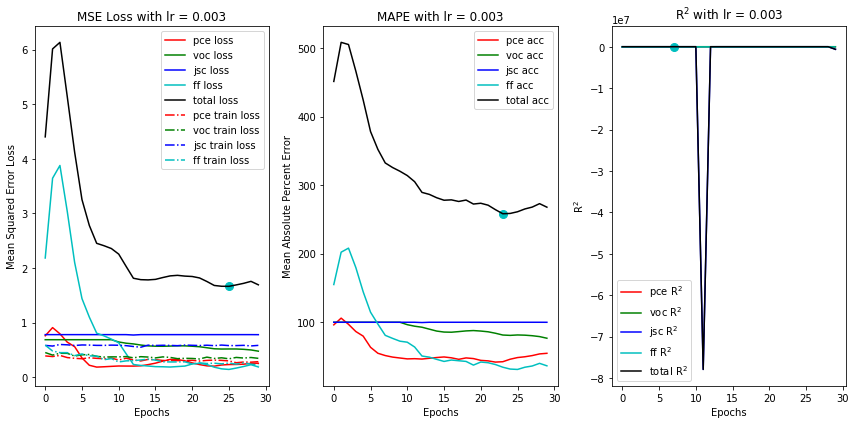

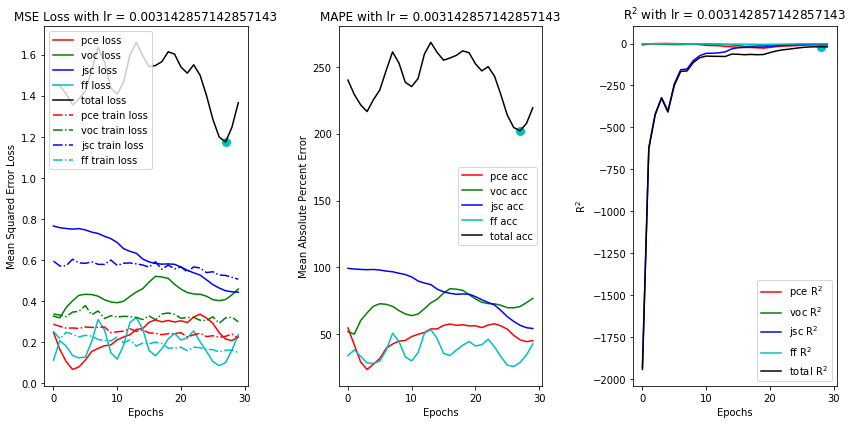

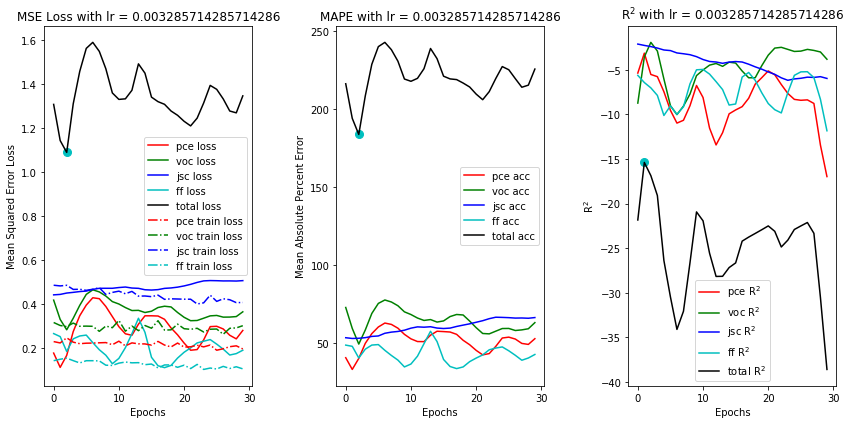

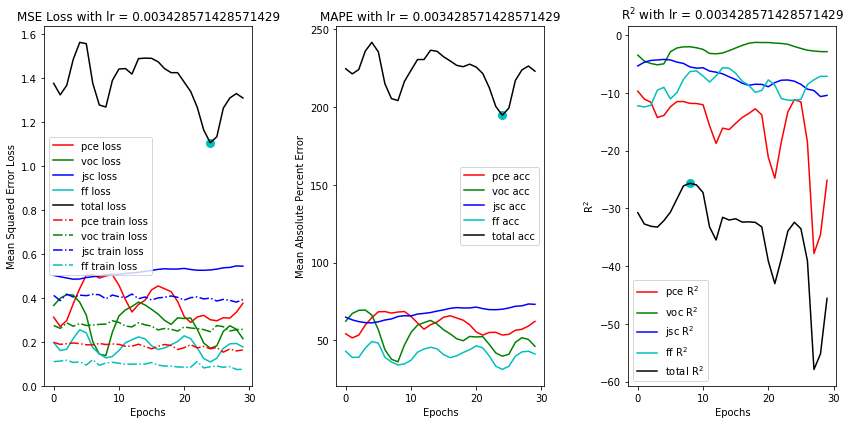

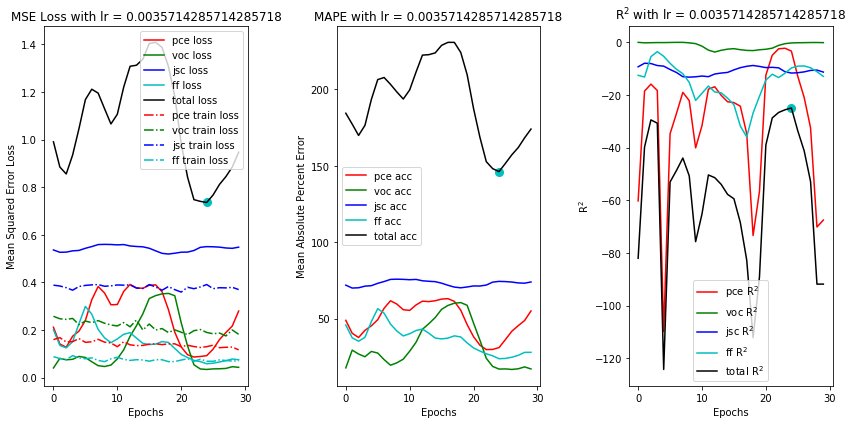

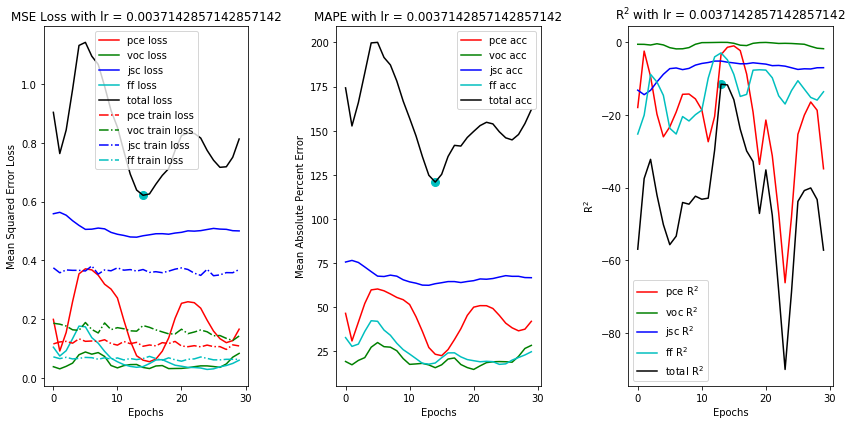

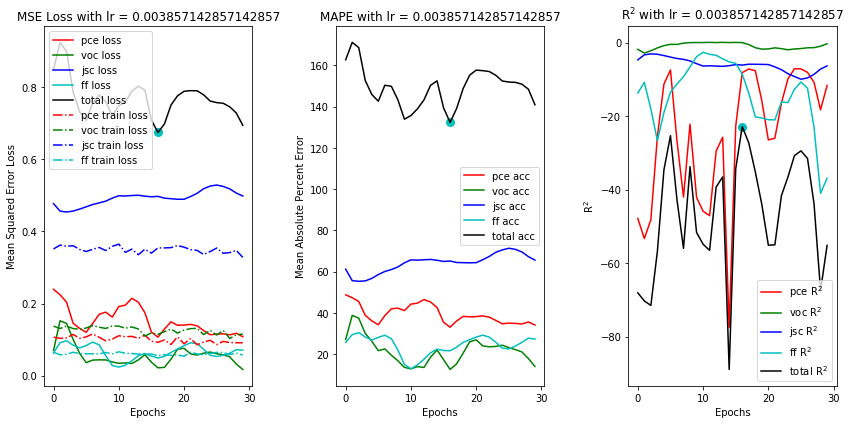

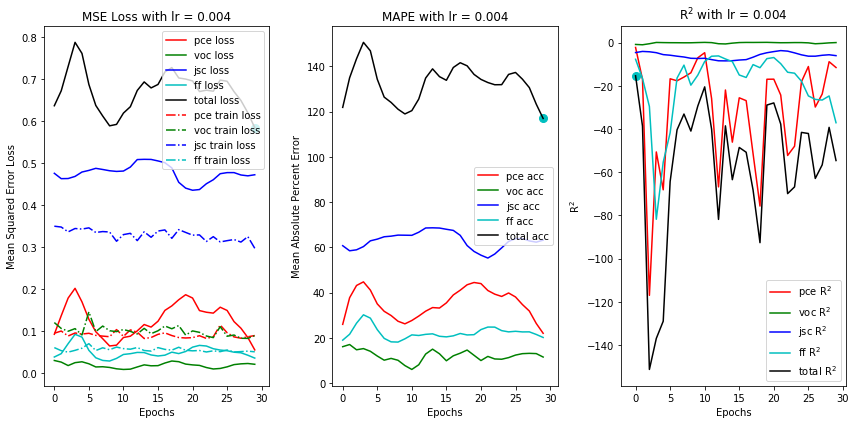

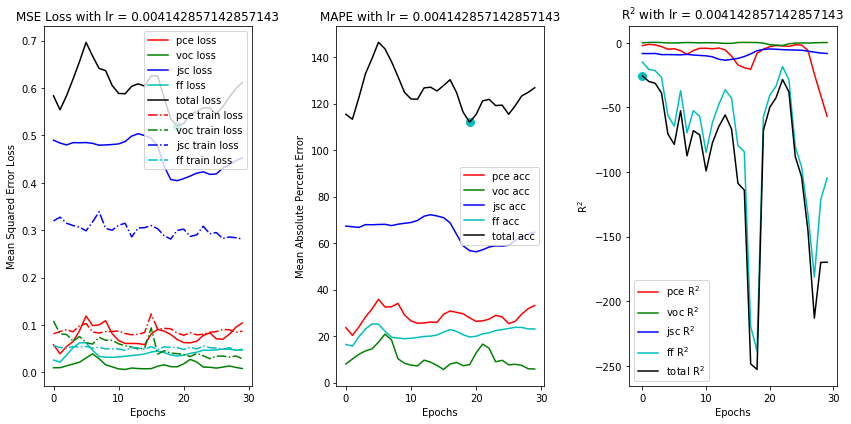

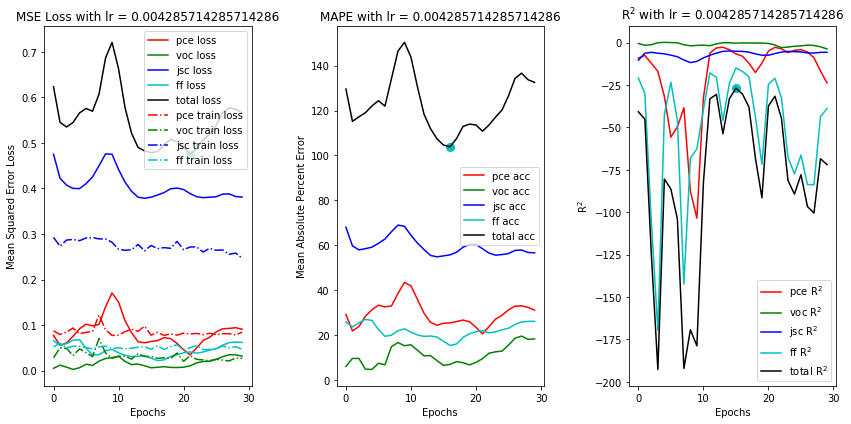

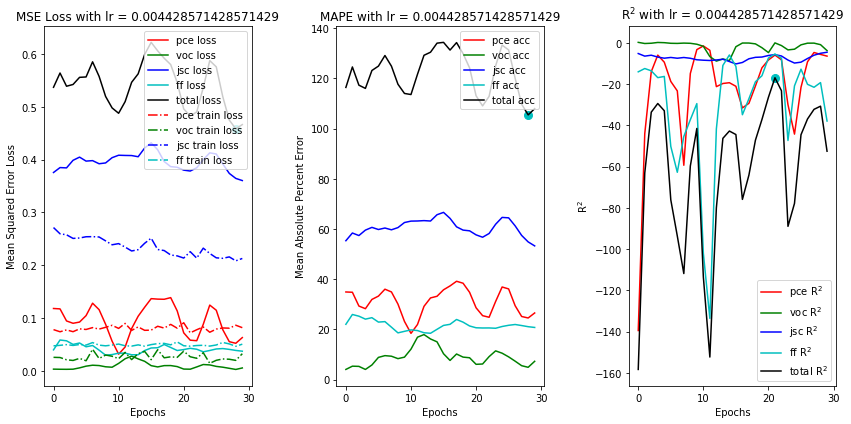

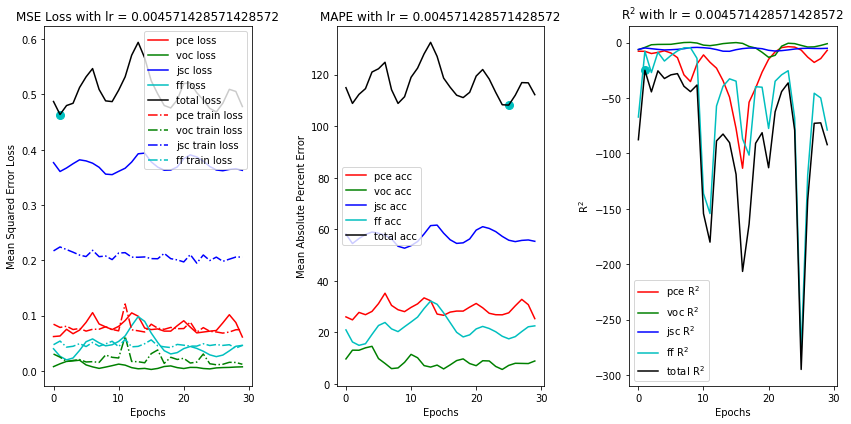

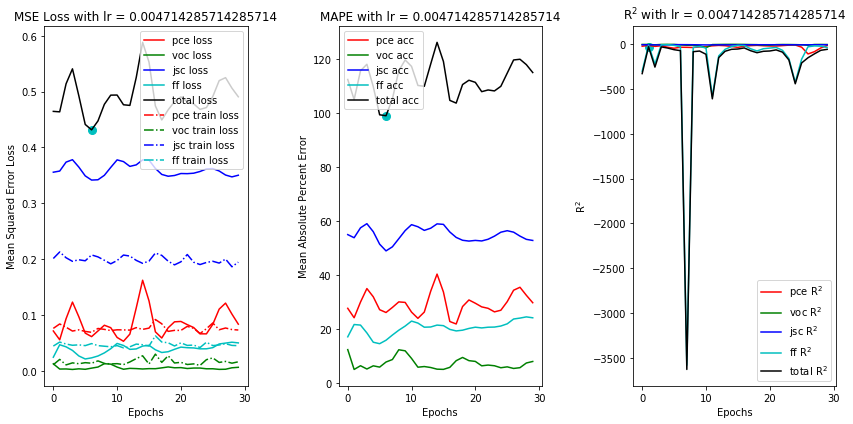

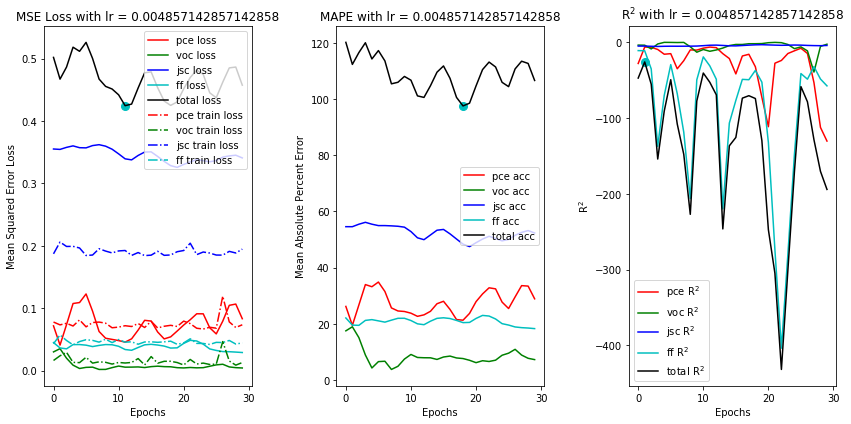

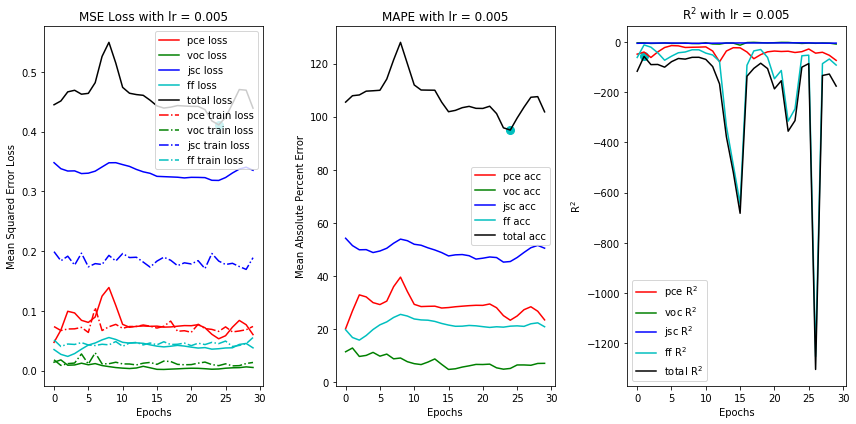

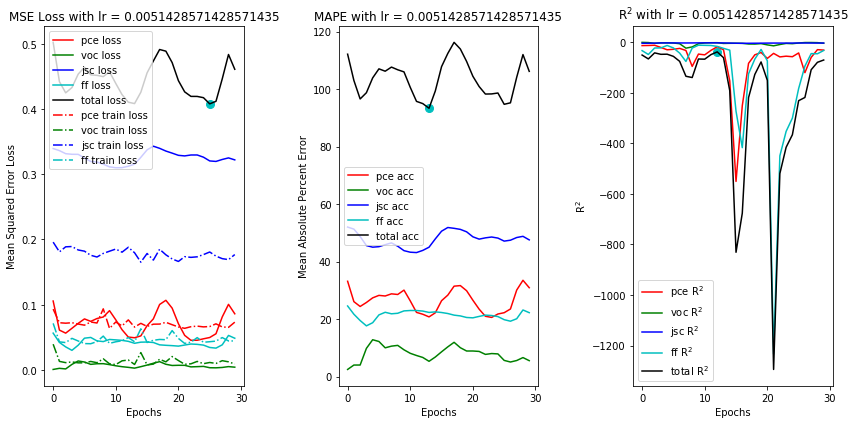

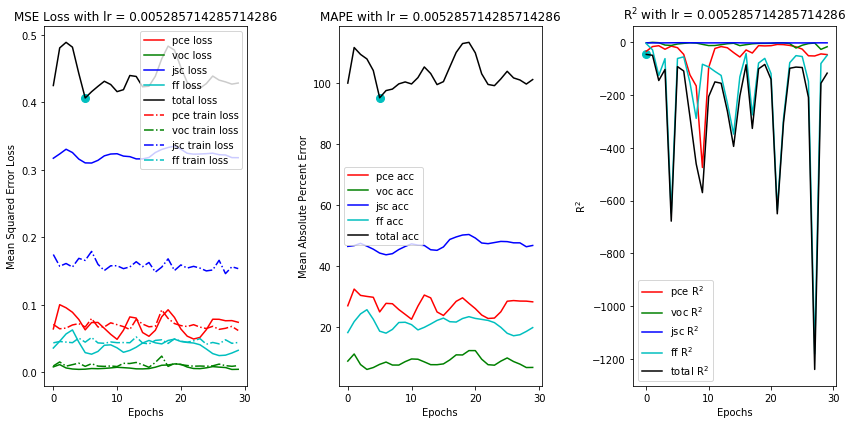

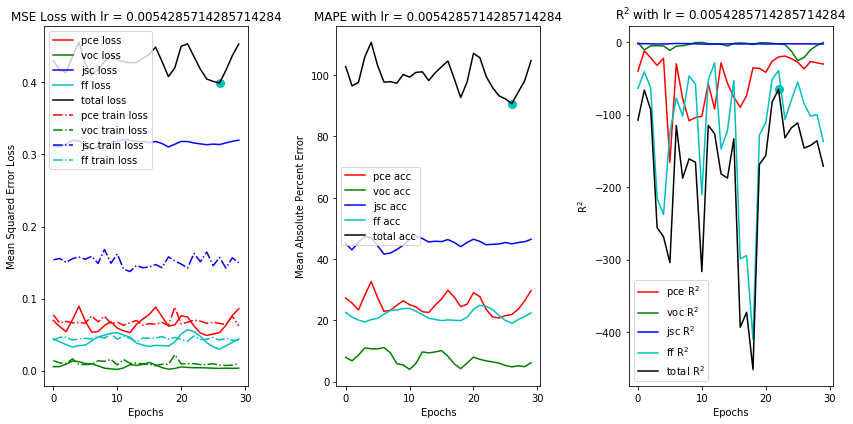

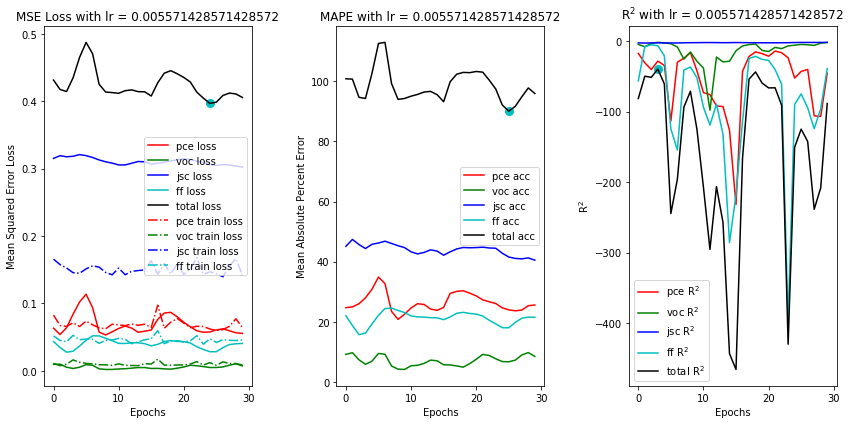

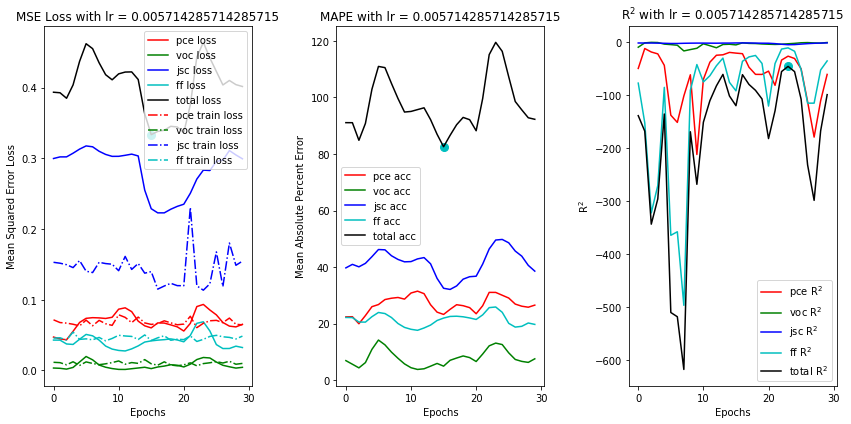

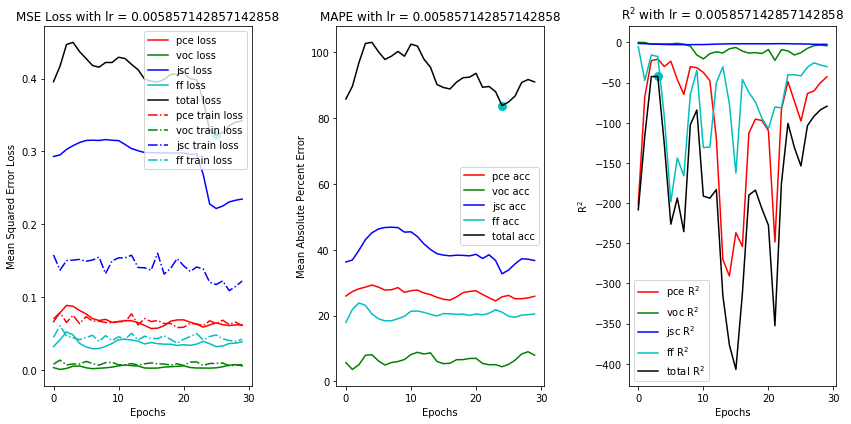

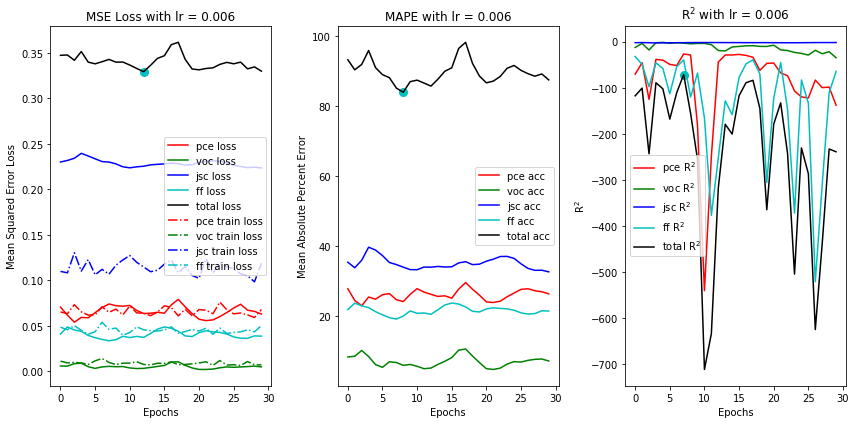

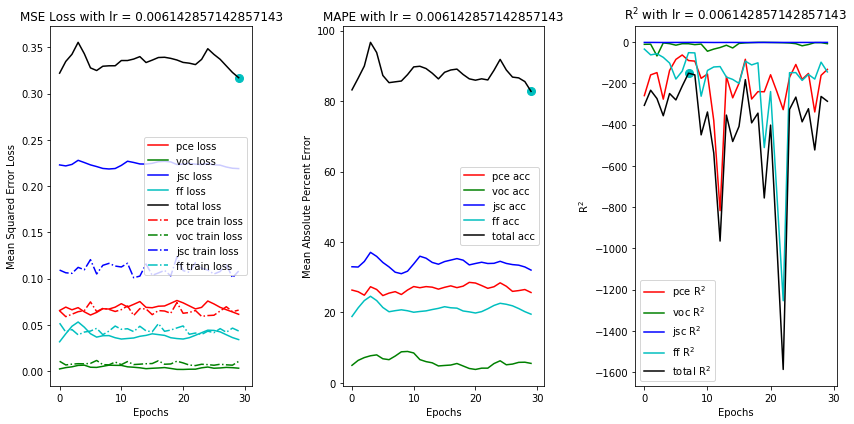

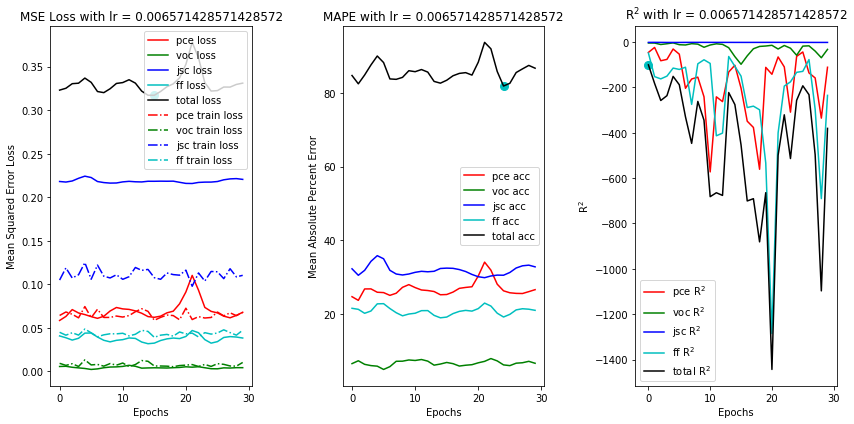

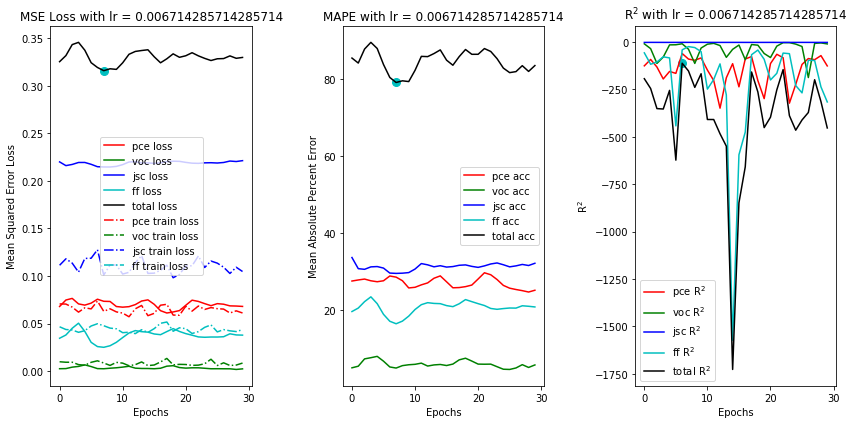

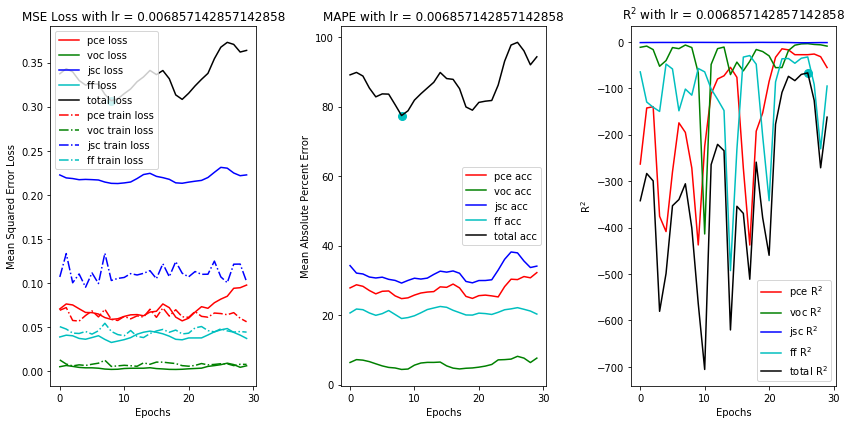

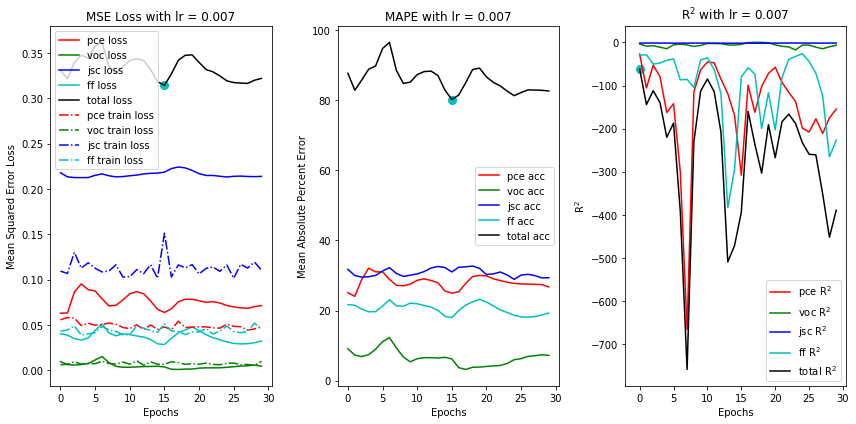

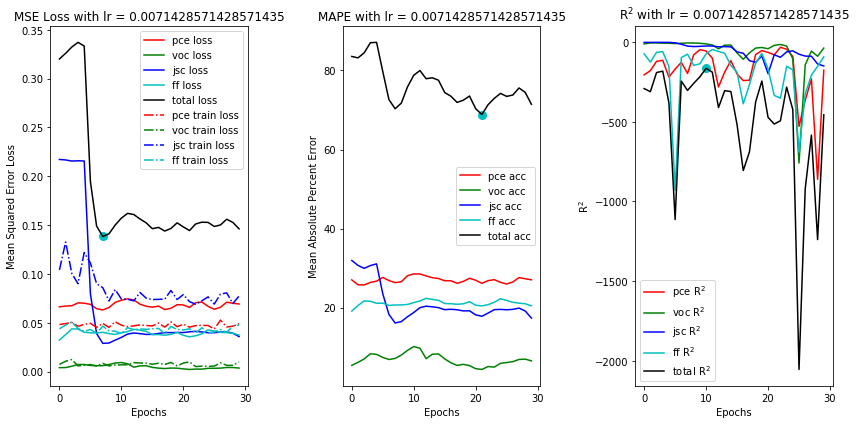

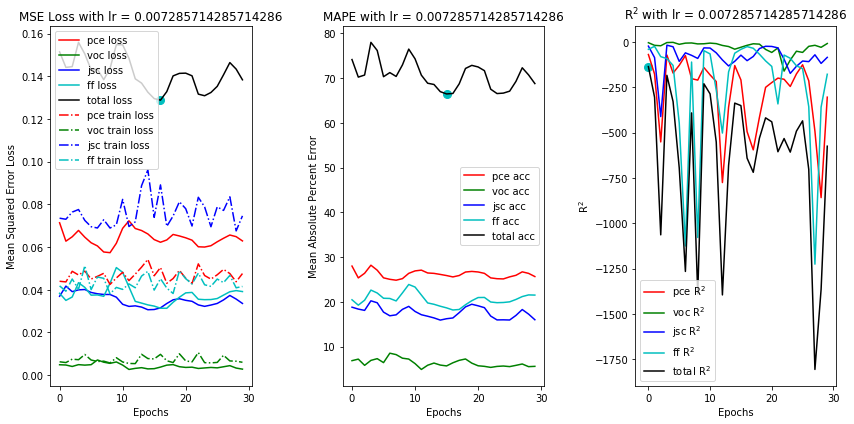

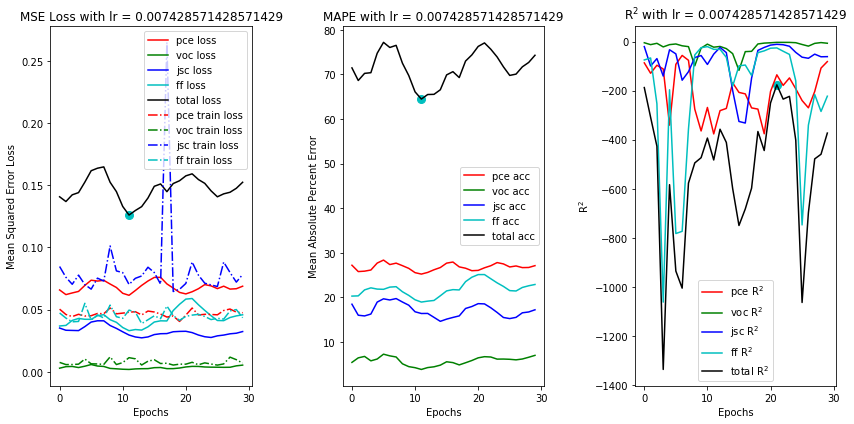

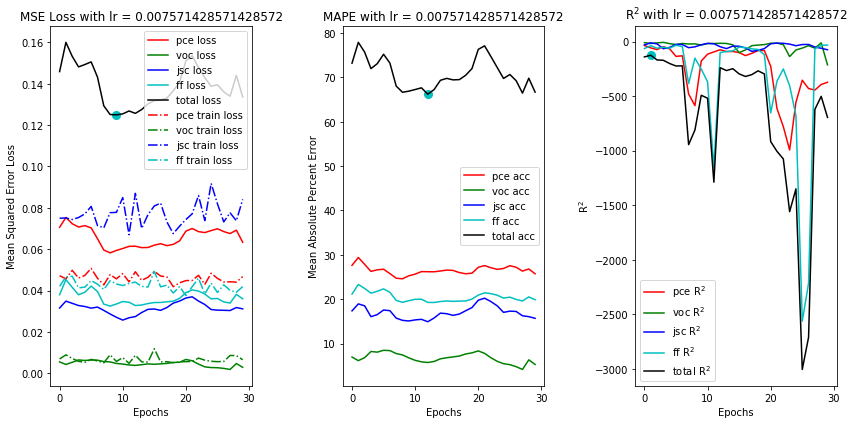

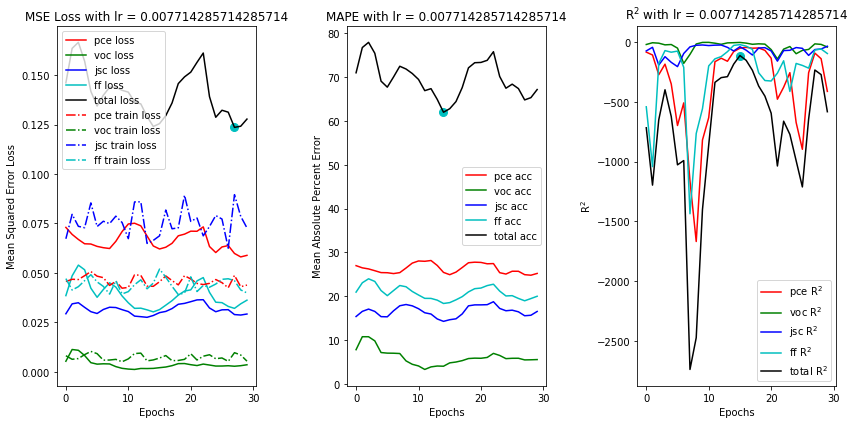

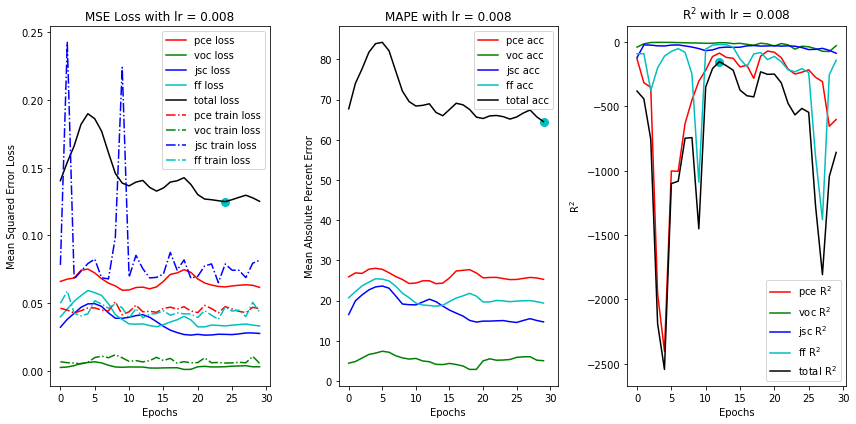

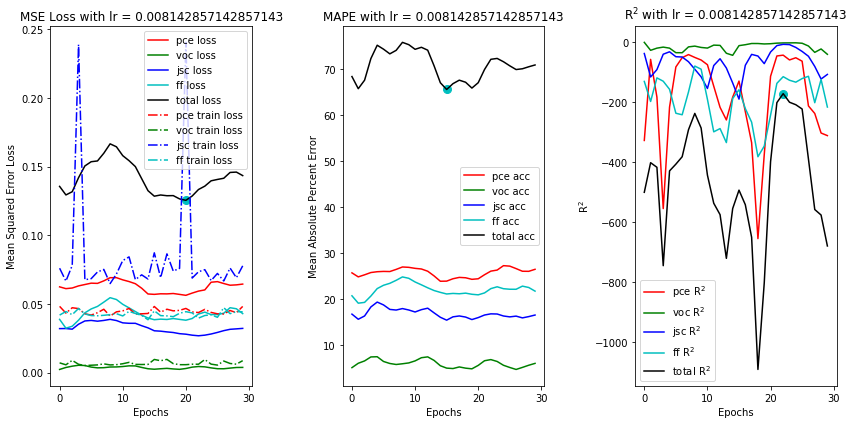

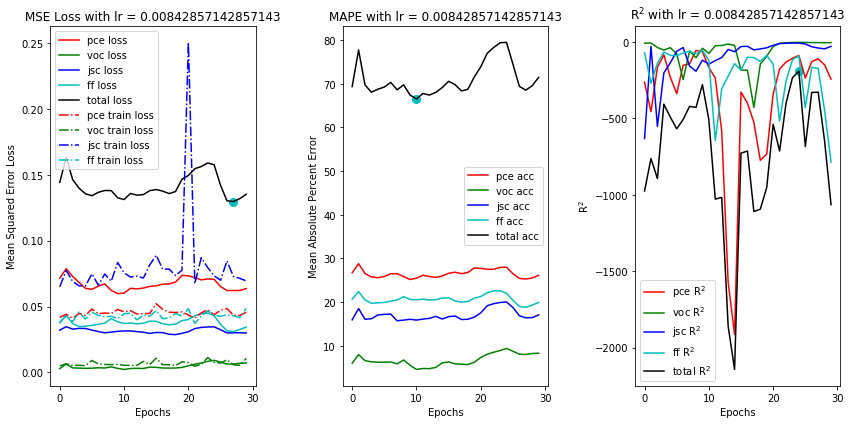

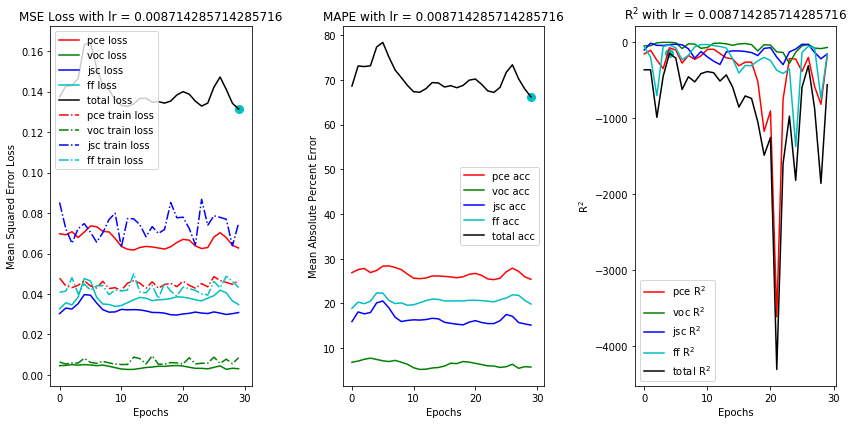

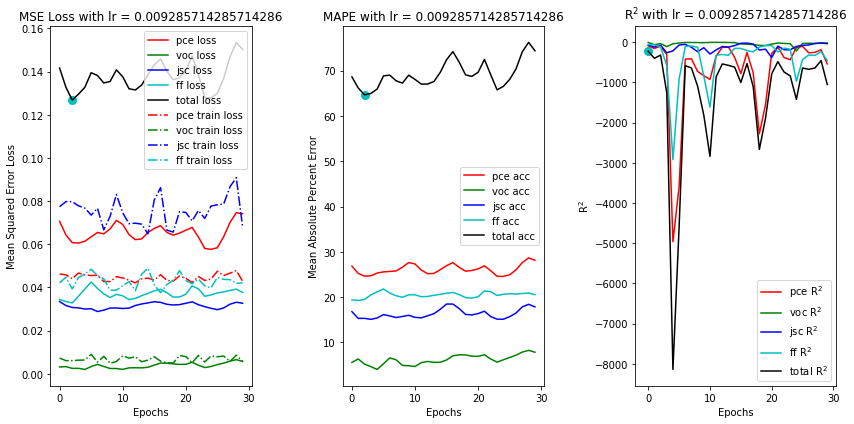

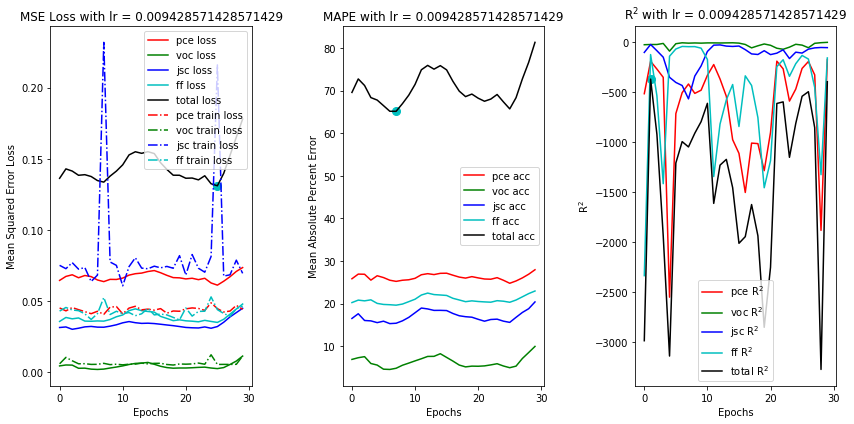

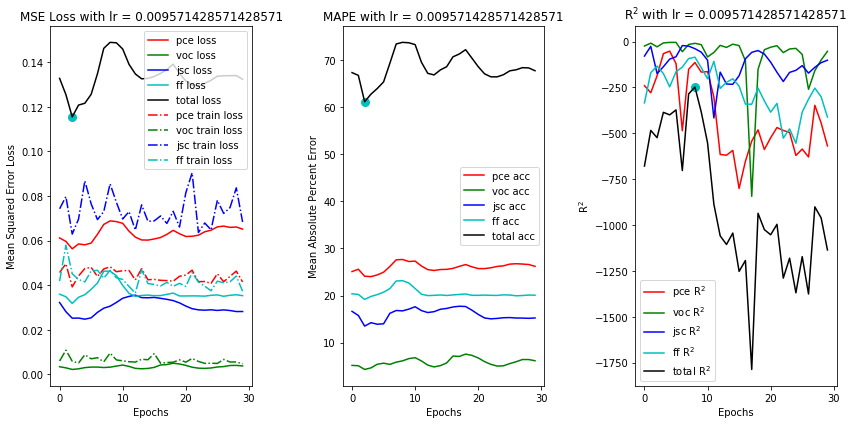

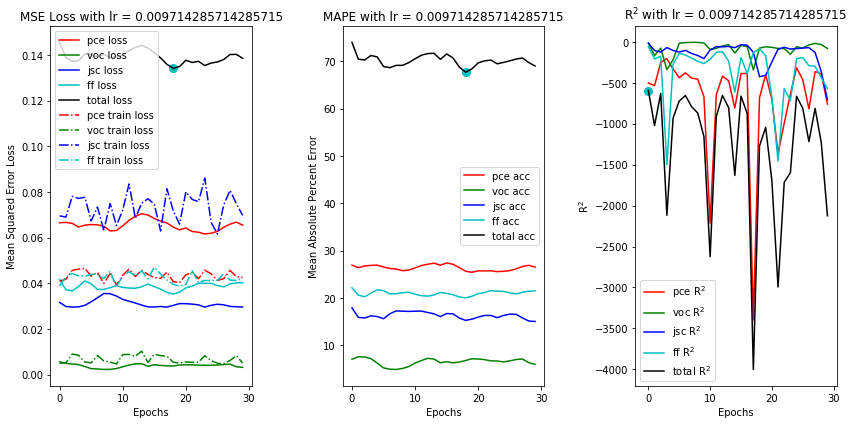

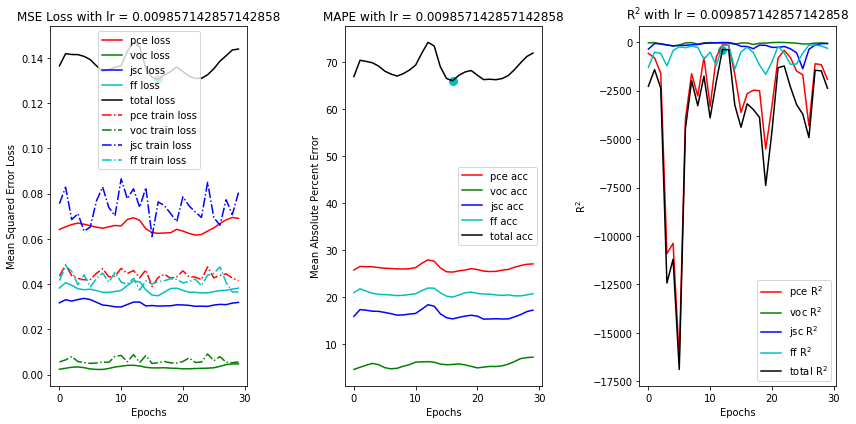

In [17]:
for key, fit_dict in data.items():
    plot_fit_results(fit_dict)

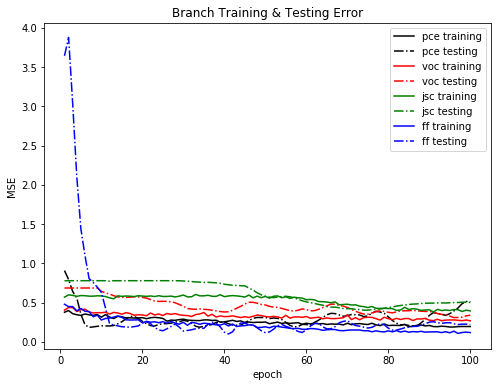

In [10]:
epochs = np.arange(1, (num_epochs+1), 1)

nuts.plot_OPV_df_loss(epochs, train_epoch_losses, test_epoch_losses,
                     pce_train_epoch_losses, pce_test_epoch_losses,
                     voc_train_epoch_losses, voc_test_epoch_losses,
                     jsc_train_epoch_losses, jsc_test_epoch_losses,
                     ff_train_epoch_losses, ff_test_epoch_losses)

nuts.plot_OPV_df_accuracies(epochs, pce_test_epoch_accuracies, voc_test_epoch_accuracies, 
                           jsc_test_epoch_accuracies, ff_test_epoch_accuracies)

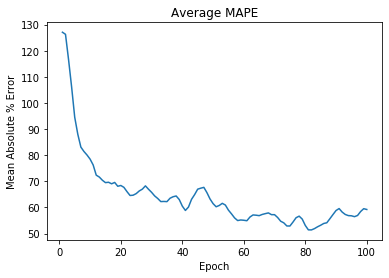

In [11]:
avg_acc = []
for p, v, j, f in zip(pce_test_epoch_accuracies, voc_test_epoch_accuracies,
                      jsc_test_epoch_accuracies, ff_test_epoch_accuracies):
    
    acc = (p+v+j+f)/4
    avg_acc.append(acc)
    
fig, ax = plt.subplots()
plt.plot(epochs, avg_acc)
plt.title('Average MAPE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute % Error')
plt.show()

In [12]:
potential_models = avg_acc[:45]

min_mape = min(potential_models)

best_acc_indx = []
for acc in potential_models:
    if acc == min_mape:
        best_acc_indx.append(potential_models.index(acc))
    else:
        pass

In [13]:
if best_acc_indx[0] < 10:
    epoch = f'0{best_acc_indx[0]}'
else:
    epoch = f'{best_acc_indx[0]}'

print(epoch)

best_model_path = save_dir + model_name + '_epoch' + epoch + '.pt'
best_model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)

best_model, best_optimizer = nuts.load_trained_model(best_model_path, best_model, optimizer)

40


In [14]:
best_model.eval()

with torch.no_grad():
    for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
        inputs = inputs.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)

        PCE_out, Voc_out, Jsc_out, FF_out = best_model(inputs)
        

mape = pilf.reg_MAPE()

pce_mse = mean_squared_error(PCE_out, pce_labels)
pce_r2 = r2_score(PCE_out, pce_labels)
pce_mape = mape.forward(PCE_out, pce_labels)

print(f'mse = {pce_mse}, mape = {pce_mape}, r2 = {pce_r2}')

voc_mse = mean_squared_error(Voc_out, voc_labels)
voc_r2 = r2_score(Voc_out, voc_labels)
voc_mape = mape.forward(Voc_out, voc_labels)

print(f'mse = {voc_mse}, mape = {voc_mape}, r2 = {voc_r2}')

jsc_mse = mean_squared_error(Jsc_out, jsc_labels)
jsc_r2 = r2_score(Jsc_out, jsc_labels)
jsc_mape = mape.forward(Jsc_out, jsc_labels)

print(f'mse = {jsc_mse}, mape = {jsc_mape}, r2 = {jsc_r2}')

ff_mse = mean_squared_error(FF_out, ff_labels)
ff_r2 = r2_score(FF_out, ff_labels)
ff_mape = mape.forward(FF_out, ff_labels)

print(f'mse = {ff_mse}, mape = {ff_mape}, r2 = {ff_r2}')

mse = 0.23039957880973816, mape = tensor([50.1154]), r2 = -11.730926619966505
mse = 0.38203567266464233, mape = tensor([61.8766]), r2 = -2.7078962531010147
mse = 0.7262677550315857, mape = tensor([96.4945]), r2 = -118.90725712880423
mse = 0.09909652173519135, mape = tensor([26.8761]), r2 = -1.5800683564654143


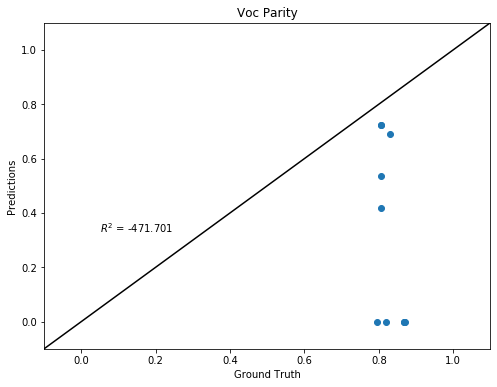

In [15]:
%autoreload

nuts.plot_OPV_parity(pce_labels, PCE_out, voc_labels, Voc_out,
                    jsc_labels, Jsc_out, ff_labels, FF_out)